In [258]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.manifold import TSNE
from sklearn.datasets import load_iris
import ruptures as rpt
from scipy.signal import find_peaks
from scipy.stats import norm
from scipy.ndimage import gaussian_filter1d
from sklearn.decomposition import PCA as SKPCA
import math
import os


## Where to change the patient file path

In [425]:
sub = Path(r'X:\RadcliffeE\for_MorganHampton_BoettcherScholar\Subject Case Data\IO_05_18_2023_b_LSTN_subject5\Processed DLC\csv folder')

## Patient Specific Items

In [421]:
# use this if one trial is incomplete or does not work well
# only put the depth with no front or side
skip_trails = []

## Functions

In [303]:
def convertDF(path): 
    '''converting a dataframe to a new datafrom with float, 5 decimal places and '''

    # reading in file, and skipping top row
    df = pd.read_csv(path, skiprows=1)

    print(df)

    # defining the titles of the rows
    body_loc = df.columns.tolist()

    # creating new empty dataframe
    df_new = pd.DataFrame()


    for part in body_loc:
        if part == 'bodyparts' in part:
            continue
        else:
            df_new[part] = pd.to_numeric(df[part].iloc[1:], errors='coerce').dropna().round(5).astype(float)


    # Copy your DataFrame
    cleaned_df = df_new.copy()

    # Get base marker names by stripping '.1' and '.2'
    marker_names = {'PalmBase', 'MCP1', 'MCP2', 'MCP3', 'MCP4', 'MCP5', 'fTip1', 'fTip2', 'fTip3', 'fTip4', 'fTip5', 'MidForeArm', 'Elbow'}

    print(marker_names)

    for marker in marker_names:
        x_col = marker
        y_col = marker + '.1'
        l_col = marker + '.2'

        # Phase 1: Find first row where likelihood >= 0.8
        # Boolean mask for where likelihood >= 0.95
        high_likelihood = cleaned_df[l_col] >= 0.95

        # Find where two consecutive values are both True
        consecutive_valid = high_likelihood & high_likelihood.shift(-1, fill_value=False)

        # Get the index of the first such occurrence
        first_valid_idx = consecutive_valid[consecutive_valid].index.min()

        # Remove all rows before first high-confidence point
        cleaned_df.loc[:first_valid_idx - 1, [l_col]] = np.nan

        # Phase 2: Set x/y to NaN where likelihood < 0.95
        low_conf_mask = cleaned_df[l_col] < 0.95
        cleaned_df.loc[low_conf_mask, [x_col, y_col]] = np.nan

        # Interpolate x and y
        cleaned_df[[x_col, y_col]] = cleaned_df[[x_col, y_col]].interpolate(method='linear', limit_direction='both')

        # Phase 3: Set x and y to 0 where likelihood is NaN
        nan_likelihood_mask = cleaned_df[l_col].isna()
        cleaned_df.loc[nan_likelihood_mask, [x_col, y_col]] = 0


    # (Optional) Reset index or drop NaNs if needed
    # cleaned_df = cleaned_df.dropna(subset=marker_names)  # if you want to drop completely bad rows

    # cleaned_df now has cleaned x/y data based on per-marker likelihoods

    cleaned_df


    return cleaned_df

In [ ]:
def hand_PS_mov(df, t, slope_threshold=0.05, window=5):
    '''reports the peaks and the troughs'''

    if not hasattr(t, '__iter__') or len(t) < 2:
        print(f"Invalid 't' input: {t}")
        return np.array([], dtype=int), np.array([], dtype=int), np.array([])


    def gauss_smooth_uniform(yin, dt, gkern_std):
        sigma_samples = gkern_std / dt
        yout = gaussian_filter1d(yin, sigma=sigma_samples, mode='reflect')
        return yout

    start_idx = int(t[0])
    end_idx = int(t[-1]) + 1

    fy = df['fTip1'][start_idx:end_idx].values 
    py = df['PalmBase'][start_idx:end_idx].values
    t_np = np.arange(start_idx, end_idx)

    euc_dis_bef = fy - py
    euc_dis = gauss_smooth_uniform(euc_dis_bef, 0.01, 0.05)

    peaks, _ = find_peaks(euc_dis, distance=None, prominence=3, width=3)
    troughs, _ = find_peaks(-euc_dis, distance=None, prominence=5, width=5)

    print(f"Raw peaks: {peaks}, dtype: {peaks.dtype}")
    print(f"Raw troughs: {troughs}, dtype: {troughs.dtype}")

    peaks = peaks[peaks < len(t_np)]
    troughs = troughs[troughs < len(t_np)]

    # Cast explicitly to int
    peaks = np.array(peaks).astype(int)
    troughs = np.array(troughs).astype(int)

    try:
        t_peak = t_np[peaks]
        t_trough = t_np[troughs]
    except Exception as e:
        print(f"Error indexing t_np with peaks/troughs: {e}")
        t_peak = np.array([], dtype=int)
        t_trough = np.array([], dtype=int)

    return t_peak, t_trough, euc_dis


In [405]:
def arm_EF_mov(df, t):
    '''reports the peaks and troughs'''

    def gauss_smooth_uniform(yin, dt, gkern_std):
        """
        Smooth 'yin' using a Gaussian filter via convolution.
        
        Parameters:
            yin : numpy array of signal values
            dt : time step between samples (e.g., 0.001 for 1kHz)
            gkern_std : Gaussian kernel std in time units (e.g., 0.05s)
        
        """
        # Convert gkern_std from time units to number of samples
        sigma_samples = gkern_std / dt
        yout = gaussian_filter1d(yin, sigma=sigma_samples, mode='reflect')
        return yout
    
    # point of interest
    fTip3 = df['fTip3']


    start_idx = int(t[0])
    end_idx = int(t[-1]) + 1

    y_unsmooth = fTip3[start_idx:end_idx].values
    y_unsmooth = np.array(y_unsmooth).flatten().astype(np.float64)
    y = gauss_smooth_uniform(y_unsmooth, 0.01, 0.05)
    t_np = np.arange(start_idx, end_idx)

    peaks, _ = find_peaks(y, height=300, threshold=None, distance=80, prominence=None, width=10, wlen=None, rel_height=0.5, plateau_size=None)
    troughs, _ = find_peaks(-y, height=None, threshold=None, distance=80, prominence=None, width=10, wlen=None, rel_height=0.5, plateau_size=None)

    # Filter out indices that are out of bounds
    peaks = peaks[peaks < len(t_np)]
    troughs = troughs[troughs < len(t_np)]

    t_peak = t_np[peaks]
    t_trough = t_np[troughs]

    return t_peak, t_trough, y

In [401]:
def hand_OC_mov(df, t, slope_threshold=0.05, window=5):
    '''
    Reports the peaks and troughs from the Euclidean distance after filtering flat regions.
    '''

    def gauss_smooth_uniform(yin, dt, gkern_std):
        """
        Smooth 'yin' using a Gaussian filter via convolution.
        
        Parameters:
            yin : numpy array of signal values
            dt : time step between samples (e.g., 0.001 for 1kHz)
            gkern_std : Gaussian kernel std in time units (e.g., 0.05s)
        
        """
        # Convert gkern_std from time units to number of samples
        sigma_samples = gkern_std / dt
        yout = gaussian_filter1d(yin, sigma=sigma_samples, mode='reflect')
        return yout

    # --- Signal extraction ---
    start_idx = int(t[0])
    end_idx = int(t[-1]) + 1

    fy = df['fTip3.1'][start_idx:end_idx].values 
    py = df['PalmBase.1'][start_idx:end_idx].values
    t_np = np.arange(start_idx, end_idx)

    # Element-wise subtraction: col1 - col2
    euc_dis_bef = fy - py
    euc_dis = gauss_smooth_uniform(euc_dis_bef, 0.01, 0.05)

    # --- Peak & Trough Detection ---
    peaks, _ = find_peaks(euc_dis, height=None, distance=30, prominence=5, width=5)
    troughs, _ = find_peaks(-euc_dis, distance=None, prominence=5, width=5)

    # --- Boundary Filter ---
    peaks = peaks[peaks < len(t_np)]
    troughs = troughs[troughs < len(t_np)]

    # --- Time Mapping ---
    t_peak = t_np[peaks]
    t_trough = t_np[troughs]

    return t_peak, t_trough, euc_dis


In [395]:
def compute_peaks_troughs(row):
    base = row['dataset']  # like 'b1', 't2', etc.
    view = row['view']     # 'front' or 'side'

    if view == 'side':
        return None  # Skip side views early exit

    try:
        dff = dataframes.get(base + 'f')
        hand_OC_peaks, hand_OC_troughs, hand_OC_euclidean = hand_OC_mov(dff, row['hand_OC'])
        hand_PS_peaks, hand_PS_troughs, hand_PS_euclidean = hand_PS_mov(dff, row['hand_PS'])
        arm_EF_peaks, arm_EF_troughs, arm_EF_data = arm_EF_mov(dff, row['arm_EF'])

        # Ensure integer arrays for indexing later
        hand_OC_peaks = np.array(hand_OC_peaks, dtype=int)
        hand_OC_troughs = np.array(hand_OC_troughs, dtype=int)
        hand_PS_peaks = np.array(hand_PS_peaks, dtype=int)
        hand_PS_troughs = np.array(hand_PS_troughs, dtype=int)
        arm_EF_peaks = np.array(arm_EF_peaks, dtype=int)
        arm_EF_troughs = np.array(arm_EF_troughs, dtype=int)

        # Return Series with all front-view metrics
        return pd.Series({
            'hand_OC_peaks': hand_OC_peaks,
            'hand_OC_troughs': hand_OC_troughs,
            'hand_OC_euclidean_dis': hand_OC_euclidean,
            'hand_PS_peaks': hand_PS_peaks,
            'hand_PS_troughs': hand_PS_troughs,
            'hand_PS_euclidean_dis': hand_PS_euclidean,
            'arm_EF_peaks': arm_EF_peaks,
            'arm_EF_troughs': arm_EF_troughs,
            'arm_EF_data': arm_EF_data
        })

    except Exception as e:
        print(f"Error processing row {row.name}: {e}")
        # Return a Series filled with None for all expected outputs
        return pd.Series({
            'hand_OC_peaks': None, 'hand_OC_troughs': None, 'hand_OC_euclidean_dis': None,
            'hand_PS_peaks': None, 'hand_PS_troughs': None,
            'arm_EF_peaks': None, 'arm_EF_troughs': None
        })

In [308]:
def run_PCA(X, indices, view, mov, n_components=None):
    '''Calculates PCA for one camera view and one probe position'''

    # 1. Takes into consideration if there are indices or not (helpful for when looking at specific movement)
    if indices is not None:
        X_subset = X.iloc[indices[0]:indices[1]+1]
    else:
        X_subset = X

    # 2. Drop columns containing '.2' --> dropping likelihood rows
    df = X_subset.loc[:, ~X_subset.columns.str.contains(r'\.2')]

    # 3. Remove constant columns --> gets rid of runs that were unsuccessful 
    stds = df.std(axis=0)
    df = df.loc[:, stds != 0]

    # 4. Standardize the data --> standardize mean to 0 and std to 1 (suggested from geeks for geeks)
    scaler = StandardScaler()
    X_standardized = scaler.fit_transform(df)

    # 5. Apply PCA
    pca = SKPCA(n_components=n_components)
    X_pca = pca.fit_transform(X_standardized)

    # 6. Output
    explained_variance_ratio = pca.explained_variance_ratio_
    explained_variance = pca.explained_variance_
    pca_components = pca.components_ # direction (vectors) the define the PCs in the original feature space pca_components[0] are the scores in regards to PCA1



    return X_pca, explained_variance_ratio, explained_variance, pca_components


def trim_initial_zeros(df):
    """
    Trims the DataFrame by removing rows at the beginning where ANY column is 0.
    Once all columns have non-zero values, keeps everything from that row on.
    Necessary because rows were set to 0 when filtering likelihood
    """
    mask = (df != 0).any(axis=1)
    first_valid_index = mask.idxmax()  # first row where any column is non-zero
    return df.loc[first_valid_index:].reset_index(drop=True)

In [309]:
def average_close_indices(index_list, threshold=100):
    if not index_list:
        return []

    averaged = []
    current_group = [index_list[0]]

    for i in range(1, len(index_list)):
        if abs(index_list[i] - sum(current_group)/len(current_group)) <= threshold:
            current_group.append(index_list[i])
        else:
            # Commit the average of the current group
            averaged.append(int(sum(current_group)/len(current_group)))
            # Start new group
            current_group = [index_list[i]]

    # Don't forget the last group
    averaged.append(int(sum(current_group)/len(current_group)))
    return averaged


In [310]:
def gauss_smooth_uniform(yin, dt, gkern_std):
    """
    Smooth 'yin' using a Gaussian filter via convolution.
    
    Parameters:
        yin : numpy array of signal values
        dt : time step between samples (e.g., 0.001 for 1kHz)
        gkern_std : Gaussian kernel std in time units (e.g., 0.05s)
    
    """
    # Convert gkern_std from time units to number of samples
    sigma_samples = gkern_std / dt
    yout = gaussian_filter1d(yin, sigma=sigma_samples, mode='reflect')
    return yout


## Creates dataframes for each depth

In [426]:
# list of all the videos for subject 
dbs_loc = ['b1f', 'b1s', 'b2f', 'b2s', 'b3f', 'b3s', 'c1f', 'c1s', 'c2f', 'c2s', 'c3f', 'c3s', 't1f', 't1s', 't2f', 't2s', 't3f', 't3s']

# place to store all the df
dataframes = {}

files = list(sub.iterdir())

# First, filter out the LC2 files from sub directory
valid_files = [file for file in sub.iterdir() if 'LC2' not in file.name]

# Now zip with dbs_loc
for file, label in zip(valid_files, dbs_loc):
    if not label:
        continue  # Skip if label is None, empty string, etc.

    dataframes[label] = convertDF(file)
    print(f"{label} loaded from {file.name}")



     bodyparts         StablePoint       StablePoint.1       StablePoint.2  \
0       coords                   x                   y          likelihood   
1            0   332.1014404296875  105.97794342041016  0.9619237184524536   
2            1  331.93743896484375   105.5188980102539  0.9588293433189392   
3            2   331.8313903808594  105.90538024902344  0.9636037349700928   
4            3   331.7799072265625  105.61786651611328  0.9658036231994629   
...        ...                 ...                 ...                 ...   
2962      2961   331.6282958984375  105.70880126953125  0.9634701609611511   
2963      2962   331.8255615234375  105.85028076171875   0.966151773929596   
2964      2963   331.8372497558594  105.70732116699219  0.9650205373764038   
2965      2964   331.9154052734375  105.84436798095703  0.9630897641181946   
2966      2965   331.7934265136719  105.69947814941406  0.9650121927261353   

                PalmBase          PalmBase.1          PalmBase.

## Creates df for PC1 and PC2 for top 5 features

In [427]:
# creates empty lists for all view scores and one for only the PCA1 scores
rows_front = []
rows_side = []
pca1_rows = []
pca2_rows = []
explained_var_rows = []
top5_pc1_rows = []

# iterates over each view and depth (b1s, b1f, b2s......)
# creates new df (pca1_df) with all the scores from PC1 in regards to each movement
for i in dataframes:
    base = i    # like 'b1f', 't2s'
    mov = 'all'  # looking at full video, not yet sectioning out the movements
    df = dataframes[base]  # setting df to qual the data from b1f for example

    # Trim zeros from beginning of view
    view_trimmed = trim_initial_zeros(df)

    # Run PCA on trimmed data
    X_pca, explained_variance_ratio, explained_variance_raw, components = run_PCA(view_trimmed, None, base, mov)

    # Extract original columns used in PCA (excluding dropped/constant)
    used_columns = view_trimmed.loc[:, ~view_trimmed.columns.str.contains(r'\.2')]
    stds = used_columns.std(axis=0)
    final_cols = used_columns.loc[:, stds != 0].columns.tolist()



    print(f' For {base} the variance for PC1 is {explained_variance_ratio[0]} and PC2 is {explained_variance_ratio[1]}')

    #Storing each into a new dataframe to later pull from 
    # Extract depth and view info from 'base'
    depth = base[:-1]  # e.g. 'b1f' -> 'b1'
    view_type = 'front' if base.endswith('f') else 'side'

    # PC1 and PC2 component weights (loadings)
    pc1 = components[0]
    pc2 = components[1]

    # Create a dict for this depth/view row (PC1)
    row_pc1 = {
        "depth": depth,
        "view": view_type,
        "component": "PC1"
    }

    # Create a dict for PC2
    row_pc2 = {
        "depth": depth,
        "view": view_type,
        "component": "PC2"
    }


    # Add feature component weights to both PC1 and PC2 rows
    for feat, weight1, weight2 in zip(final_cols, pc1, pc2):
        row_pc1[feat] = weight1
        row_pc2[feat] = weight2

    # Append both rows
    pca1_rows.append(row_pc1)
    pca2_rows.append(row_pc2)

    explained_var_rows.append({
        "depth": depth,
        "view": view_type,
        "PC1_var": explained_variance_ratio[0],
        "PC2_var": explained_variance_ratio[1],
    })


    # Create list of (feature, weight) for PC1
    feature_contributions = list(zip(final_cols, pc1))

    # Sort by absolute contribution descending
    feature_contributions.sort(key=lambda x: abs(x[1]), reverse=True)

    # Take top 5 contributors
    top5 = feature_contributions[:5]

    # Save top 5 contributors for PC1
    top5_dict = {
        "depth": depth,
        "view": view_type
    }
    for idx, (feat, weight) in enumerate(top5):
        top5_dict[f"feature_{idx+1}"] = feat
        top5_dict[f"weight_{idx+1}"] = weight
    top5_pc1_rows.append(top5_dict)

    # At the end of the loop (outside the for i in dataframes loop), convert lists to DataFrames:
    pca1_df = pd.DataFrame(pca1_rows)
    pca2_df = pd.DataFrame(pca2_rows)
    explained_df = pd.DataFrame(explained_var_rows)
    top5_df = pd.DataFrame(top5_pc1_rows)


top5_df

 For b1f the variance for PC1 is 0.6086428408967178 and PC2 is 0.15925001643449094
 For b1s the variance for PC1 is 0.7485418506686864 and PC2 is 0.07947863996052676
 For b2f the variance for PC1 is 0.6783038615948795 and PC2 is 0.15253267572985327
 For b2s the variance for PC1 is 0.5817809383341876 and PC2 is 0.21066646094149097
 For b3f the variance for PC1 is 0.5373434741020688 and PC2 is 0.1432323973263766
 For b3s the variance for PC1 is 0.575856889261825 and PC2 is 0.12059923580449156
 For c1f the variance for PC1 is 0.5393273892766546 and PC2 is 0.12309038404399156
 For c1s the variance for PC1 is 0.3668274721003692 and PC2 is 0.21499874875265723
 For c2f the variance for PC1 is 0.45795239598042287 and PC2 is 0.29940997966810157
 For c2s the variance for PC1 is 0.46246601811263105 and PC2 is 0.2586787701099311
 For c3f the variance for PC1 is 0.5018494419093672 and PC2 is 0.15787609441104802
 For c3s the variance for PC1 is 0.5643970458668393 and PC2 is 0.17976527788037525
 For 

depth   view     feature_1  weight_1     feature_2  weight_2   feature_3  \
0     b1  front         fTip4  0.240195         fTip3  0.240193       fTip2   
1     b1   side       fTip5.1  0.212569       fTip4.1  0.211958        MCP3   
2     b2  front    MidForeArm  0.226957         fTip1  0.224402       fTip3   
3     b2   side        MCP2.1  0.224023        MCP3.1  0.219706  PalmBase.1   
4     b3  front    MidForeArm  0.251483  MidForeArm.1 -0.251136      MCP3.1   
5     b3   side          MCP3  0.240235    PalmBase.1  0.238082       fTip2   
6     c1  front  MidForeArm.1  0.246239        MCP3.1  0.245747  MidForeArm   
7     c1   side        MCP5.1  0.298353        MCP4.1  0.297239      MCP2.1   
8     c2  front         fTip3  0.256594         fTip2  0.255790       fTip1   
9     c2   side          MCP3  0.259420          MCP4  0.258810      MCP2.1   
10    c3  front        MCP3.1  0.258955        MCP4.1  0.258536      MCP5.1   
11    c3   side          MCP3  0.243945          MCP4  0.242951  PalmBase.1   
12    t1  front          MCP4  0.261754        MCP5.1 -0.258932        MCP5   
13    t1   side        MCP3.1  0.257223       fTip2.1  0.257215      MCP4.1   
14    t2  front         fTip3  0.277743    MidForeArm  0.276903       fTip4   
15    t2   side    PalmBase.1  0.274476        MCP5.1  0.272307      MCP3.1   
16    t3  front    MidForeArm  0.251505         fTip3  0.248687       fTip4   
17    t3   side        MCP2.1  0.263976    PalmBase.1  0.263734        MCP3   

    weight_3     feature_4  weight_4 feature_5  weight_5  
0   0.239258         fTip1  0.238349      MCP1  0.236926  
1   0.211653          MCP4  0.211527      MCP5  0.210936  
2   0.223139         Elbow  0.222746   Elbow.1  0.222197  
3   0.218307        MCP4.1  0.215962     fTip3 -0.214224  
4  -0.245257       Elbow.1 -0.239917    MCP4.1 -0.238521  
5   0.235108          MCP4  0.234436    MCP3.1  0.231664  
6  -0.245362        MCP5.1  0.244842    MCP4.1  0.244416  
7   0.289358        MCP3.1  0.289122      MCP3  0.282804  
8   0.253695         fTip4  0.248329      MCP1  0.244868  
9   0.255067        MCP3.1  0.253752      MCP5  0.252241  
10  0.258401  MidForeArm.1  0.254775   fTip5.1  0.249617  
11  0.240856          MCP2  0.240267      MCP5  0.239753  
12  0.258328        MCP4.1 -0.257781      MCP3  0.257516  
13  0.255956        MCP5.1  0.255838    MCP2.1  0.255780  
14  0.273602         fTip2  0.271938     fTip5  0.260038  
15  0.271940        MCP2.1  0.271686      MCP3  0.271669  
16  0.243364         fTip2  0.240887     Elbow  0.240223  
17  0.261732        MCP3.1  0.261249    MCP4.1  0.259082

## Outputs the explained variance for PC1 and PC2

In [428]:
# Initialize empty lists before loop
pca1_rows = []
pca2_rows = []
explained_var_rows = []
top5_pc1_rows = []
top5_pc2_rows = []

for base in dataframes:
    mov = 'all'  # example movement label
    df = dataframes[base]

    # Trim zeros from beginning of view
    view_trimmed = trim_initial_zeros(df)

    # Extract original columns used in PCA (excluding dropped/constant)
    used_columns = view_trimmed.loc[:, ~view_trimmed.columns.str.contains(r'\.2')]
    stds = used_columns.std(axis=0)
    final_cols = used_columns.loc[:, stds != 0].columns.tolist()

    # Run PCA on trimmed data
    X_pca, explained_variance_ratio, explained_variance_raw, components = run_PCA(view_trimmed, None, base, mov)

    print(f'For {base} the variance for PC1 is {explained_variance_ratio[0]:.4f} and PC2 is {explained_variance_ratio[1]:.4f}')

    # Extract depth and view info from 'base'
    depth = base[:-1]  # e.g. 'b1f' -> 'b1'
    view_type = 'front' if base.endswith('f') else 'side'

    # PC1 and PC2 component weights (loadings)
    pc1 = components[0]
    pc2 = components[1]

    # Create dicts for PC1 and PC2 rows
    row_pc1 = {
        "depth": depth,
        "view": view_type,
        "component": "PC1"
    }
    row_pc2 = {
        "depth": depth,
        "view": view_type,
        "component": "PC2"
    }

    # Add feature component weights to both PC1 and PC2 rows
    for feat, weight1, weight2 in zip(final_cols, pc1, pc2):
        row_pc1[feat] = weight1
        row_pc2[feat] = weight2

    # Append rows to respective lists
    pca1_rows.append(row_pc1)
    pca2_rows.append(row_pc2)

    # Save explained variance for PC1 and PC2
    explained_var_rows.append({
        "depth": depth,
        "view": view_type,
        "PC1_var": explained_variance_ratio[0],
        "PC2_var": explained_variance_ratio[1],
    })

    # Top 5 contributors for PC1
    feature_contributions_pc1 = list(zip(final_cols, pc1))
    feature_contributions_pc1.sort(key=lambda x: abs(x[1]), reverse=True)
    top5_pc1 = feature_contributions_pc1[:5]

    top5_pc1_dict = {
        "depth": depth,
        "view": view_type,
        "component": "PC1"
    }
    for idx, (feat, weight) in enumerate(top5_pc1):
        top5_pc1_dict[f"feature_{idx+1}"] = feat
        top5_pc1_dict[f"weight_{idx+1}"] = weight
    top5_pc1_rows.append(top5_pc1_dict)

    # Top 5 contributors for PC2
    feature_contributions_pc2 = list(zip(final_cols, pc2))
    feature_contributions_pc2.sort(key=lambda x: abs(x[1]), reverse=True)
    top5_pc2 = feature_contributions_pc2[:5]

    top5_pc2_dict = {
        "depth": depth,
        "view": view_type,
        "component": "PC2"
    }
    for idx, (feat, weight) in enumerate(top5_pc2):
        top5_pc2_dict[f"feature_{idx+1}"] = feat
        top5_pc2_dict[f"weight_{idx+1}"] = weight
    top5_pc2_rows.append(top5_pc2_dict)

# Create DataFrames after loop
pca1_df = pd.DataFrame(pca1_rows)
pca2_df = pd.DataFrame(pca2_rows)
explained_df = pd.DataFrame(explained_var_rows)
top5_pc1_df = pd.DataFrame(top5_pc1_rows)
top5_pc2_df = pd.DataFrame(top5_pc2_rows)

print(top5_pc1_df)
print(top5_pc2_df)


For b1f the variance for PC1 is 0.6086 and PC2 is 0.1593
For b1s the variance for PC1 is 0.7485 and PC2 is 0.0795
For b2f the variance for PC1 is 0.6783 and PC2 is 0.1525
For b2s the variance for PC1 is 0.5818 and PC2 is 0.2107
For b3f the variance for PC1 is 0.5373 and PC2 is 0.1432
For b3s the variance for PC1 is 0.5759 and PC2 is 0.1206
For c1f the variance for PC1 is 0.5393 and PC2 is 0.1231
For c1s the variance for PC1 is 0.3668 and PC2 is 0.2150
For c2f the variance for PC1 is 0.4580 and PC2 is 0.2994
For c2s the variance for PC1 is 0.4625 and PC2 is 0.2587
For c3f the variance for PC1 is 0.5018 and PC2 is 0.1579
For c3s the variance for PC1 is 0.5644 and PC2 is 0.1798
For t1f the variance for PC1 is 0.4630 and PC2 is 0.2993
For t1s the variance for PC1 is 0.4624 and PC2 is 0.2236
For t2f the variance for PC1 is 0.4287 and PC2 is 0.3207
For t2s the variance for PC1 is 0.4522 and PC2 is 0.2699
For t3f the variance for PC1 is 0.5451 and PC2 is 0.2299
For t3s the variance for PC1 is

In [82]:
top5_pc1_df

depth   view component   feature_1  weight_1 feature_2  weight_2 feature_3  \
0     b1  front       PC1       fTip3  0.240434   Elbow.1  0.239025     fTip4   
1     b1   side       PC1        MCP3  0.249545      MCP2  0.249181      MCP4   
2     b2  front       PC1      MCP2.1  0.239753   fTip2.1  0.236234    MCP3.1   
3     b2   side       PC1        MCP5  0.264611      MCP4  0.264560      MCP3   
4     b3  front       PC1      MCP2.1  0.245700   fTip2.1  0.240437   fTip1.1   
5     b3   side       PC1        MCP3  0.273454      MCP4  0.272974      MCP2   
6     c1  front       PC1  PalmBase.1  0.274866    MCP4.1  0.251102  PalmBase   
7     c1   side       PC1        MCP1  0.243886     fTip1  0.243171      MCP2   
8     c2  front       PC1      MCP1.1  0.236851    MCP2.1  0.231860   fTip4.1   
9     c2   side       PC1      MCP5.1  0.226989   fTip5.1  0.226067      MCP5   
10    c3  front       PC1      MCP1.1  0.241796   fTip3.1  0.239253    MCP2.1   
11    c3   side       PC1     fTip5.1  0.226871    MCP5.1  0.226229    MCP4.1   
12    t1  front       PC1       fTip3  0.219869     fTip2  0.219538    MCP2.1   
13    t1   side       PC1     fTip4.1  0.220529      MCP5  0.220500      MCP4   
14    t2  front       PC1      MCP2.1  0.237157     fTip1  0.234748      MCP2   
15    t2   side       PC1        MCP3  0.223852      MCP4  0.223399      MCP2   
16    t3  front       PC1       fTip2  0.237420     fTip3  0.235256     fTip4   
17    t3   side       PC1     fTip5.1  0.244633      MCP5  0.233292   fTip4.1   

    weight_3 feature_4  weight_4     feature_5  weight_5  
0   0.235319     fTip2  0.233802         fTip5  0.224488  
1   0.248655      MCP5  0.247720      PalmBase  0.245167  
2   0.232070   fTip1.1  0.229204  MidForeArm.1  0.226123  
3   0.263513      MCP2  0.261108         fTip5  0.258142  
4   0.238150     fTip3  0.236202        MCP1.1  0.233373  
5   0.272870     fTip3  0.272103          MCP5  0.271784  
6  -0.247674      MCP4 -0.236199        MCP3.1  0.236027  
7   0.239341     fTip2  0.237263          MCP3  0.233320  
8   0.229896    MCP3.1  0.226722       fTip3.1  0.225958  
9   0.218080      MCP4  0.217452        MCP4.1  0.217401  
10  0.236303   fTip4.1  0.232279        MCP3.1  0.229135  
11  0.215181   fTip4.1  0.214777          MCP5  0.210909  
12  0.218285     fTip4  0.217759        MCP3.1  0.217677  
13  0.217495    MCP5.1  0.216928          MCP3  0.214078  
14  0.233601    MCP3.1  0.232699          MCP3  0.232375  
15  0.223162      MCP5  0.223078    MidForeArm  0.221850  
16  0.234369      MCP5  0.234289          MCP4  0.233987  
17  0.232408     fTip5  0.232380        MCP5.1  0.232102

## Creates 3D graphs of PC1 and PC2 against time with change points shown

In [429]:
# Parameters for ruptures
model = "rbf"
penalty_value = 30  # Adjust as needed

# Helper: get top feature for PC from top5_df DataFrame (which you created above)
def get_top_feature(top5_df, depth, view, component='PC1'):
    subset = top5_df[(top5_df['depth'] == depth) & (top5_df['view'] == view) & (top5_df['component'] == component)]
    print(subset)
    if subset.empty:
        return None
    return subset.iloc[0]['feature_1']  # the top feature is in feature_1 column

# Loop through unique depths and views from pca1_df or explained_df
depths = explained_df['depth'].unique()
views = explained_df['view'].unique()

for depth in depths:
    for view in views:
        print(f"\nProcessing depth={depth}, view={view}")

        # Get top PC1 and PC2 features
        top_feature_pc1 = get_top_feature(top5_pc1_df, depth, view, 'PC1')
        top_feature_pc2 = get_top_feature(top5_pc2_df, depth, view, 'PC2')

        print(top_feature_pc2)

        if top_feature_pc1 is None or top_feature_pc2 is None:
            print(f"Skipping {depth} {view} - missing top features")
            continue

        df_key = depth + ('f' if view == 'front' else 's')
        if df_key not in dataframes:
            print(f"Data for {df_key} not found in dataframes.")
            continue

        df = dataframes[df_key]

        if top_feature_pc1 not in df.columns or top_feature_pc2 not in df.columns:
            print(f"Features {top_feature_pc1} or {top_feature_pc2} not found in dataframe for {df_key}")
            continue

        # Extract data
        x = df[top_feature_pc1].to_numpy()
        y = df[top_feature_pc2].to_numpy()
        t = np.arange(len(x))

        # Stack for ruptures input
        signal = np.column_stack((x, y))  # shape (n_samples, 2)

        # Run RBF change point detection
        algo = rpt.Pelt(model=model).fit(signal)
        change_points = algo.predict(pen=penalty_value)

'''
UNCOMMENT IF YOU WANT GRAPHS

        fig = plt.figure(figsize=(10, 7))
        ax = fig.add_subplot(111, projection='3d')

        # 3D Line Plot of the Trajectory
        ax.plot(x, y, t, label='Trajectory', color='blue')

        # Plot change points as red scatter points
        cp_x = [x[i] for i in change_points[:-1]]  # exclude last if it's just the end
        cp_y = [y[i] for i in change_points[:-1]]
        cp_t = [t[i] for i in change_points[:-1]]
        ax.scatter(cp_x, cp_y, cp_t, color='red', s=50, label='Change Points')

        # Labels and title
        ax.set_xlabel(f"{top_feature_pc1} (PC1 top)")
        ax.set_ylabel(f"{top_feature_pc2} (PC2 top)")
        ax.set_zlabel("Time")
        ax.set_title(f"3D Trajectory with Change Points\nDepth={depth}, View={view}")
        ax.legend()

        plt.tight_layout()
        plt.show()

        # Print results
        print(f"Change points (frame indices) for {depth} {view}: {change_points}")

        '''



Processing depth=b1, view=front
  depth   view component feature_1  weight_1 feature_2  weight_2 feature_3  \
0    b1  front       PC1     fTip4  0.240195     fTip3  0.240193     fTip2   

   weight_3 feature_4  weight_4 feature_5  weight_5  
0  0.239258     fTip1  0.238349      MCP1  0.236926  
  depth   view component feature_1  weight_1 feature_2  weight_2 feature_3  \
0    b1  front       PC2      MCP5  0.436206      MCP4  0.407483      MCP3   

   weight_3   feature_4  weight_4 feature_5  weight_5  
0  0.361928  MidForeArm   0.32612      MCP2   0.26119  
MCP5


KeyboardInterrupt: 

## Shows change points on 2D graph --> creates new df for indices


Processing depth=b1, view=front
  depth   view component feature_1  weight_1 feature_2  weight_2 feature_3  \
0    b1  front       PC1     fTip4  0.240195     fTip3  0.240193     fTip2   

   weight_3 feature_4  weight_4 feature_5  weight_5  
0  0.239258     fTip1  0.238349      MCP1  0.236926  
  depth   view component feature_1  weight_1 feature_2  weight_2 feature_3  \
0    b1  front       PC2      MCP5  0.436206      MCP4  0.407483      MCP3   

   weight_3   feature_4  weight_4 feature_5  weight_5  
0  0.361928  MidForeArm   0.32612      MCP2   0.26119  


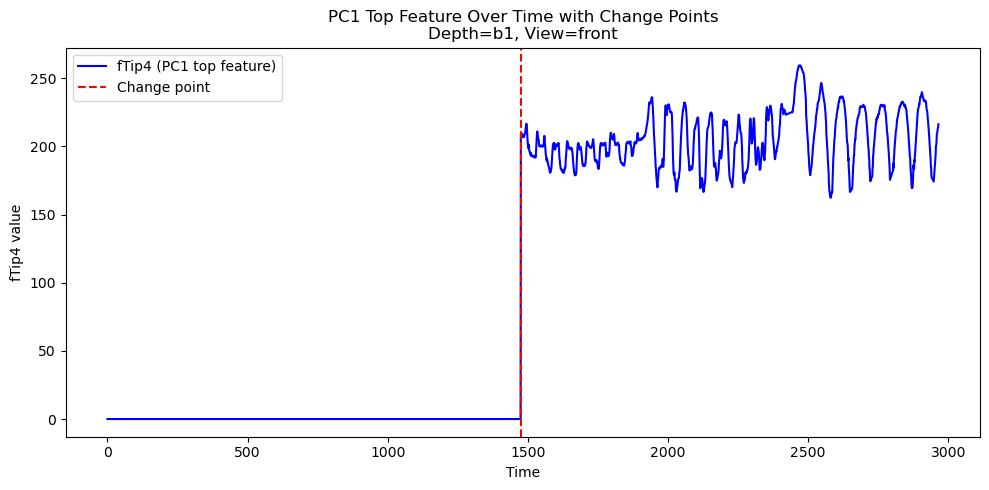

Change points (frame indices) for b1 front: [1475, 2966]

Processing depth=b1, view=side
  depth  view component feature_1  weight_1 feature_2  weight_2 feature_3  \
1    b1  side       PC1   fTip5.1  0.212569   fTip4.1  0.211958      MCP3   

   weight_3 feature_4  weight_4 feature_5  weight_5  
1  0.211653      MCP4  0.211527      MCP5  0.210936  
  depth  view component feature_1  weight_1 feature_2  weight_2 feature_3  \
1    b1  side       PC2   Elbow.1  0.572012     Elbow  0.570402    MCP5.1   

   weight_3 feature_4  weight_4 feature_5  weight_5  
1   0.23713    MCP4.1  0.220762   fTip2.1  0.211584  


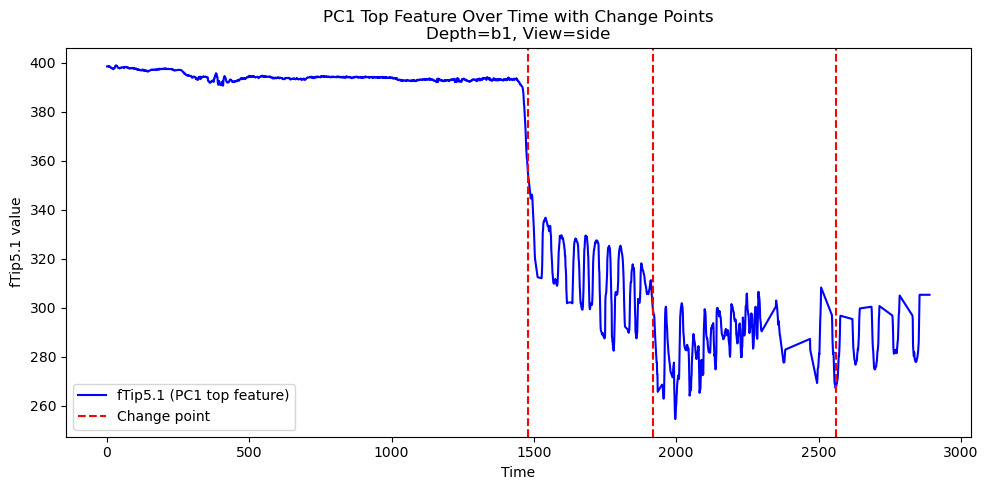

Change points (frame indices) for b1 side: [1480, 1920, 2560, 2891]

Processing depth=b2, view=front
  depth   view component   feature_1  weight_1 feature_2  weight_2 feature_3  \
2    b2  front       PC1  MidForeArm  0.226957     fTip1  0.224402     fTip3   

   weight_3 feature_4  weight_4 feature_5  weight_5  
2  0.223139     Elbow  0.222746   Elbow.1  0.222197  
  depth   view component feature_1  weight_1 feature_2  weight_2 feature_3  \
2    b2  front       PC2      MCP4  0.374799      MCP3  0.356401      MCP5   

   weight_3 feature_4  weight_4 feature_5  weight_5  
2  0.318857    MCP5.1 -0.275927    MCP4.1 -0.270987  


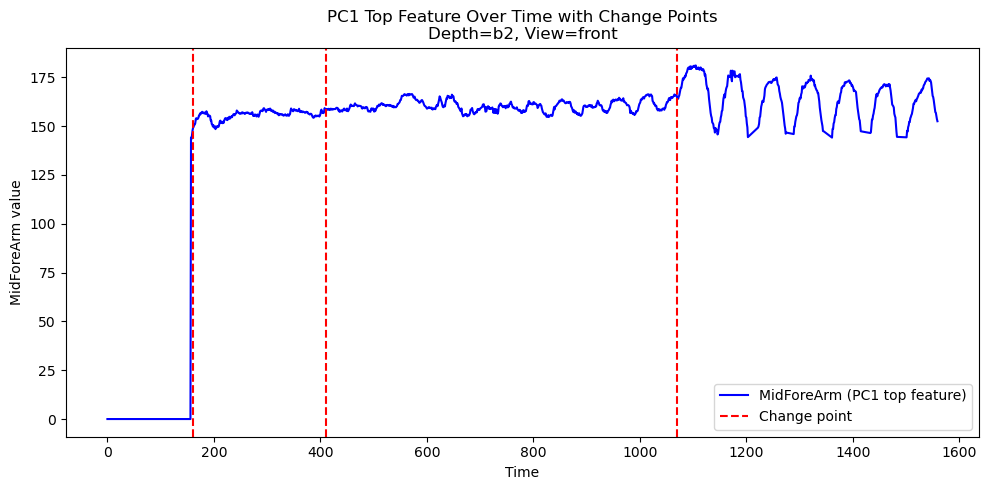

Change points (frame indices) for b2 front: [160, 410, 1070, 1560]

Processing depth=b2, view=side
  depth  view component feature_1  weight_1 feature_2  weight_2   feature_3  \
3    b2  side       PC1    MCP2.1  0.224023    MCP3.1  0.219706  PalmBase.1   

   weight_3 feature_4  weight_4 feature_5  weight_5  
3  0.218307    MCP4.1  0.215962     fTip3 -0.214224  
  depth  view component feature_1  weight_1   feature_2  weight_2 feature_3  \
3    b2  side       PC2   fTip2.1  0.273732  MidForeArm  0.257479  PalmBase   

   weight_3     feature_4  weight_4 feature_5  weight_5  
3   0.25717  MidForeArm.1  0.249081     fTip2  0.241333  


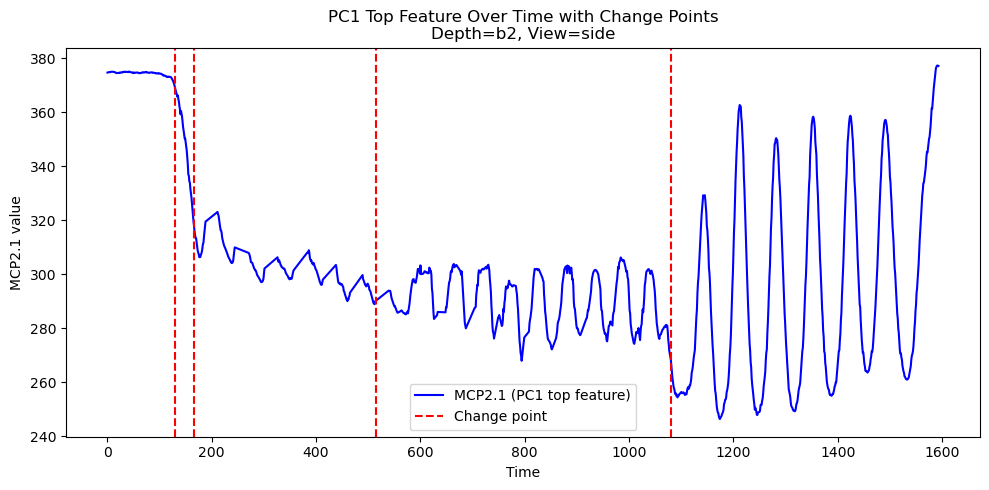

Change points (frame indices) for b2 side: [130, 165, 515, 1080, 1594]

Processing depth=b3, view=front
  depth   view component   feature_1  weight_1     feature_2  weight_2  \
4    b3  front       PC1  MidForeArm  0.251483  MidForeArm.1 -0.251136   

  feature_3  weight_3 feature_4  weight_4 feature_5  weight_5  
4    MCP3.1 -0.245257   Elbow.1 -0.239917    MCP4.1 -0.238521  
  depth   view component feature_1  weight_1 feature_2  weight_2 feature_3  \
4    b3  front       PC2     fTip2  0.386116     fTip1  0.361473      MCP2   

   weight_3 feature_4  weight_4 feature_5  weight_5  
4  0.342219      MCP1  0.318269      MCP3  0.308603  


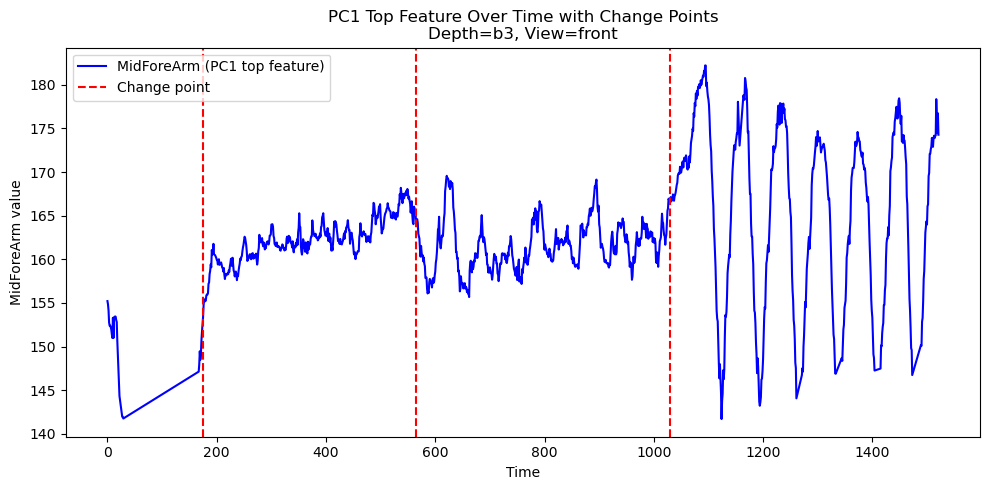

Change points (frame indices) for b3 front: [175, 565, 1030, 1522]

Processing depth=b3, view=side
  depth  view component feature_1  weight_1   feature_2  weight_2 feature_3  \
5    b3  side       PC1      MCP3  0.240235  PalmBase.1  0.238082     fTip2   

   weight_3 feature_4  weight_4 feature_5  weight_5  
5  0.235108      MCP4  0.234436    MCP3.1  0.231664  
  depth  view component feature_1  weight_1      feature_2  weight_2  \
5    b3  side       PC2     Elbow  0.391018  StablePoint.1  0.357682   

  feature_3  weight_3 feature_4  weight_4 feature_5  weight_5  
5      MCP1 -0.335731    MCP1.1 -0.325028     fTip4 -0.286594  


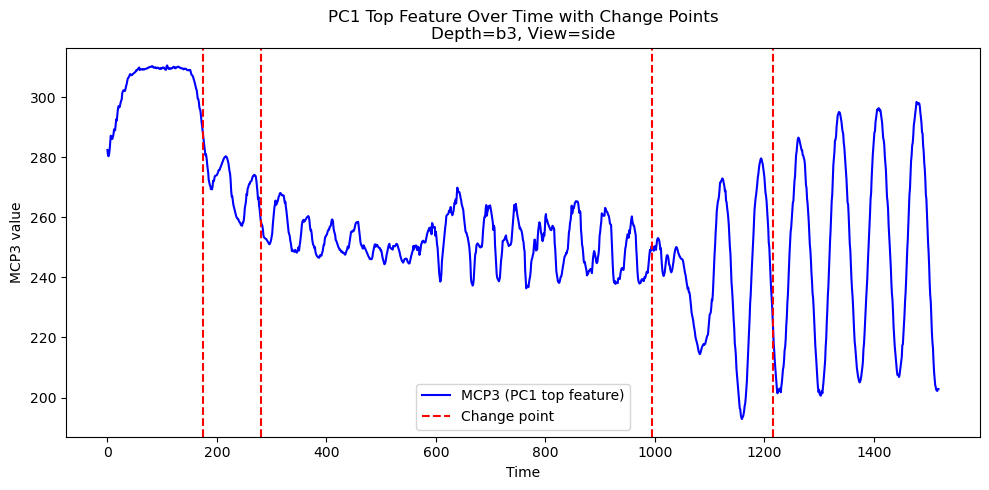

Change points (frame indices) for b3 side: [175, 280, 995, 1215, 1519]

Processing depth=c1, view=front
  depth   view component     feature_1  weight_1 feature_2  weight_2  \
6    c1  front       PC1  MidForeArm.1  0.246239    MCP3.1  0.245747   

    feature_3  weight_3 feature_4  weight_4 feature_5  weight_5  
6  MidForeArm -0.245362    MCP5.1  0.244842    MCP4.1  0.244416  
  depth   view component feature_1  weight_1 feature_2  weight_2 feature_3  \
6    c1  front       PC2    MCP1.1  0.362516     fTip4 -0.360672     fTip3   

   weight_3 feature_4  weight_4 feature_5  weight_5  
6 -0.355969     fTip5 -0.328707     Elbow -0.273007  


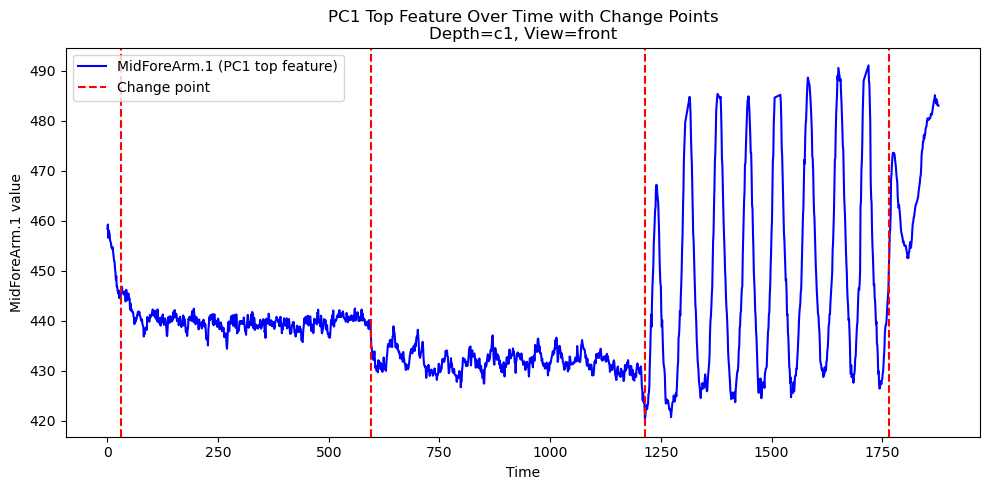

Change points (frame indices) for c1 front: [30, 595, 1215, 1765, 1878]

Processing depth=c1, view=side
  depth  view component feature_1  weight_1 feature_2  weight_2 feature_3  \
7    c1  side       PC1    MCP5.1  0.298353    MCP4.1  0.297239    MCP2.1   

   weight_3 feature_4  weight_4 feature_5  weight_5  
7  0.289358    MCP3.1  0.289122      MCP3  0.282804  
  depth  view component feature_1  weight_1 feature_2  weight_2 feature_3  \
7    c1  side       PC2    MCP1.1  0.360713      MCP1  0.356124     fTip3   

   weight_3 feature_4  weight_4 feature_5  weight_5  
7  0.355817   fTip3.1  0.352918     fTip2  0.243197  


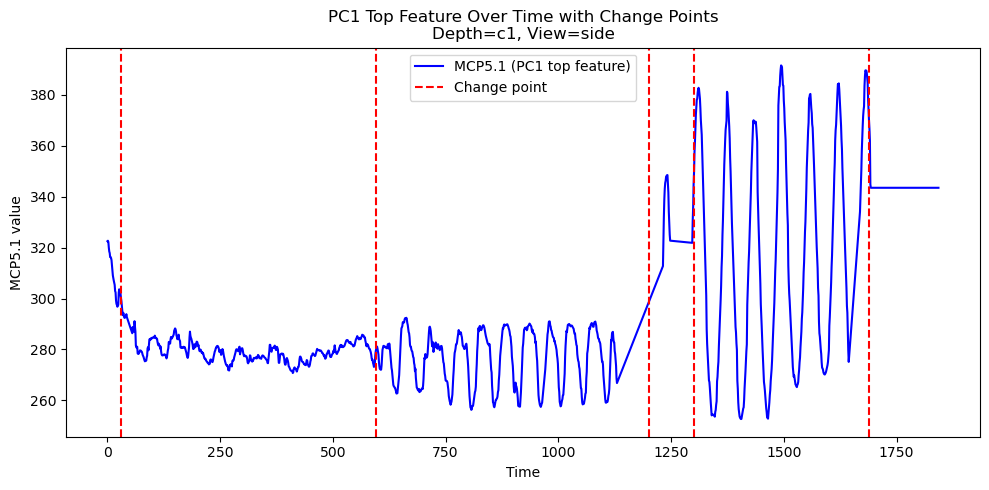

Change points (frame indices) for c1 side: [30, 595, 1200, 1300, 1690, 1844]

Processing depth=c2, view=front
  depth   view component feature_1  weight_1 feature_2  weight_2 feature_3  \
8    c2  front       PC1     fTip3  0.256594     fTip2   0.25579     fTip1   

   weight_3 feature_4  weight_4 feature_5  weight_5  
8  0.253695     fTip4  0.248329      MCP1  0.244868  
  depth   view component   feature_1  weight_1     feature_2  weight_2  \
8    c2  front       PC2  MidForeArm  0.322374  MidForeArm.1 -0.310988   

  feature_3  weight_3   feature_4  weight_4 feature_5  weight_5  
8  PalmBase  0.267842  PalmBase.1 -0.266989    MCP3.1  -0.24707  


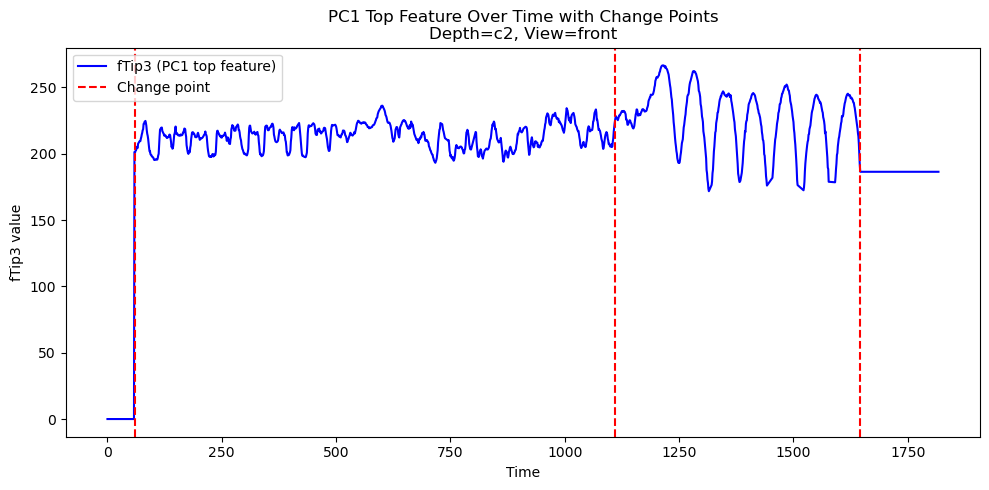

Change points (frame indices) for c2 front: [60, 1110, 1645, 1818]

Processing depth=c2, view=side
  depth  view component feature_1  weight_1 feature_2  weight_2 feature_3  \
9    c2  side       PC1      MCP3   0.25942      MCP4   0.25881    MCP2.1   

   weight_3 feature_4  weight_4 feature_5  weight_5  
9  0.255067    MCP3.1  0.253752      MCP5  0.252241  
  depth  view component feature_1  weight_1 feature_2  weight_2 feature_3  \
9    c2  side       PC2   fTip1.1  0.332915   fTip4.1  0.320534     fTip1   

   weight_3 feature_4  weight_4 feature_5  weight_5  
9  0.308615     fTip4  0.295726    MCP1.1  0.265884  


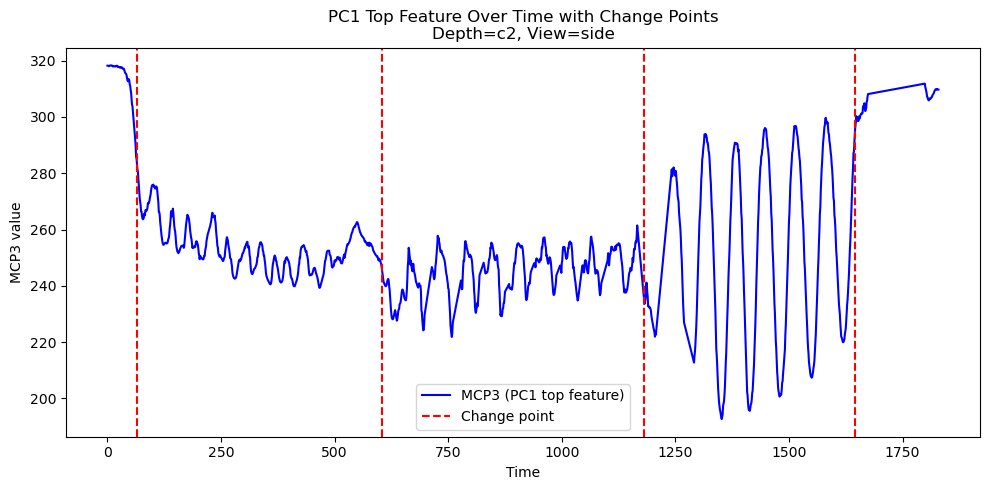

Change points (frame indices) for c2 side: [65, 605, 1180, 1645, 1830]

Processing depth=c3, view=front
   depth   view component feature_1  weight_1 feature_2  weight_2 feature_3  \
10    c3  front       PC1    MCP3.1  0.258955    MCP4.1  0.258536    MCP5.1   

    weight_3     feature_4  weight_4 feature_5  weight_5  
10  0.258401  MidForeArm.1  0.254775   fTip5.1  0.249617  
   depth   view component feature_1  weight_1 feature_2  weight_2 feature_3  \
10    c3  front       PC2     fTip4  0.385688     fTip3  0.385499     fTip5   

    weight_3 feature_4  weight_4 feature_5  weight_5  
10  0.355083     fTip2  0.314672   Elbow.1 -0.305206  


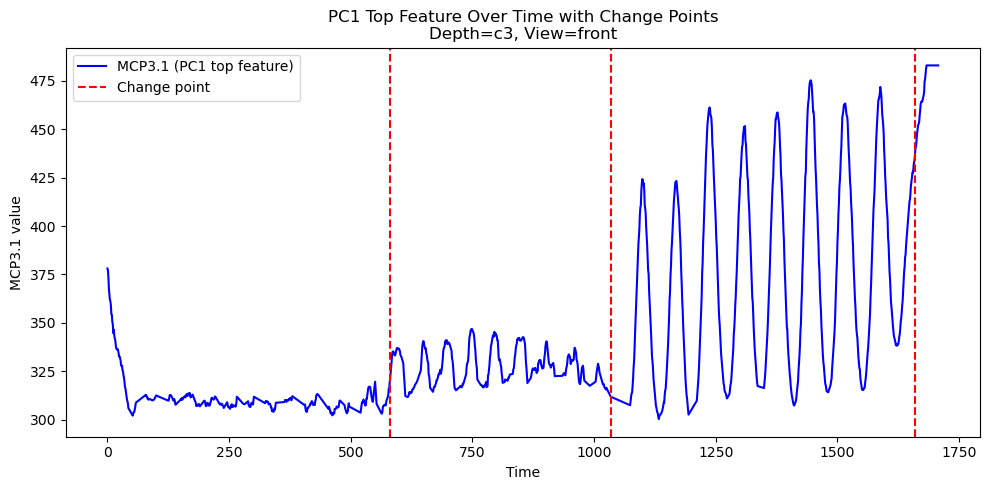

Change points (frame indices) for c3 front: [580, 1035, 1660, 1708]

Processing depth=c3, view=side
   depth  view component feature_1  weight_1 feature_2  weight_2   feature_3  \
11    c3  side       PC1      MCP3  0.243945      MCP4  0.242951  PalmBase.1   

    weight_3 feature_4  weight_4 feature_5  weight_5  
11  0.240856      MCP2  0.240267      MCP5  0.239753  
   depth  view component     feature_1  weight_1 feature_2  weight_2  \
11    c3  side       PC2  MidForeArm.1  0.400877    MCP1.1  0.399347   

   feature_3  weight_3   feature_4  weight_4 feature_5  weight_5  
11      MCP1  0.389444  MidForeArm  0.383977     fTip1  0.350945  


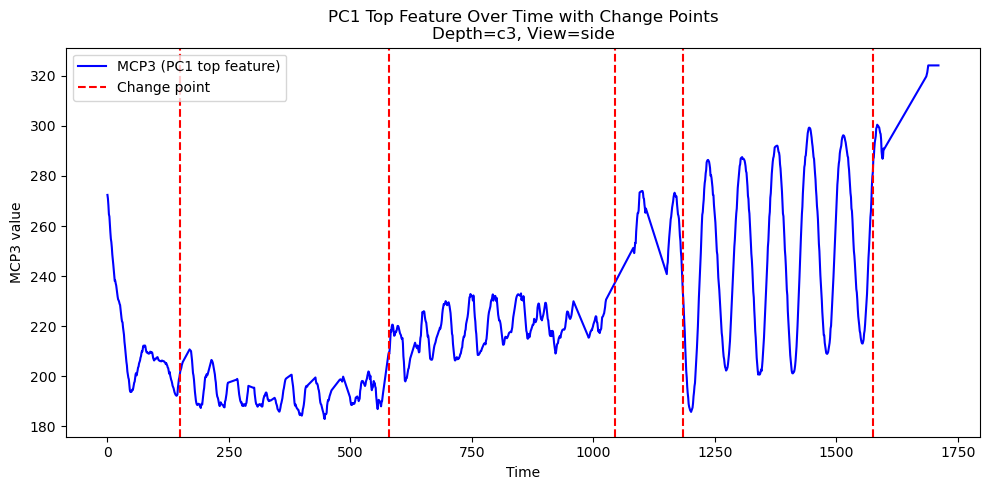

Change points (frame indices) for c3 side: [150, 580, 1045, 1185, 1575, 1711]

Processing depth=t1, view=front
   depth   view component feature_1  weight_1 feature_2  weight_2 feature_3  \
12    t1  front       PC1      MCP4  0.261754    MCP5.1 -0.258932      MCP5   

    weight_3 feature_4  weight_4 feature_5  weight_5  
12  0.258328    MCP4.1 -0.257781      MCP3  0.257516  
   depth   view component feature_1  weight_1 feature_2  weight_2 feature_3  \
12    t1  front       PC2     Elbow  0.312819   Elbow.1  0.306688      MCP1   

    weight_3 feature_4  weight_4 feature_5  weight_5  
12  0.296681    MCP1.1  0.296022  PalmBase  0.290505  


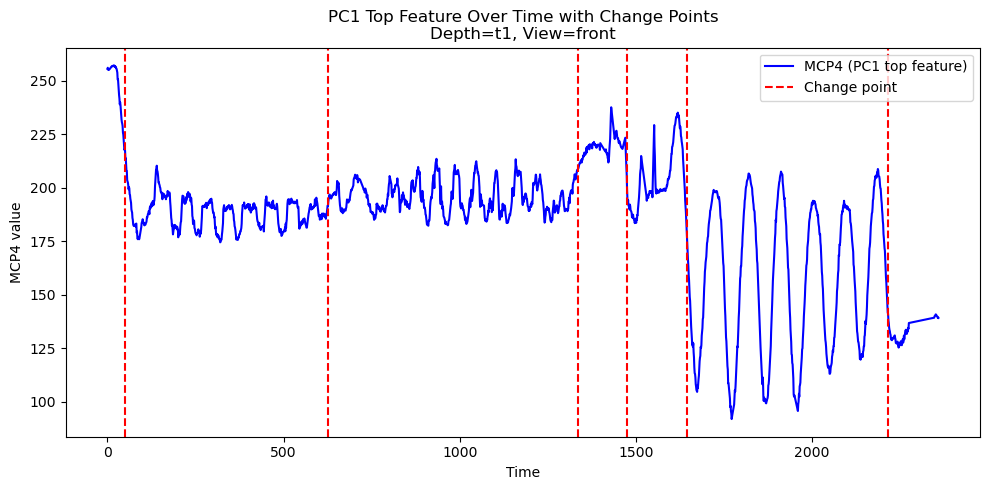

Change points (frame indices) for t1 front: [50, 625, 1335, 1475, 1645, 2215, 2360]

Processing depth=t1, view=side
   depth  view component feature_1  weight_1 feature_2  weight_2 feature_3  \
13    t1  side       PC1    MCP3.1  0.257223   fTip2.1  0.257215    MCP4.1   

    weight_3 feature_4  weight_4 feature_5  weight_5  
13  0.255956    MCP5.1  0.255838    MCP2.1   0.25578  
   depth  view component feature_1  weight_1 feature_2  weight_2 feature_3  \
13    t1  side       PC2   fTip3.1  0.335816     fTip3  0.327269    MCP1.1   

    weight_3 feature_4  weight_4 feature_5  weight_5  
13  0.310642      MCP1  0.308015  PalmBase  0.262065  


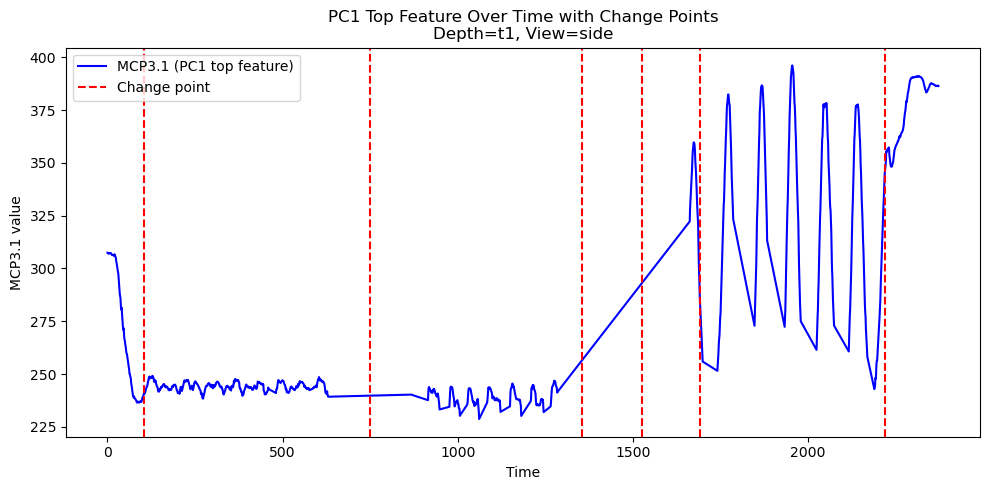

Change points (frame indices) for t1 side: [105, 750, 1355, 1525, 1690, 2220, 2373]

Processing depth=t2, view=front
   depth   view component feature_1  weight_1   feature_2  weight_2 feature_3  \
14    t2  front       PC1     fTip3  0.277743  MidForeArm  0.276903     fTip4   

    weight_3 feature_4  weight_4 feature_5  weight_5  
14  0.273602     fTip2  0.271938     fTip5  0.260038  
   depth   view component feature_1  weight_1 feature_2  weight_2 feature_3  \
14    t2  front       PC2   fTip4.1  0.307596   fTip5.1  0.306049   fTip3.1   

    weight_3 feature_4  weight_4 feature_5  weight_5  
14  0.305646   fTip2.1   0.30557   fTip1.1  0.290937  


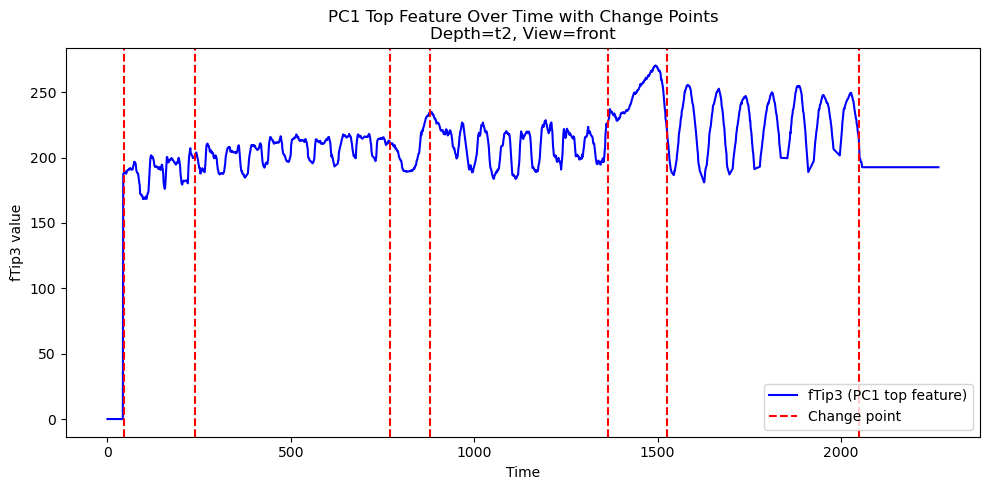

Change points (frame indices) for t2 front: [45, 240, 770, 880, 1365, 1525, 2050, 2267]

Processing depth=t2, view=side
   depth  view component   feature_1  weight_1 feature_2  weight_2 feature_3  \
15    t2  side       PC1  PalmBase.1  0.274476    MCP5.1  0.272307    MCP3.1   

    weight_3 feature_4  weight_4 feature_5  weight_5  
15   0.27194    MCP2.1  0.271686      MCP3  0.271669  
   depth  view component feature_1  weight_1 feature_2  weight_2 feature_3  \
15    t2  side       PC2     fTip4  0.336003     fTip3   0.32814   fTip3.1   

    weight_3 feature_4  weight_4 feature_5  weight_5  
15  0.322202   fTip4.1  0.320119    MCP1.1  0.310545  


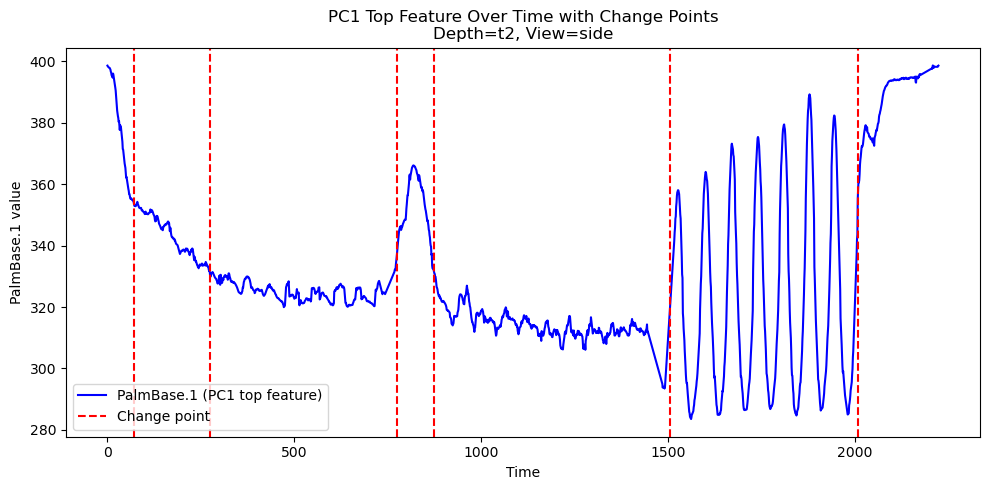

Change points (frame indices) for t2 side: [70, 275, 775, 875, 1505, 2010, 2225]

Processing depth=t3, view=front
   depth   view component   feature_1  weight_1 feature_2  weight_2 feature_3  \
16    t3  front       PC1  MidForeArm  0.251505     fTip3  0.248687     fTip4   

    weight_3 feature_4  weight_4 feature_5  weight_5  
16  0.243364     fTip2  0.240887     Elbow  0.240223  
   depth   view component feature_1  weight_1 feature_2  weight_2 feature_3  \
16    t3  front       PC2   fTip2.1  0.302017   fTip3.1  0.299458   fTip5.1   

    weight_3 feature_4  weight_4 feature_5  weight_5  
16  0.288014   fTip4.1  0.287069      MCP3 -0.279862  


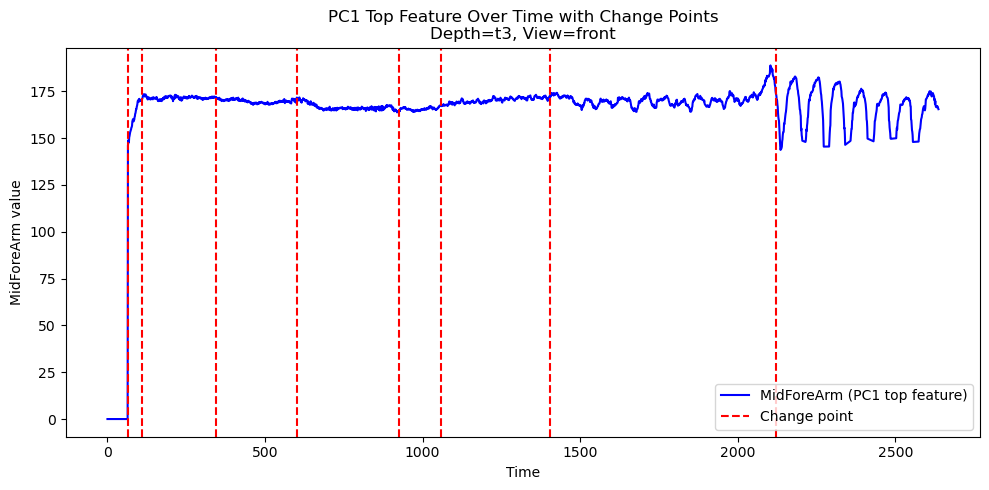

Change points (frame indices) for t3 front: [65, 110, 345, 600, 925, 1060, 1405, 2120, 2638]

Processing depth=t3, view=side
   depth  view component feature_1  weight_1   feature_2  weight_2 feature_3  \
17    t3  side       PC1    MCP2.1  0.263976  PalmBase.1  0.263734      MCP3   

    weight_3 feature_4  weight_4 feature_5  weight_5  
17  0.261732    MCP3.1  0.261249    MCP4.1  0.259082  
   depth  view component feature_1  weight_1 feature_2  weight_2 feature_3  \
17    t3  side       PC2   fTip1.1    0.3034   fTip5.1  0.293512     fTip5   

    weight_3 feature_4  weight_4 feature_5  weight_5  
17  0.291163     fTip2  0.289282     fTip1  0.278652  


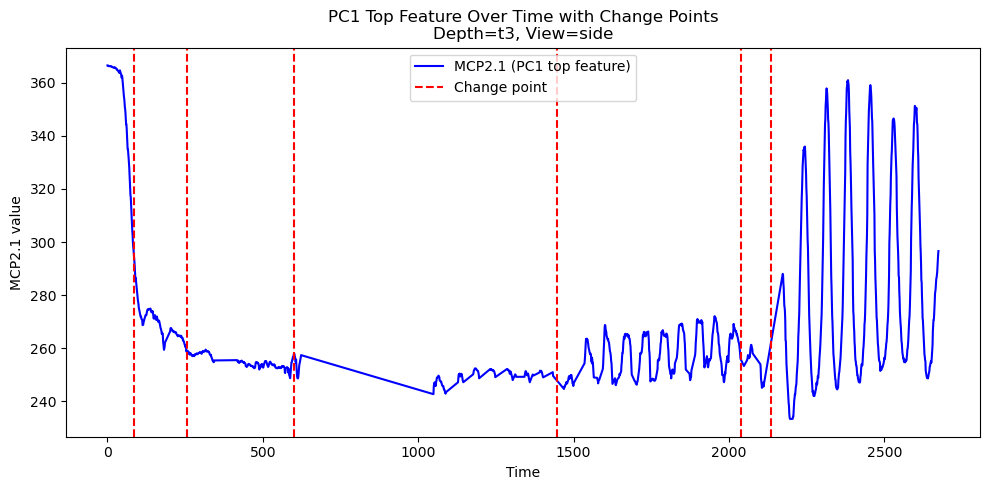

Change points (frame indices) for t3 side: [85, 255, 600, 1445, 2040, 2135, 2675]


In [430]:
results_list = []

# Parameters for ruptures
model = "rbf"
penalty_value = 30  # Adjust as needed

for depth in depths:
    for view in views:
        print(f"\nProcessing depth={depth}, view={view}")

        # Get top PC1 and PC2 features
        top_feature_pc1 = get_top_feature(top5_pc1_df, depth, view, 'PC1')
        top_feature_pc2 = get_top_feature(top5_pc2_df, depth, view, 'PC2')

        if top_feature_pc1 is None or top_feature_pc2 is None:
            print(f"Skipping {depth} {view} - missing top features")
            continue

        df_key = depth + ('f' if view == 'front' else 's')
        if df_key not in dataframes:
            print(f"Data for {df_key} not found in dataframes.")
            continue

        df = dataframes[df_key]

        if top_feature_pc1 not in df.columns or top_feature_pc2 not in df.columns:
            print(f"Features {top_feature_pc1} or {top_feature_pc2} not found in dataframe for {df_key}")
            continue

        # Extract data
        x = df[top_feature_pc1].to_numpy()
        y = df[top_feature_pc2].to_numpy()
        t = np.arange(len(x))

        # Stack for ruptures input
        signal = np.column_stack((x, y))  # shape (n_samples, 2)

        # Run RBF change point detection
        algo = rpt.Pelt(model=model).fit(signal)
        change_points = algo.predict(pen=penalty_value)



        # Inside the nested loop after change_points are computed
        plt.figure(figsize=(10, 5))
        plt.plot(t, x, label=f"{top_feature_pc1} (PC1 top feature)", color='blue')
        for cp in change_points[:-1]:  # Skip the last point if it's just the end of signal
            plt.axvline(x=cp, color='red', linestyle='--', label='Change point' if cp == change_points[0] else "")
        plt.xlabel("Time")
        plt.ylabel(f"{top_feature_pc1} value")
        plt.title(f"PC1 Top Feature Over Time with Change Points\nDepth={depth}, View={view}")
        plt.legend()
        plt.tight_layout()
        plt.show()




        # Print results
        print(f"Change points (frame indices) for {depth} {view}: {change_points}")

        # Create a dictionary for storing change point results
        dic_indices = {
            "depth": depth,
            "view": view,
            "component": "indices"
        }

        # Save the top features and their change points
        dic_indices["feature_1"] = top_feature_pc1
        dic_indices["feature_2"] = top_feature_pc2
        dic_indices["change_points"] = change_points

        # Assuming you're collecting multiple such dictionaries into a list
        results_list.append(dic_indices)





## Visualize indices df

In [431]:
df_indices = pd.DataFrame(results_list)

df_indices 

depth   view component     feature_1     feature_2  \
0     b1  front   indices         fTip4          MCP5   
1     b1   side   indices       fTip5.1       Elbow.1   
2     b2  front   indices    MidForeArm          MCP4   
3     b2   side   indices        MCP2.1       fTip2.1   
4     b3  front   indices    MidForeArm         fTip2   
5     b3   side   indices          MCP3         Elbow   
6     c1  front   indices  MidForeArm.1        MCP1.1   
7     c1   side   indices        MCP5.1        MCP1.1   
8     c2  front   indices         fTip3    MidForeArm   
9     c2   side   indices          MCP3       fTip1.1   
10    c3  front   indices        MCP3.1         fTip4   
11    c3   side   indices          MCP3  MidForeArm.1   
12    t1  front   indices          MCP4         Elbow   
13    t1   side   indices        MCP3.1       fTip3.1   
14    t2  front   indices         fTip3       fTip4.1   
15    t2   side   indices    PalmBase.1         fTip4   
16    t3  front   indices    MidForeArm       fTip2.1   
17    t3   side   indices        MCP2.1       fTip1.1   

                                       change_points  
0                                       [1475, 2966]  
1                           [1480, 1920, 2560, 2891]  
2                             [160, 410, 1070, 1560]  
3                        [130, 165, 515, 1080, 1594]  
4                             [175, 565, 1030, 1522]  
5                        [175, 280, 995, 1215, 1519]  
6                        [30, 595, 1215, 1765, 1878]  
7                  [30, 595, 1200, 1300, 1690, 1844]  
8                             [60, 1110, 1645, 1818]  
9                        [65, 605, 1180, 1645, 1830]  
10                           [580, 1035, 1660, 1708]  
11                [150, 580, 1045, 1185, 1575, 1711]  
12           [50, 625, 1335, 1475, 1645, 2215, 2360]  
13          [105, 750, 1355, 1525, 1690, 2220, 2373]  
14       [45, 240, 770, 880, 1365, 1525, 2050, 2267]  
15             [70, 275, 775, 875, 1505, 2010, 2225]  
16  [65, 110, 345, 600, 925, 1060, 1405, 2120, 2638]  
17            [85, 255, 600, 1445, 2040, 2135, 2675]

## Averaging close datapoints

In [432]:
# Create an empty list to hold averaged points for each row
averaged_points_list = []

# Loop through each row in the DataFrame
for _, row in df_indices.iterrows():
    change_points = row['change_points']
    averaged_points = average_close_indices(change_points, threshold=100)
    averaged_points_list.append(averaged_points)

# Assign the results as a new column in the DataFrame
df_indices['averaged_points'] = averaged_points_list

## Creating movement df for armEF

In [433]:
df_movements = pd.DataFrame(columns=['dataset', 'view', 'arm_EF', 'hand_OC', 'hand_PS'])

for _, row in df_indices.iterrows():
    all_indices = row['averaged_points']
    movement = 'arm_EF'

    # skipping trials if they are incomplete (defined above)
    if row['depth'] in skip_trails:
        continue

    if len(all_indices) == 1:
        continue

    dif = all_indices[-2] - all_indices[-1]
    print(f'the difference is {dif}')

    if np.abs(all_indices[-2] - all_indices[-1]) < 500:
        if len(all_indices) >= 3:
            start = all_indices[-3]
            end = all_indices[-2]
        else: 
            start = all_indices[-2]
            end = all_indices[-1]
    else:
        start = all_indices[-2]
        end = all_indices[-1]
        

    df_movements = pd.concat([
    df_movements,
    pd.DataFrame([{
        'dataset': row['depth'],        # <- use `row` to access data from df_indices
        'view': row['view'],
        'arm_EF': (start, end),
        'hand_OC': (0,0),
        'hand_PS': (0,0)
    }])
], ignore_index=True)

print(df_movements)

the difference is -1491
the difference is -331
the difference is -490
the difference is -514
the difference is -492
the difference is -304
the difference is -113
the difference is -154
the difference is -173
the difference is -185
the difference is -649
the difference is -136
the difference is -145
the difference is -153
the difference is -217
the difference is -215
the difference is -518
the difference is -588
   dataset   view        arm_EF hand_OC hand_PS
0       b1  front  (1475, 2966)  (0, 0)  (0, 0)
1       b1   side  (1920, 2560)  (0, 0)  (0, 0)
2       b2  front   (410, 1070)  (0, 0)  (0, 0)
3       b2   side  (1080, 1594)  (0, 0)  (0, 0)
4       b3  front   (565, 1030)  (0, 0)  (0, 0)
5       b3   side   (995, 1215)  (0, 0)  (0, 0)
6       c1  front  (1215, 1765)  (0, 0)  (0, 0)
7       c1   side  (1250, 1690)  (0, 0)  (0, 0)
8       c2  front  (1110, 1645)  (0, 0)  (0, 0)
9       c2   side  (1180, 1645)  (0, 0)  (0, 0)
10      c3  front  (1035, 1684)  (0, 0)  (0, 0)
11      c

## Visualizing armEF segmentation

  depth   view component feature_1  weight_1 feature_2  weight_2 feature_3  \
0    b1  front       PC1     fTip4  0.240195     fTip3  0.240193     fTip2   

   weight_3 feature_4  weight_4 feature_5  weight_5  
0  0.239258     fTip1  0.238349      MCP1  0.236926  
  depth  view component feature_1  weight_1 feature_2  weight_2 feature_3  \
1    b1  side       PC1   fTip5.1  0.212569   fTip4.1  0.211958      MCP3   

   weight_3 feature_4  weight_4 feature_5  weight_5  
1  0.211653      MCP4  0.211527      MCP5  0.210936  
  depth   view component   feature_1  weight_1 feature_2  weight_2 feature_3  \
2    b2  front       PC1  MidForeArm  0.226957     fTip1  0.224402     fTip3   

   weight_3 feature_4  weight_4 feature_5  weight_5  
2  0.223139     Elbow  0.222746   Elbow.1  0.222197  
  depth  view component feature_1  weight_1 feature_2  weight_2   feature_3  \
3    b2  side       PC1    MCP2.1  0.224023    MCP3.1  0.219706  PalmBase.1   

   weight_3 feature_4  weight_4 feature_5  w

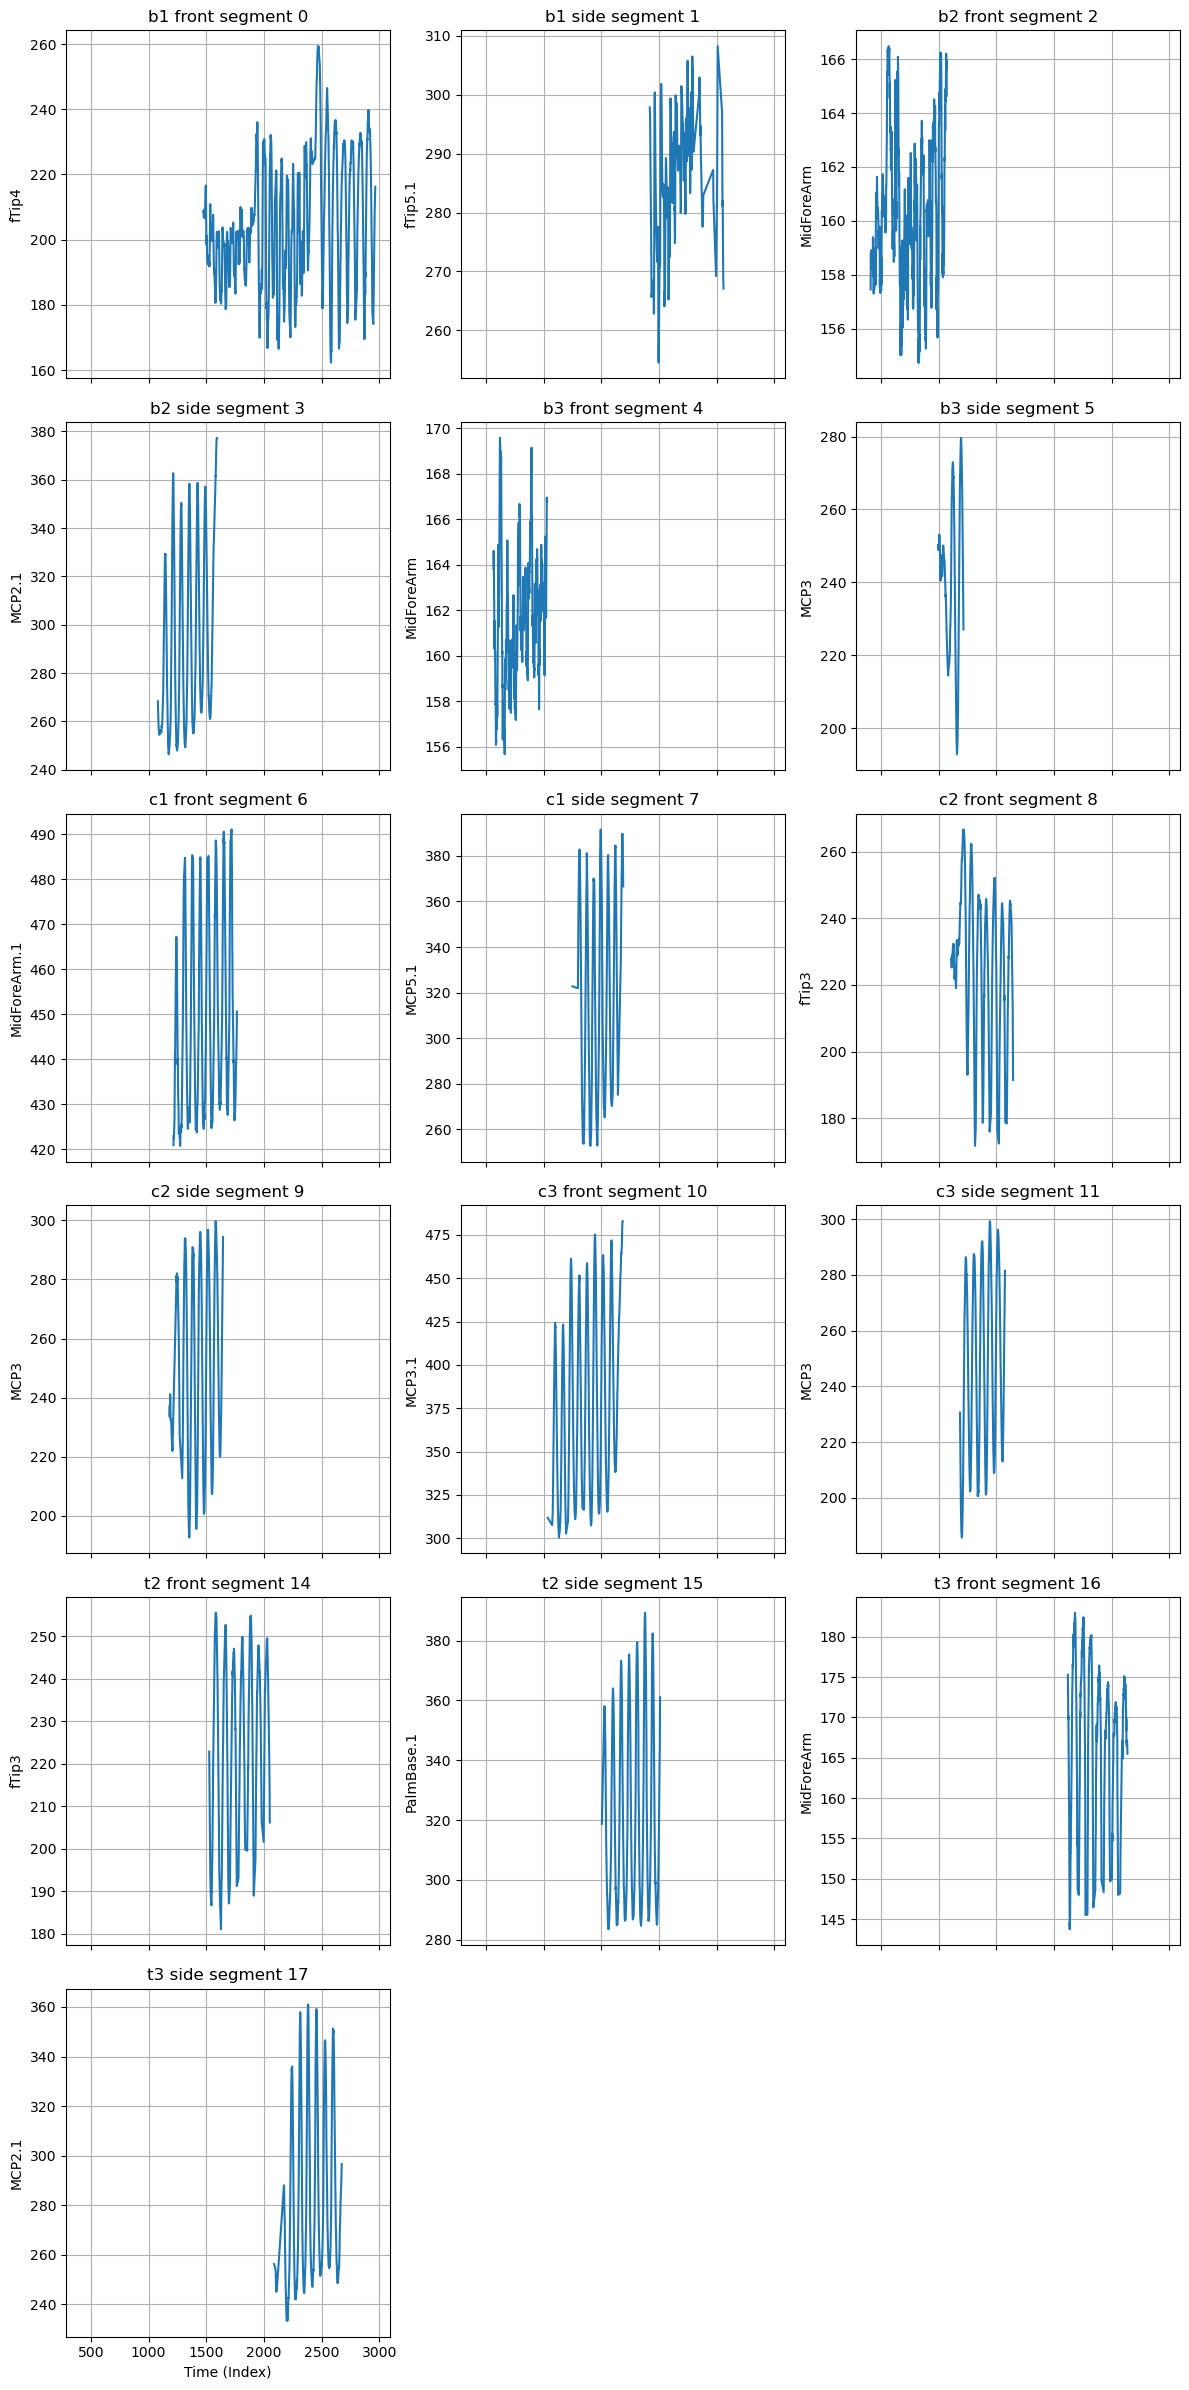

In [434]:
# Filter out rows where depth is 't1'
filtered_movements = df_movements[df_movements['dataset'] != 't1']
n = len(filtered_movements)
cols = 3
rows = math.ceil(n / cols)

fig, axs = plt.subplots(rows, cols, figsize=(12, 4 * rows), sharex=True)
axs = axs.flatten()

for idx, (i, row) in enumerate(filtered_movements.iterrows()):
    depth = row['dataset']
    view_type = row['view']
    start, end = row['arm_EF']

    df_key = depth + ('f' if view_type == 'front' else 's')
    if df_key not in dataframes:
        print(f"Data for {df_key} not found.")
        continue

    df = dataframes[df_key]

    top_feature = get_top_feature(top5_pc1_df, depth, view_type, 'PC1')
    if top_feature not in df.columns:
        print(f"{top_feature} not found in data for {df_key}")
        continue

    segment = df[top_feature].iloc[start:end+1]

    ax = axs[idx]
    ax.plot(segment.index, segment.values)
    ax.set_title(f"{depth} {view_type} segment {i}")
    ax.set_ylabel(f"{top_feature}")
    ax.grid(True)

# Hide any unused subplots
for i in range(n, len(axs)):
    fig.delaxes(axs[i])

plt.xlabel("Time (Index)")
plt.tight_layout()
plt.show()


## Run PCA on only handOC and handPS time 

In [435]:
# New containers for start-segment PCA data
pca1_start_rows = []
pca2_start_rows = []
explained_start_rows = []
top5_start_pc1_rows = []
top5_start_pc2_rows = []

view_map = {"front": "f", "side": "s"}

for _, row in df_movements.iterrows():
    depth = row["dataset"]
    view = row["view"]

    # Skip if missing
    if pd.isna(depth) or pd.isna(view):
        continue

    # Map "front"/"side" to "f"/"s"
    view_letter = view_map.get(view.lower())

    if view_letter is None:
        print(f"Unrecognized view: {view}")
        continue

    base = f"{depth}{view_letter}"

    if base not in dataframes:
        print(f"Skipping {base} - not found in dataframes.")
        continue

    df_full = dataframes[base]
    


    # Get starting segment: from 0 to first change point of armEF so it only includes handOC and armPS
    change_points = row['arm_EF']  
    if not change_points or len(change_points) == 0:
        continue  # Skip if no change points
    
    first_cp = int(change_points[0])
    df_segment = df_full.iloc[:first_cp]

    # Trim initial zeros like before
    df_trimmed = trim_initial_zeros(df_segment)

    # Run PCA on start segment
    X_pca, explained_ratio, explained_raw, components = run_PCA(df_segment, None, base, "start")

    used_columns = df_segment.loc[:, ~df_segment.columns.str.contains(r'\.2')]
    stds = used_columns.std(axis=0)
    final_cols = used_columns.loc[:, stds != 0].columns.tolist()

    pc1 = components[0]
    pc2 = components[1]

    # Build PCA1 row
    row_pc1 = {"depth": depth, "view": view_letter, "component": "PC1"}
    row_pc2 = {"depth": depth, "view": view_letter, "component": "PC2"}
    
    for feat, w1, w2 in zip(final_cols, pc1, pc2):
        row_pc1[feat] = w1
        row_pc2[feat] = w2

    pca1_start_rows.append(row_pc1)
    pca2_start_rows.append(row_pc2)

    explained_start_rows.append({
        "depth": depth,
        "view": view_letter,
        "PC1_var": explained_ratio[0],
        "PC2_var": explained_ratio[1]
    })

    # Top 5 for PC1
    contributions = list(zip(final_cols, pc1))
    contributions.sort(key=lambda x: abs(x[1]), reverse=True)
    top5 = contributions[:5]

    top5_dict = {
        "depth": depth,
        "view": view,
        "component": "PC1"
    }
    for idx, (feat, weight) in enumerate(top5):
        top5_dict[f"feature_{idx+1}"] = feat
        top5_dict[f"weight_{idx+1}"] = weight
    top5_start_pc1_rows.append(top5_dict)


    # Top 5 for PC2
    contributions_pc2 = list(zip(final_cols, pc2))
    contributions_pc2.sort(key=lambda x: abs(x[1]), reverse=True)
    top5_pc2 = contributions_pc2[:5]

    top5_dict_pc2 = {
        "depth": depth,
        "view": view,
        "component": "PC2"
    }
    for idx, (feat, weight) in enumerate(top5_pc2):
        top5_dict_pc2[f"feature_{idx+1}"] = feat
        top5_dict_pc2[f"weight_{idx+1}"] = weight
    top5_start_pc2_rows.append(top5_dict_pc2)


# At the end: convert to dataframes
pca1_start_df = pd.DataFrame(pca1_start_rows)
pca2_start_df = pd.DataFrame(pca2_start_rows)
explained_start_df = pd.DataFrame(explained_start_rows)
top5_start_pc1_df = pd.DataFrame(top5_start_pc1_rows)
top5_start_pc2_df = pd.DataFrame(top5_start_pc2_rows)



In [90]:
top5_start_pc1_df

depth   view component     feature_1  weight_1     feature_2  weight_2  \
0     b1  front       PC1        MCP4.1  0.285107        MCP5.1  0.283261   
1     b1   side       PC1        MCP3.1  0.261067        MCP4.1  0.260727   
2     b2  front       PC1  MidForeArm.1  0.218299    PalmBase.1  0.217230   
3     b2   side       PC1  MidForeArm.1  0.250556        MCP2.1  0.250305   
4     b3  front       PC1          MCP2  0.315122       fTip5.1 -0.312210   
5     b3   side       PC1          MCP4  0.294266          MCP5  0.288715   
6     c1  front       PC1    PalmBase.1  0.265863      PalmBase -0.265418   
7     c1   side       PC1       fTip1.1  0.259997        MCP2.1  0.259522   
8     c2  front       PC1        MCP1.1  0.214995          MCP5  0.213767   
9     c2   side       PC1        MCP2.1  0.220064        MCP5.1  0.219996   
10    c3  front       PC1        MCP1.1  0.218667      PalmBase  0.217235   
11    c3   side       PC1        MCP2.1  0.224382        MCP5.1  0.224173   
12    t2  front       PC1      PalmBase  0.236575          MCP1  0.235947   
13    t2   side       PC1         fTip4  0.263123         fTip3  0.262222   
14    t3  front       PC1          MCP5  0.225735          MCP4  0.224261   
15    t3   side       PC1         fTip3  0.239972  MidForeArm.1 -0.238638   

       feature_3  weight_3 feature_4  weight_4     feature_5  weight_5  
0        fTip5.1  0.277543    MCP3.1  0.268088  MidForeArm.1  0.264720  
1         MCP5.1  0.258208      MCP4  0.256631        MCP2.1  0.253560  
2         MCP2.1  0.216981   Elbow.1  0.216181          MCP4  0.215776  
3     PalmBase.1  0.249920    MCP3.1  0.248845        MCP4.1  0.246636  
4         MCP4.1 -0.302603      MCP3  0.285905        MCP3.1 -0.259391  
5          fTip5  0.280769      MCP3  0.278954        MCP4.1  0.275206  
6         MCP2.1  0.264205    MCP3.1  0.263780        MCP4.1  0.261699  
7   MidForeArm.1  0.256361   Elbow.1  0.254618        MCP3.1  0.250514  
8     MidForeArm -0.211422    MCP2.1  0.209099       fTip5.1  0.209053  
9         MCP3.1  0.219856    MCP4.1  0.219701    PalmBase.1  0.218045  
10          MCP4  0.217006   fTip5.1  0.216892    PalmBase.1  0.216859  
11        MCP3.1  0.223987    MCP4.1  0.223488    PalmBase.1  0.223041  
12          MCP3  0.235897      MCP4  0.233854         fTip4  0.233740  
13         fTip2  0.255400     fTip5  0.252924          MCP3  0.235265  
14         fTip2  0.223756     fTip4  0.223361    MidForeArm -0.223088  
15      PalmBase  0.236226   Elbow.1 -0.231813    PalmBase.1  0.230945

## Runs Ruptures on the handOC and handPS


Processing depth=b1, view=front
  depth   view component feature_1  weight_1 feature_2  weight_2 feature_3  \
0    b1  front       PC1      MCP2  0.333795      MCP5  0.331982      MCP3   

   weight_3   feature_4  weight_4 feature_5  weight_5  
0  0.324599  PalmBase.1   0.31093    MCP2.1  0.310142  
  depth   view component feature_1  weight_1 feature_2  weight_2 feature_3  \
0    b1  front       PC2     Elbow  0.349417   Elbow.1  0.345666     fTip5   

   weight_3 feature_4  weight_4 feature_5  weight_5  
0  0.343334   fTip5.1  0.335636    MCP3.1 -0.265178  


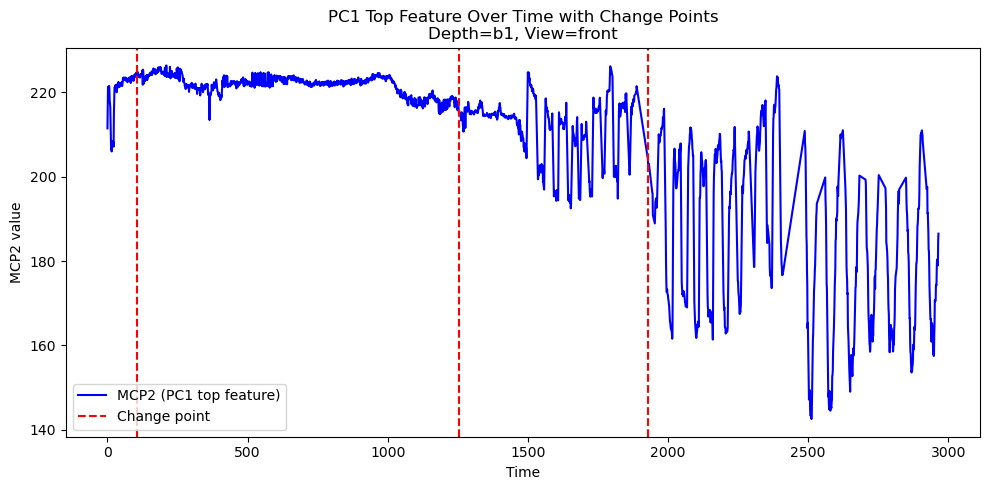

Change points (frame indices) for b1 front: [105, 1255, 1930, 2966]

Processing depth=b1, view=side
  depth  view component feature_1  weight_1 feature_2  weight_2 feature_3  \
1    b1  side       PC1    MCP3.1   0.21424    MCP4.1  0.214188    MCP2.1   

   weight_3 feature_4  weight_4 feature_5  weight_5  
1  0.214009    MCP5.1  0.213703      MCP2  0.213401  
  depth  view component      feature_1  weight_1    feature_2  weight_2  \
1    b1  side       PC2  StablePoint.1  0.690922  StablePoint  0.690555   

  feature_3  weight_3   feature_4  weight_4     feature_5  weight_5  
1  PalmBase -0.126992  PalmBase.1 -0.126589  MidForeArm.1  -0.04451  


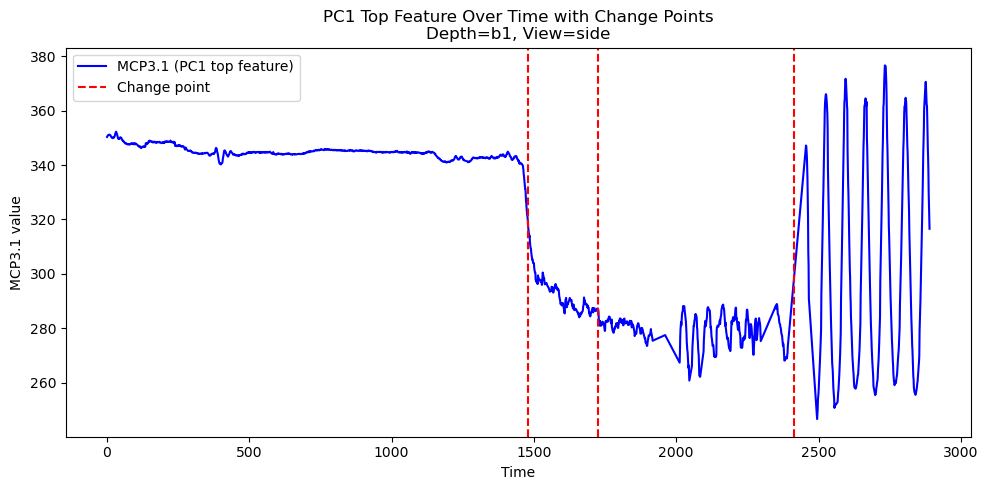

Change points (frame indices) for b1 side: [1480, 1725, 2415, 2891]

Processing depth=b2, view=front
  depth   view component   feature_1  weight_1 feature_2  weight_2 feature_3  \
2    b2  front       PC1  MidForeArm  0.204097     Elbow  0.203611   Elbow.1   

   weight_3     feature_4  weight_4 feature_5  weight_5  
2   0.20349  MidForeArm.1  0.203168     fTip4  0.202599  
  depth   view component feature_1  weight_1 feature_2  weight_2 feature_3  \
2    b2  front       PC2      MCP2  0.396162      MCP3  0.378619      MCP4   

   weight_3 feature_4  weight_4    feature_5  weight_5  
2  0.349386      MCP5  0.299693  StablePoint -0.269178  


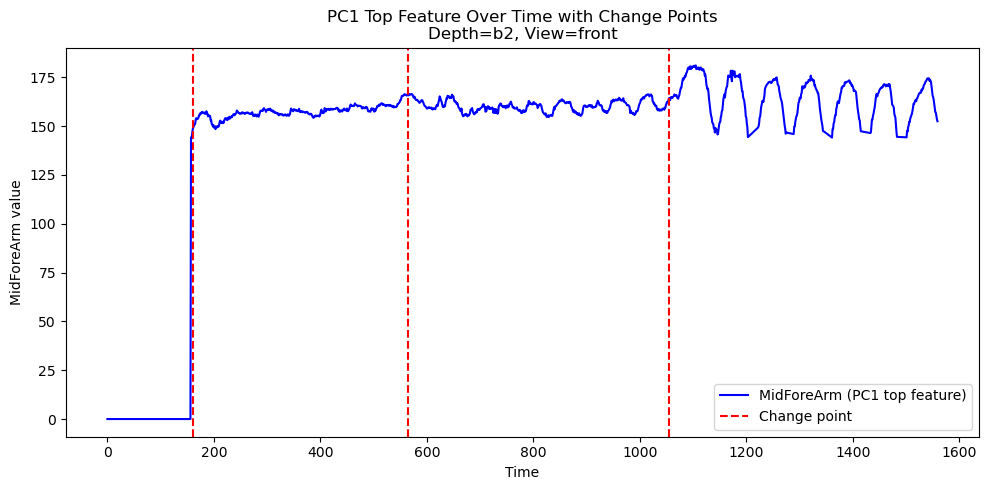

Change points (frame indices) for b2 front: [160, 565, 1055, 1560]

Processing depth=b2, view=side
  depth  view component feature_1  weight_1 feature_2  weight_2 feature_3  \
3    b2  side       PC1    MCP2.1  0.218845    MCP3.1  0.217613    MCP4.1   

   weight_3 feature_4  weight_4   feature_5  weight_5  
3  0.216632    MCP5.1  0.215533  PalmBase.1   0.21315  
  depth  view component feature_1  weight_1     feature_2  weight_2 feature_3  \
3    b2  side       PC2   fTip2.1  0.350756  MidForeArm.1  0.326378   fTip5.1   

   weight_3 feature_4  weight_4 feature_5  weight_5  
3  0.312527     Elbow -0.296019     fTip2  0.288269  


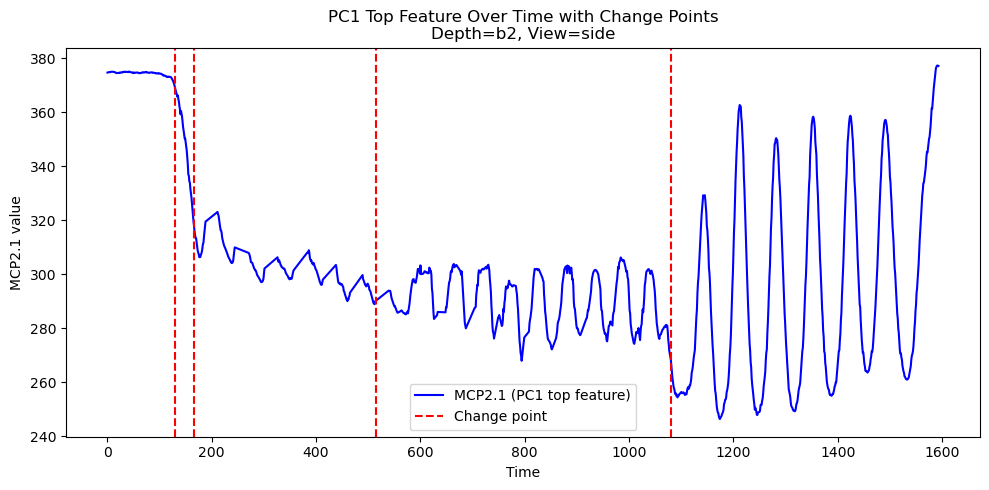

Change points (frame indices) for b2 side: [130, 165, 515, 1080, 1594]

Processing depth=b3, view=front
  depth   view component     feature_1  weight_1   feature_2  weight_2  \
4    b3  front       PC1  MidForeArm.1   0.25081  MidForeArm -0.248906   

  feature_3  weight_3 feature_4  weight_4 feature_5  weight_5  
4   fTip5.1  0.247706    MCP3.1  0.247201    MCP2.1  0.245797  
  depth   view component feature_1  weight_1 feature_2  weight_2 feature_3  \
4    b3  front       PC2     fTip4  0.391481     fTip3  0.386183     fTip5   

   weight_3 feature_4  weight_4 feature_5  weight_5  
4   0.36594     fTip2   0.34303     fTip1 -0.283557  


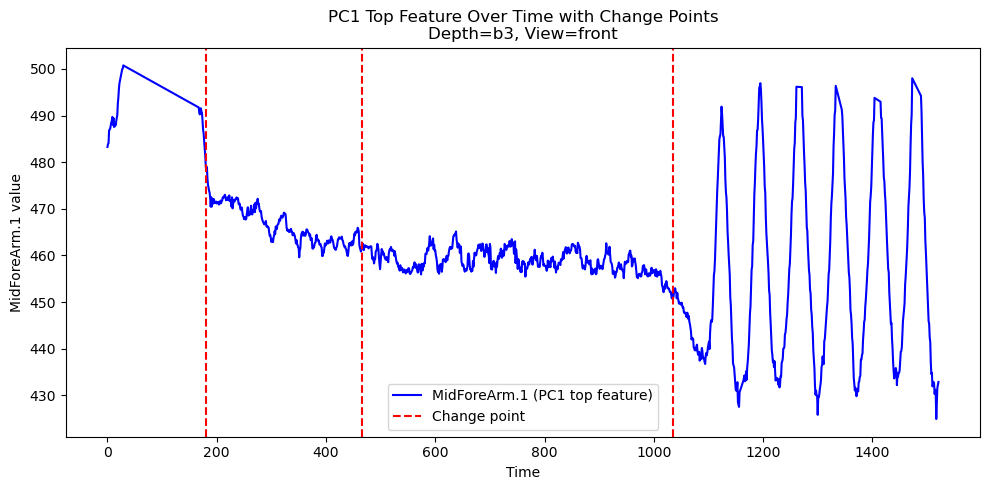

Change points (frame indices) for b3 front: [180, 465, 1035, 1522]

Processing depth=b3, view=side
  depth  view component   feature_1  weight_1 feature_2  weight_2 feature_3  \
5    b3  side       PC1  PalmBase.1  0.236697      MCP3  0.235127     fTip2   

   weight_3 feature_4  weight_4 feature_5  weight_5  
5  0.234166    MCP3.1  0.230722   fTip5.1  0.230545  
  depth  view component feature_1  weight_1 feature_2  weight_2 feature_3  \
5    b3  side       PC2     fTip1  0.453649   fTip1.1  0.384206      MCP2   

   weight_3   feature_4  weight_4    feature_5  weight_5  
5  0.317015  MidForeArm  0.314684  StablePoint  0.266135  


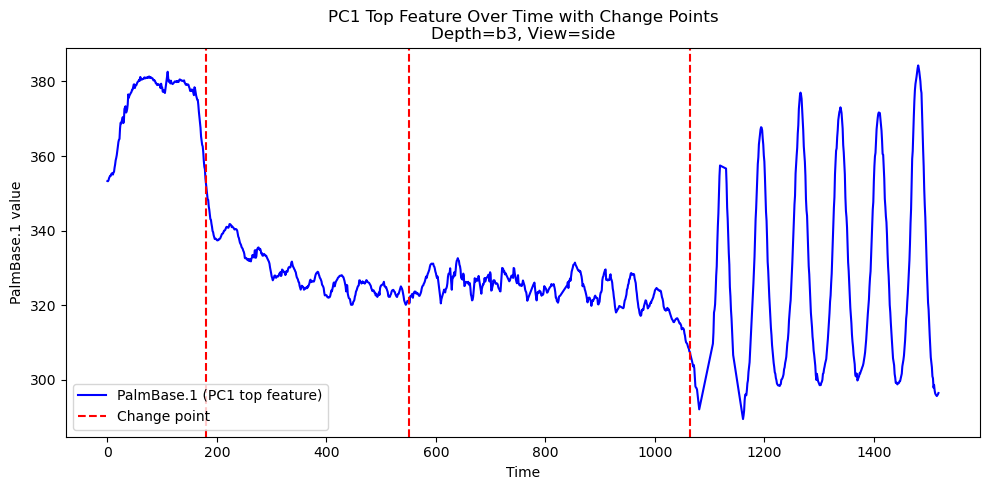

Change points (frame indices) for b3 side: [180, 550, 1065, 1519]

Processing depth=c1, view=front
  depth   view component feature_1  weight_1 feature_2  weight_2 feature_3  \
6    c1  front       PC1   fTip5.1  0.284924   fTip2.1  0.278049    MCP2.1   

   weight_3 feature_4  weight_4     feature_5  weight_5  
6  0.271789   fTip4.1   0.27141  MidForeArm.1  0.269984  
  depth   view component feature_1  weight_1 feature_2  weight_2 feature_3  \
6    c1  front       PC2     fTip4  0.361603     fTip3  0.343472     fTip5   

   weight_3 feature_4  weight_4 feature_5  weight_5  
6   0.34217      MCP5  0.328136     Elbow  0.320605  


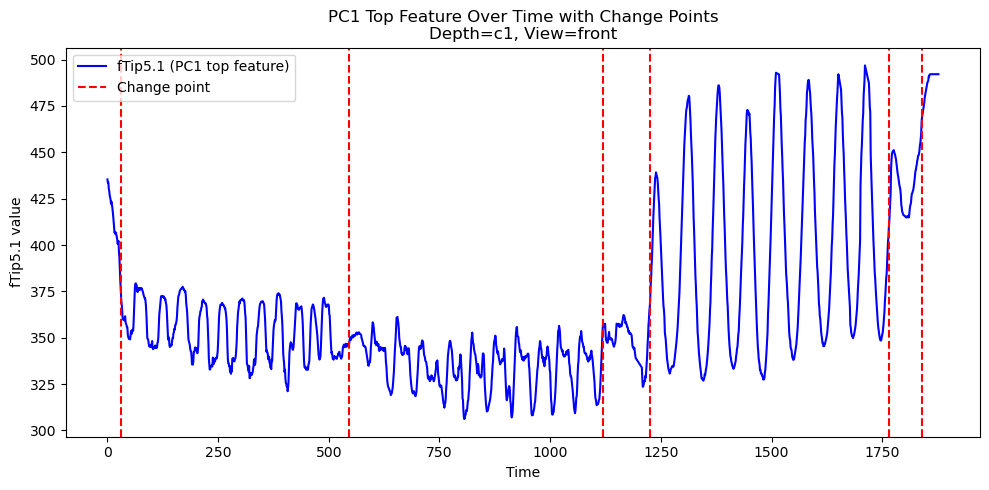

Change points (frame indices) for c1 front: [30, 545, 1120, 1225, 1765, 1840, 1878]

Processing depth=c1, view=side
  depth  view component feature_1  weight_1 feature_2  weight_2 feature_3  \
7    c1  side       PC1      MCP3  0.273847      MCP4  0.271267    MCP2.1   

   weight_3 feature_4  weight_4 feature_5  weight_5  
7  0.268447    MCP3.1  0.263182    MCP5.1  0.260272  
  depth  view component feature_1  weight_1 feature_2  weight_2 feature_3  \
7    c1  side       PC2     fTip2  0.325673   fTip2.1  0.317139     fTip4   

   weight_3 feature_4  weight_4 feature_5  weight_5  
7  0.259532     fTip3  0.256107   fTip4.1  0.241665  


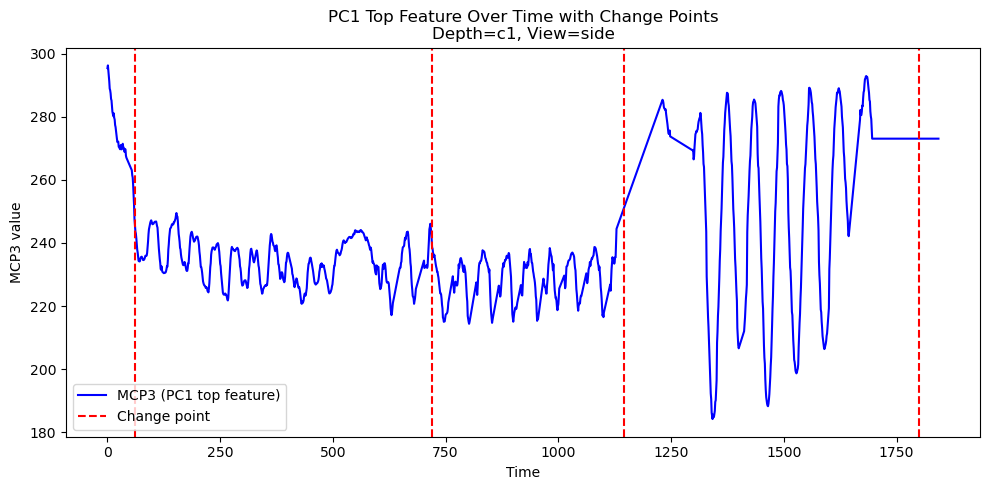

Change points (frame indices) for c1 side: [60, 720, 1145, 1800, 1844]

Processing depth=c2, view=front
  depth   view component feature_1  weight_1 feature_2  weight_2 feature_3  \
8    c2  front       PC1     fTip3  0.224914     fTip2   0.22282     fTip1   

   weight_3 feature_4  weight_4 feature_5  weight_5  
8  0.220762     fTip4  0.219233   fTip4.1  0.218341  
  depth   view component feature_1  weight_1 feature_2  weight_2 feature_3  \
8    c2  front       PC2     Elbow  0.361215    MCP3.1 -0.319312    MCP4.1   

   weight_3   feature_4  weight_4 feature_5  weight_5  
8 -0.314998  PalmBase.1 -0.294016   Elbow.1 -0.283175  


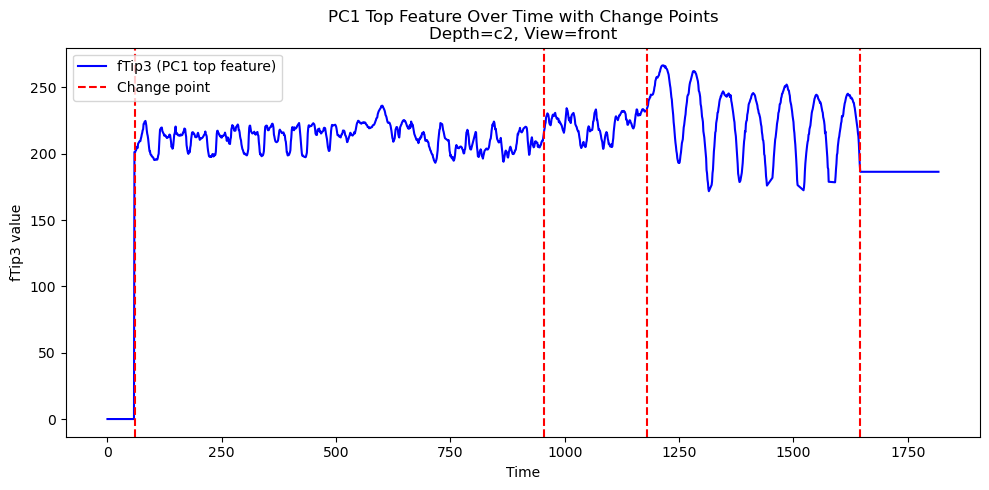

Change points (frame indices) for c2 front: [60, 955, 1180, 1645, 1818]

Processing depth=c2, view=side
  depth  view component feature_1  weight_1 feature_2  weight_2   feature_3  \
9    c2  side       PC1    MCP2.1  0.231523    MCP3.1  0.229459  PalmBase.1   

   weight_3 feature_4  weight_4 feature_5  weight_5  
9  0.227353    MCP4.1  0.226222    MCP5.1  0.226165  
  depth  view component feature_1  weight_1 feature_2  weight_2   feature_3  \
9    c2  side       PC2   fTip2.1  0.487283     fTip2  0.470844  MidForeArm   

   weight_3     feature_4  weight_4    feature_5  weight_5  
9  0.399929  MidForeArm.1  0.315349  StablePoint  0.300659  


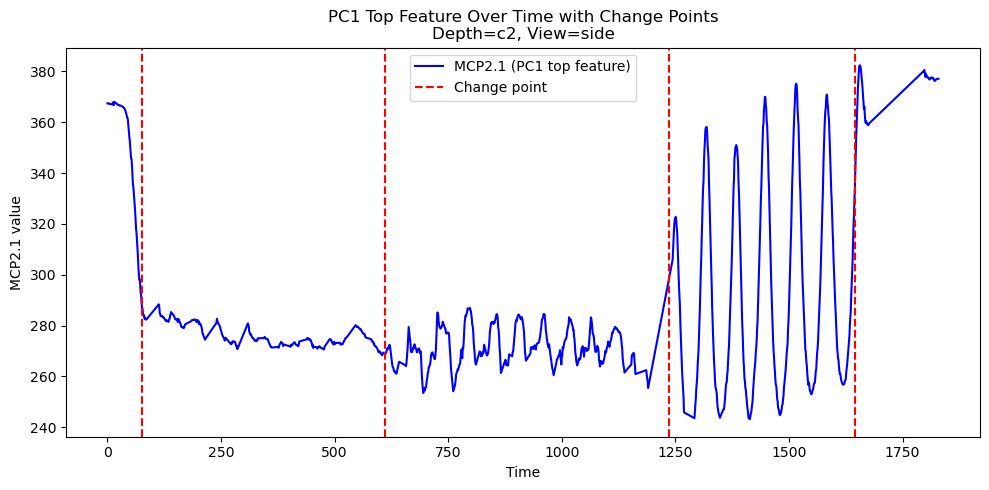

Change points (frame indices) for c2 side: [75, 610, 1235, 1645, 1830]

Processing depth=c3, view=front
   depth   view component feature_1  weight_1 feature_2  weight_2 feature_3  \
10    c3  front       PC1   fTip5.1  0.287312    MCP4.1    0.2767   fTip4.1   

    weight_3 feature_4  weight_4 feature_5  weight_5  
10  0.271076    MCP5.1  0.270997    MCP2.1  0.265661  
   depth   view component feature_1  weight_1 feature_2  weight_2 feature_3  \
10    c3  front       PC2   fTip1.1   0.33996     fTip2  0.339479      MCP2   

    weight_3 feature_4  weight_4   feature_5  weight_5  
10   0.32072      MCP3   0.30876  PalmBase.1 -0.265364  


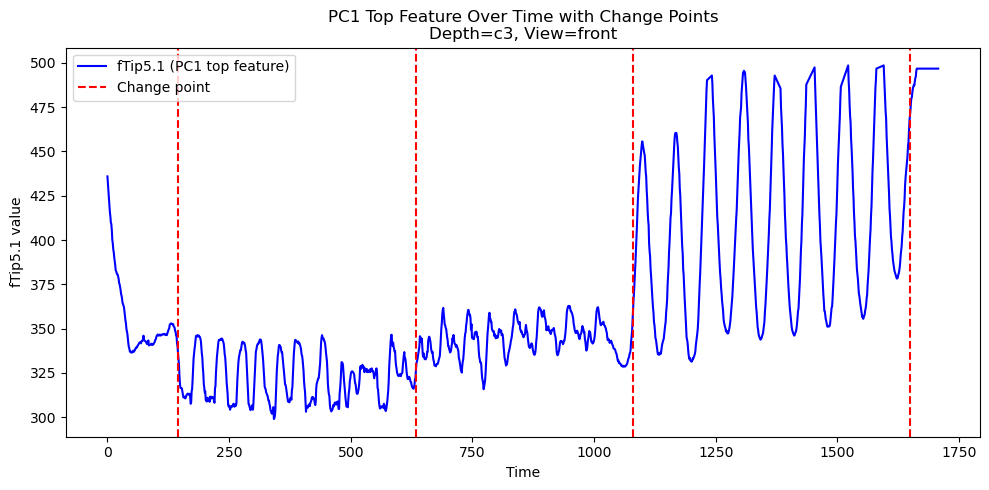

Change points (frame indices) for c3 front: [145, 635, 1080, 1650, 1708]

Processing depth=c3, view=side
   depth  view component feature_1  weight_1 feature_2  weight_2 feature_3  \
11    c3  side       PC1      MCP3  0.257612      MCP4  0.255887      MCP5   

    weight_3 feature_4  weight_4 feature_5  weight_5  
11  0.250329    MCP3.1  0.249919    MCP5.1  0.249654  
   depth  view component     feature_1  weight_1   feature_2  weight_2  \
11    c3  side       PC2  MidForeArm.1   0.38465  MidForeArm  0.383587   

   feature_3  weight_3 feature_4  weight_4 feature_5  weight_5  
11   fTip1.1  0.382729     fTip1  0.381175    MCP1.1  0.372374  


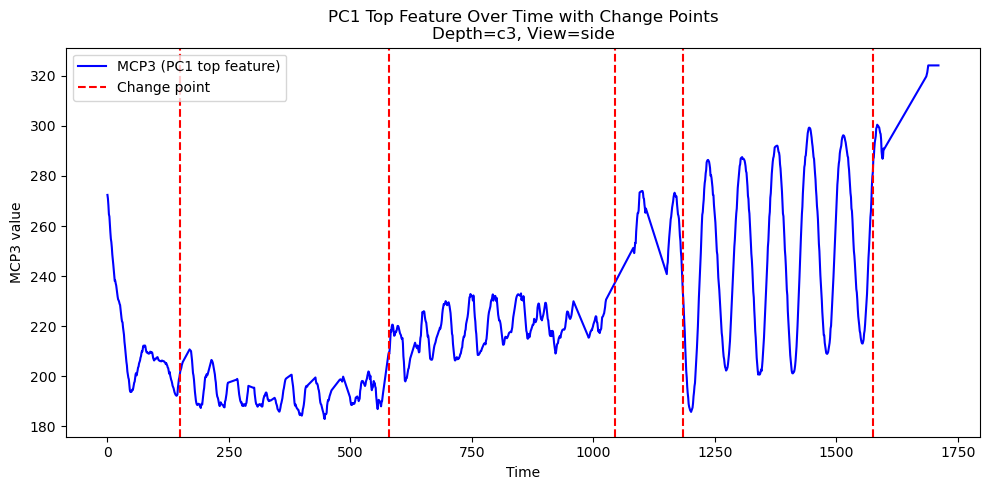

Change points (frame indices) for c3 side: [150, 580, 1045, 1185, 1575, 1711]

Processing depth=t1, view=front
   depth   view component feature_1  weight_1 feature_2  weight_2 feature_3  \
12    t1  front       PC1   fTip1.1  0.233791    MCP3.1  0.233277    MCP2.1   

    weight_3 feature_4  weight_4 feature_5  weight_5  
12   0.23157     Elbow -0.227301   Elbow.1 -0.227244  
   depth   view component feature_1  weight_1 feature_2  weight_2 feature_3  \
12    t1  front       PC2   fTip2.1  0.294548   fTip3.1  0.291268   fTip4.1   

    weight_3 feature_4  weight_4 feature_5  weight_5  
12  0.281205     fTip3  0.267106     fTip2  0.265457  


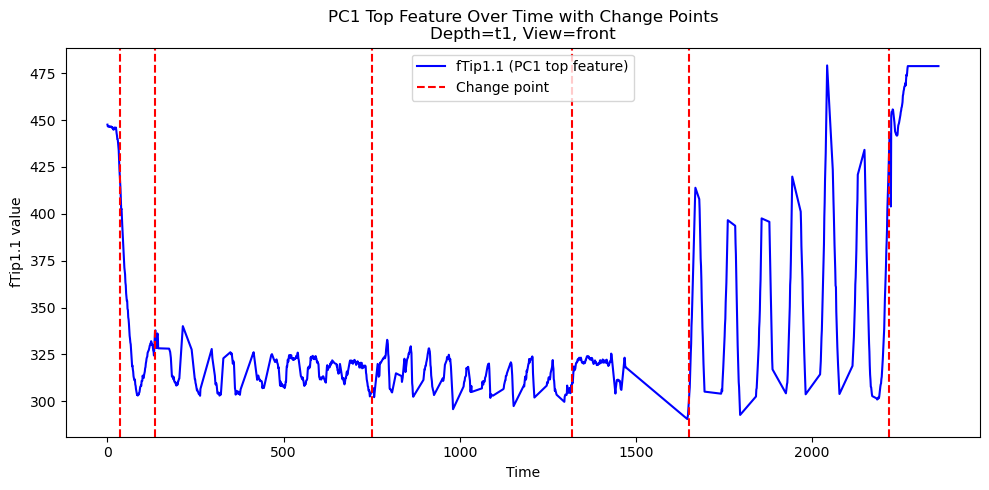

Change points (frame indices) for t1 front: [35, 135, 750, 1320, 1650, 2220, 2360]

Processing depth=t1, view=side
   depth  view component feature_1  weight_1 feature_2  weight_2 feature_3  \
13    t1  side       PC1     fTip2  0.260385     fTip4  0.256103      MCP3   

    weight_3 feature_4  weight_4 feature_5  weight_5  
13 -0.255802  PalmBase  0.254833      MCP2 -0.249738  
   depth  view component feature_1  weight_1 feature_2  weight_2 feature_3  \
13    t1  side       PC2    MCP4.1  0.277846    MCP3.1  0.276303    MCP5.1   

    weight_3 feature_4  weight_4   feature_5  weight_5  
13  0.274674    MCP2.1  0.274187  PalmBase.1  0.254649  


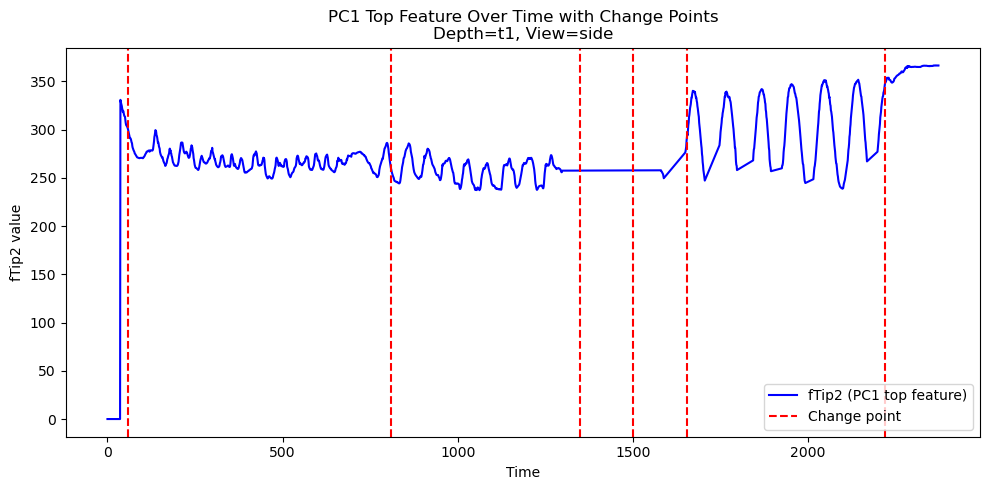

Change points (frame indices) for t1 side: [60, 810, 1350, 1500, 1655, 2220, 2373]

Processing depth=t2, view=front
   depth   view component   feature_1  weight_1 feature_2  weight_2 feature_3  \
14    t2  front       PC1  MidForeArm  0.254339     Elbow  0.253005     fTip2   

    weight_3 feature_4  weight_4 feature_5  weight_5  
14  0.251722     fTip3   0.24959   Elbow.1  0.248933  
   depth   view component feature_1  weight_1 feature_2  weight_2 feature_3  \
14    t2  front       PC2    MCP2.1  0.348121    MCP4.1  0.340408    MCP3.1   

    weight_3 feature_4  weight_4   feature_5  weight_5  
14  0.338762    MCP5.1  0.331595  PalmBase.1  0.324521  


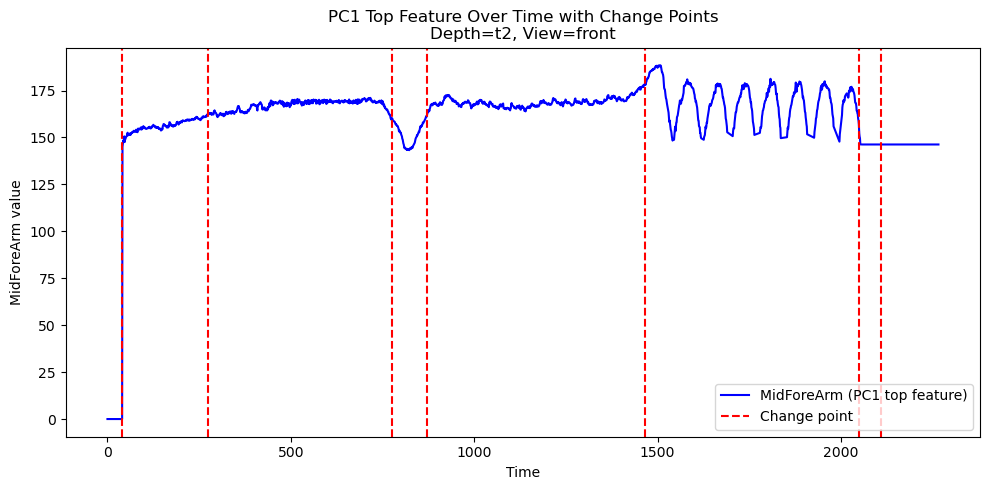

Change points (frame indices) for t2 front: [40, 275, 775, 870, 1465, 2050, 2110, 2267]

Processing depth=t2, view=side
   depth  view component feature_1  weight_1 feature_2  weight_2 feature_3  \
15    t2  side       PC1    MCP3.1  0.254838    MCP2.1  0.254185    MCP5.1   

    weight_3 feature_4  weight_4   feature_5  weight_5  
15  0.252886    MCP4.1  0.251466  PalmBase.1  0.249389  
   depth  view component feature_1  weight_1 feature_2  weight_2 feature_3  \
15    t2  side       PC2   fTip4.1   0.30077   fTip3.1   0.30073   fTip5.1   

    weight_3 feature_4  weight_4   feature_5  weight_5  
15  0.278815     fTip1  0.269766  MidForeArm  0.264507  


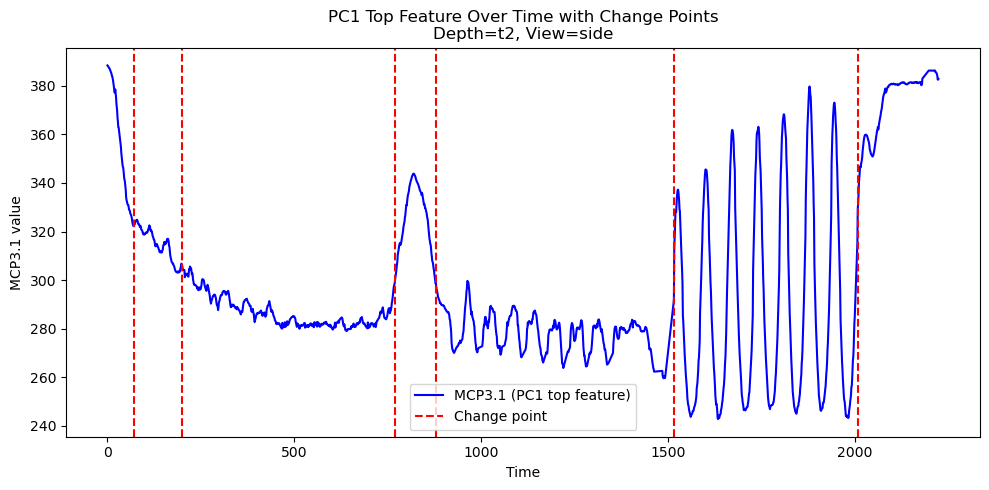

Change points (frame indices) for t2 side: [70, 200, 770, 880, 1515, 2010, 2225]

Processing depth=t3, view=front
   depth   view component   feature_1  weight_1 feature_2  weight_2 feature_3  \
16    t3  front       PC1  MidForeArm  0.226817     fTip3  0.223813     Elbow   

    weight_3 feature_4  weight_4     feature_5  weight_5  
16  0.223715   Elbow.1   0.22261  MidForeArm.1  0.219661  
   depth   view component feature_1  weight_1 feature_2  weight_2 feature_3  \
16    t3  front       PC2      MCP3  0.504436     fTip1  0.450818      MCP2   

    weight_3 feature_4  weight_4 feature_5  weight_5  
16  0.448629      MCP4  0.379019   fTip1.1  0.225352  


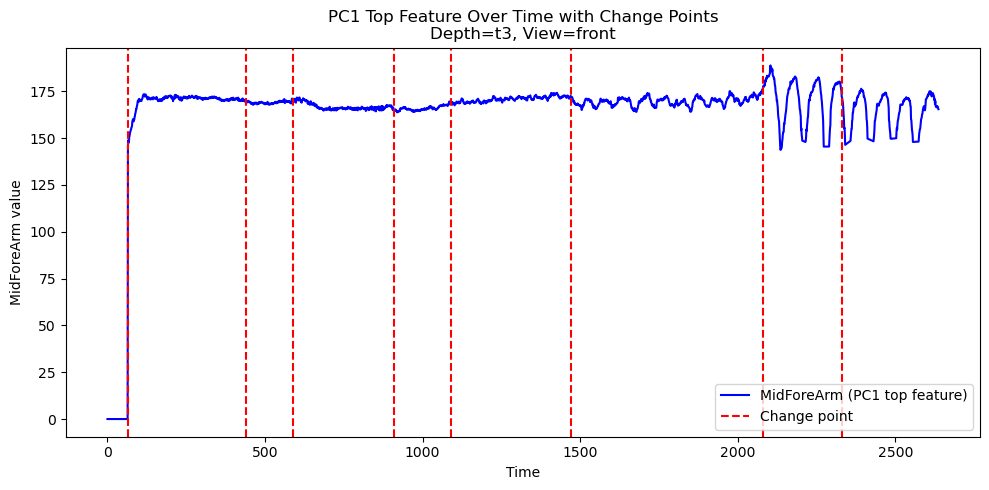

Change points (frame indices) for t3 front: [65, 440, 590, 910, 1090, 1470, 2080, 2330, 2638]

Processing depth=t3, view=side
   depth  view component feature_1  weight_1 feature_2  weight_2 feature_3  \
17    t3  side       PC1    MCP2.1  0.247026    MCP3.1  0.245185    MCP5.1   

    weight_3 feature_4  weight_4   feature_5  weight_5  
17  0.244399    MCP4.1  0.243558  PalmBase.1  0.243195  
   depth  view component feature_1  weight_1 feature_2  weight_2 feature_3  \
17    t3  side       PC2     fTip2  0.463276   fTip2.1  0.423778   fTip5.1   

    weight_3 feature_4  weight_4   feature_5  weight_5  
17  0.394341     fTip5  0.365941  MidForeArm  0.356882  


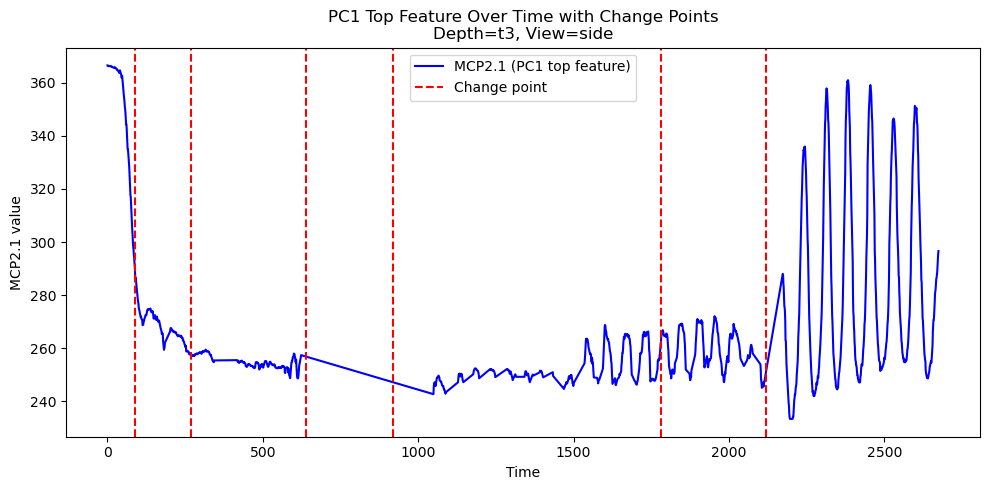

Change points (frame indices) for t3 side: [90, 270, 640, 920, 1780, 2120, 2675]


depth   view component     feature_1      feature_2  \
0     b1  front   indices          MCP2          Elbow   
1     b1   side   indices        MCP3.1  StablePoint.1   
2     b2  front   indices    MidForeArm           MCP2   
3     b2   side   indices        MCP2.1        fTip2.1   
4     b3  front   indices  MidForeArm.1          fTip4   
5     b3   side   indices    PalmBase.1          fTip1   
6     c1  front   indices       fTip5.1          fTip4   
7     c1   side   indices          MCP3          fTip2   
8     c2  front   indices         fTip3          Elbow   
9     c2   side   indices        MCP2.1        fTip2.1   
10    c3  front   indices       fTip5.1        fTip1.1   
11    c3   side   indices          MCP3   MidForeArm.1   
12    t1  front   indices       fTip1.1        fTip2.1   
13    t1   side   indices         fTip2         MCP4.1   
14    t2  front   indices    MidForeArm         MCP2.1   
15    t2   side   indices        MCP3.1        fTip4.1   
16    t3  front   indices    MidForeArm           MCP3   
17    t3   side   indices        MCP2.1          fTip2   

                                        change_points  
0                             [105, 1255, 1930, 2966]  
1                            [1480, 1725, 2415, 2891]  
2                              [160, 565, 1055, 1560]  
3                         [130, 165, 515, 1080, 1594]  
4                              [180, 465, 1035, 1522]  
5                              [180, 550, 1065, 1519]  
6             [30, 545, 1120, 1225, 1765, 1840, 1878]  
7                         [60, 720, 1145, 1800, 1844]  
8                         [60, 955, 1180, 1645, 1818]  
9                         [75, 610, 1235, 1645, 1830]  
10                       [145, 635, 1080, 1650, 1708]  
11                 [150, 580, 1045, 1185, 1575, 1711]  
12             [35, 135, 750, 1320, 1650, 2220, 2360]  
13            [60, 810, 1350, 1500, 1655, 2220, 2373]  
14        [40, 275, 775, 870, 1465, 2050, 2110, 2267]  
15              [70, 200, 770, 880, 1515, 2010, 2225]  
16  [65, 440, 590, 910, 1090, 1470, 2080, 2330, 2638]  
17              [90, 270, 640, 920, 1780, 2120, 2675]

In [436]:
results_list2 = []

# Parameters for ruptures
model = "rbf"
penalty_value = 30  # Adjust as needed

# creates new column for new change points
if 'cp_handOC_handPS' not in df_indices.columns:
    df_indices['cp_handOC_handPS'] = None
    df_indices['cp_handOC_handPS'] = df_indices['cp_handOC_handPS'].astype(object)


for depth in depths:
    for view in views:
        print(f"\nProcessing depth={depth}, view={view}")

        # Get top PC1 and PC2 features
        top_feature_pc1 = get_top_feature(top5_start_pc1_df, depth, view, 'PC1')
        top_feature_pc2 = get_top_feature(top5_start_pc2_df, depth, view, 'PC2')

        if top_feature_pc1 is None or top_feature_pc2 is None:
            print(f"Skipping {depth} {view} - missing top features")
            continue

        df_key = depth + ('f' if view == 'front' else 's')
        if df_key not in dataframes:
            print(f"Data for {df_key} not found in dataframes.")
            continue

        df = dataframes[df_key]

        if top_feature_pc1 not in df.columns or top_feature_pc2 not in df.columns:
            print(f"Features {top_feature_pc1} or {top_feature_pc2} not found in dataframe for {df_key}")
            continue

        # Extract data
        x = df[top_feature_pc1].to_numpy()
        y = df[top_feature_pc2].to_numpy()
        t = np.arange(len(x))

        # Stack for ruptures input
        signal = np.column_stack((x, y))  # shape (n_samples, 2)

        # Run RBF change point detection
        algo = rpt.Pelt(model=model).fit(signal)
        change_points = algo.predict(pen=penalty_value)



        # Inside the nested loop after change_points are computed
        plt.figure(figsize=(10, 5))
        plt.plot(t, x, label=f"{top_feature_pc1} (PC1 top feature)", color='blue')
        for cp in change_points[:-1]:  # Skip the last point if it's just the end of signal
            plt.axvline(x=cp, color='red', linestyle='--', label='Change point' if cp == change_points[0] else "")
        plt.xlabel("Time")
        plt.ylabel(f"{top_feature_pc1} value")
        plt.title(f"PC1 Top Feature Over Time with Change Points\nDepth={depth}, View={view}")
        plt.legend()
        plt.tight_layout()
        plt.show()




        # Print results
        print(f"Change points (frame indices) for {depth} {view}: {change_points}")

        # Create a dictionary for storing change point results
        dic_indices2 = {
            "depth": depth,
            "view": view,
            "component": "indices"
        }

        # Save the top features and their change points
        dic_indices2["feature_1"] = top_feature_pc1
        dic_indices2["feature_2"] = top_feature_pc2
        dic_indices2["change_points"] = change_points

        # Assuming you're collecting multiple such dictionaries into a list
        results_list2.append(dic_indices2)

df_indices2 = pd.DataFrame(results_list2)

df_indices2 


## Segment

[105, 1255, 1930, 2966]
[1475, 2966]


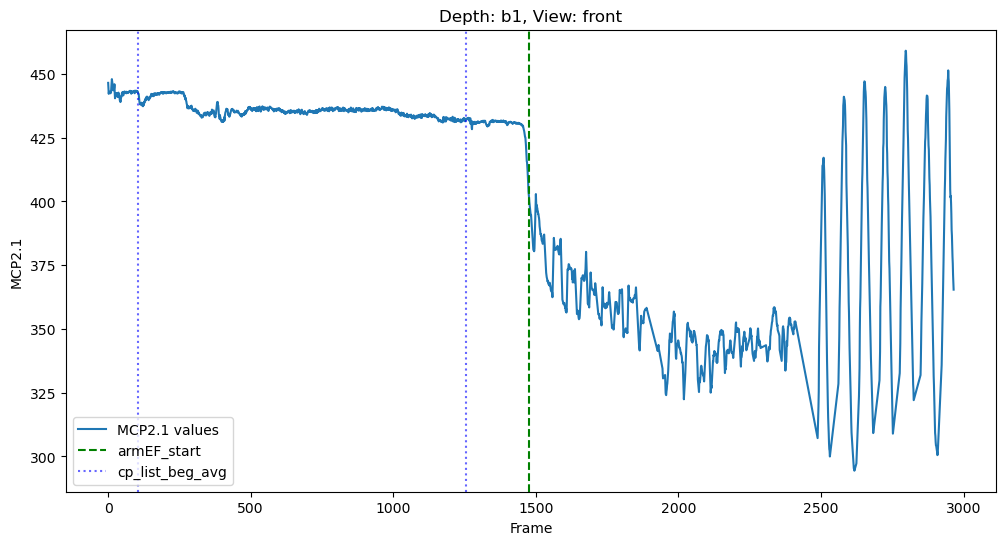

[1480, 1725, 2415, 2891]
[1480, 1920, 2560, 2891]


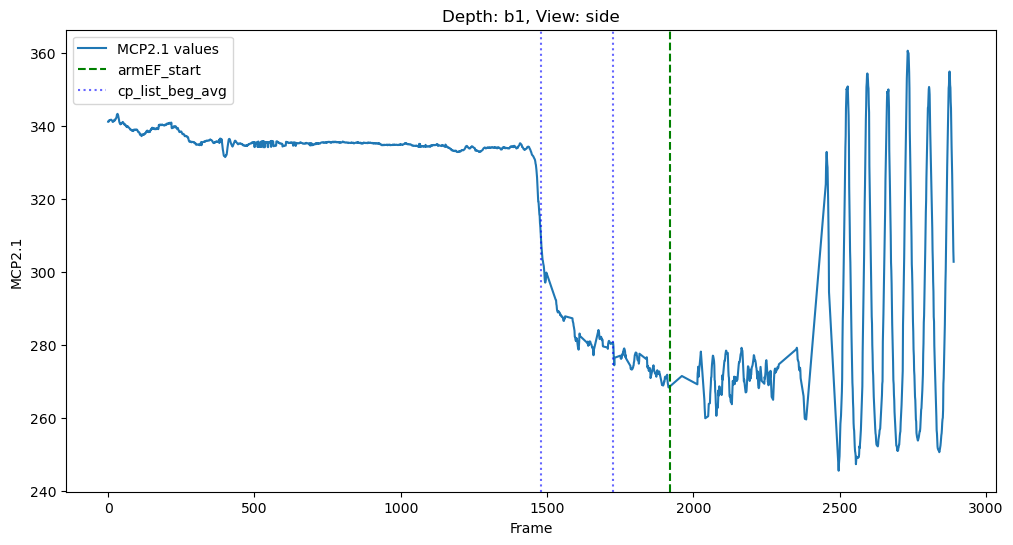

[160, 565, 1055, 1560]
[160, 410, 1070, 1560]


IndexError: list index out of range

In [438]:
def average_close_points(points, threshold=100):
    """Average points that are within threshold of each other."""
    points = sorted(points)
    averaged = []
    cluster = [points[0]]
    for p in points[1:]:
        if p - cluster[-1] <= threshold:
            cluster.append(p)
        else:
            averaged.append(int(np.mean(cluster)))
            cluster = [p]
    averaged.append(int(np.mean(cluster)))
    return averaged

for idx, (depth, view) in enumerate(zip(df_movements['dataset'], df_movements['view'])):

    # skipping if the depth is not complete for trial
    if depth in skip_trails:
        continue
    
    armEF_start = df_movements.iloc[idx]['arm_EF'][0]  # First value of the tuple

    
    # Get cp lists from df_indices2 and df_indices (or wherever cp_list_all is)
    cp_list_beg = df_indices2.loc[
        (df_indices2['depth'] == depth) & (df_indices2['view'] == view), 'change_points'
    ].values
    if len(cp_list_beg) == 0:
        continue
    cp_list_beg = cp_list_beg[0]  # assuming it's a list stored in a cell

    print(cp_list_beg)
    
    cp_list_all = df_indices.loc[
        (df_indices['depth'] == depth) & (df_indices['view'] == view), 'change_points'
    ].values
    if len(cp_list_all) == 0:
        continue
    cp_list_all = cp_list_all[0]  # assuming list stored in cell

    print(cp_list_all)
    
    # Remove points >= armEF_start
    cp_list_beg_filtered = [pt for pt in cp_list_beg if pt < armEF_start]
    cp_list_all_filtered = [pt for pt in cp_list_all if pt < armEF_start]
    
    # Average points within 100 in cp_list_beg
    cp_list_beg_avg = average_close_points(cp_list_beg_filtered, threshold=100)

    # Find the row index in df_movements for the current depth and view
    row_idx = df_movements[
        (df_movements['dataset'] == depth) & 
        (df_movements['view'] == view)
    ].index

    if not row_idx.empty:
            row_idx = row_idx[0]  # Get the actual index value

            # abiity to tune specifically for earlier trials because there is more variability
            if 't' in depth:
                print('infirst part')
                if len(cp_list_beg_avg) <= 2:
                    print(' in second part')
                    df_movements.at[row_idx, 'hand_OC'] = (0, cp_list_beg_avg[0])
                    df_movements.at[row_idx, 'hand_PS'] = (cp_list_beg_avg[0], armEF_start)
                elif cp_list_beg_avg[0] < 550:
                    if cp_list_beg_avg[1] < 550:
                        df_movements.at[row_idx, 'hand_OC'] = (cp_list_beg_avg[1], cp_list_beg_avg[2])
                        df_movements.at[row_idx, 'hand_PS'] = (cp_list_beg_avg[2], armEF_start)
                    else:
                    
                        # Update hand_OC and hand_PS columns directly
                        df_movements.at[row_idx, 'hand_OC'] = (cp_list_beg_avg[0], cp_list_beg_avg[1])
                        df_movements.at[row_idx, 'hand_PS'] = (cp_list_beg_avg[1], armEF_start)
                else:
                    df_movements.at[row_idx, 'hand_OC'] = (0, cp_list_beg_avg[0])
                    df_movements.at[row_idx, 'hand_PS'] = (cp_list_beg_avg[0], armEF_start)


            elif cp_list_beg_avg[0] < 250:
                # Update hand_OC and hand_PS columns directly
                df_movements.at[row_idx, 'hand_OC'] = (cp_list_beg_avg[0], cp_list_beg_avg[1])
                df_movements.at[row_idx, 'hand_PS'] = (cp_list_beg_avg[1], armEF_start)
            else:
                df_movements.at[row_idx, 'hand_OC'] = (0, cp_list_beg_avg[0])
                df_movements.at[row_idx, 'hand_PS'] = (cp_list_beg_avg[0], armEF_start)

    else:
        print(f"Row not found for dataset={depth}, view={view}")



    
    # Find common points between cp_list_beg_avg and cp_list_all_filtered within 100 units
    common_points = []
    for pt1 in cp_list_beg_avg:
        for pt2 in cp_list_all_filtered:
            if abs(pt1 - pt2) <= 100:
                common_points.append(int((pt1 + pt2) / 2))
                break
                
    common_points = sorted(set(common_points))
    
    # Get your dataframe with top PC1 feature for this depth & view
    df_key = depth + ('f' if view == 'front' else 's')
    if df_key not in dataframes:
        print(f"Missing df for {df_key}")
        continue
    df = dataframes[df_key]
    
    x = df[top_feature_pc1].to_numpy()
    t = np.arange(len(x))
    
    # Plotting
    plt.figure(figsize=(12, 6))
    plt.plot(t, x, label=f"{top_feature_pc1} values")
    
    # Plot armEF_start as vertical line
    plt.axvline(armEF_start, color='green', linestyle='--', label='armEF_start')
    
    # Plot change points
    for cp in cp_list_beg_avg:
        plt.axvline(cp, color='blue', linestyle=':', alpha=0.6, label='cp_list_beg_avg' if cp == cp_list_beg_avg[0] else "")
    '''
    for cp in cp_list_all_filtered:
        plt.axvline(cp, color='orange', linestyle=':', alpha=0.6, label='cp_list_all_filtered' if cp == cp_list_all_filtered[0] else "")
    for cp in common_points:
        plt.axvline(cp, color='red', linestyle='-', linewidth=2, label='common_points' if cp == common_points[0] else "")

    '''
    
    plt.title(f"Depth: {depth}, View: {view}")
    plt.xlabel('Frame')
    plt.ylabel(f'{top_feature_pc1}')
    plt.legend()
    plt.show()


In [127]:
df_movements

dataset   view        arm_EF      hand_OC       hand_PS
0       b1  front   (715, 1298)     (0, 280)    (280, 715)
1       b1   side   (720, 1291)     (0, 350)    (350, 720)
2       b2  front   (845, 1361)   (135, 535)    (535, 845)
3       b2   side   (845, 1364)   (135, 525)    (525, 845)
4       b3  front   (615, 1158)     (0, 310)    (310, 615)
5       b3   side   (620, 1177)     (0, 310)    (310, 620)
6       c1  front  (1195, 1777)     (0, 475)   (475, 1195)
7       c1   side  (1200, 1751)     (0, 510)   (510, 1200)
8       c2  front  (1260, 1842)   (210, 640)   (640, 1260)
9       c2   side  (1260, 1839)   (232, 650)   (650, 1260)
10      c3  front  (1085, 1653)   (175, 570)   (570, 1085)
11      c3   side  (1080, 1637)   (185, 555)   (555, 1080)
12      t2  front  (2025, 2760)   (440, 990)   (990, 2025)
13      t2   side  (2155, 2755)  (460, 1000)  (1000, 2155)
14      t3  front  (1665, 2350)  (435, 1125)  (1125, 1665)
15      t3   side  (1675, 2340)     (0, 415)   (415, 1675)

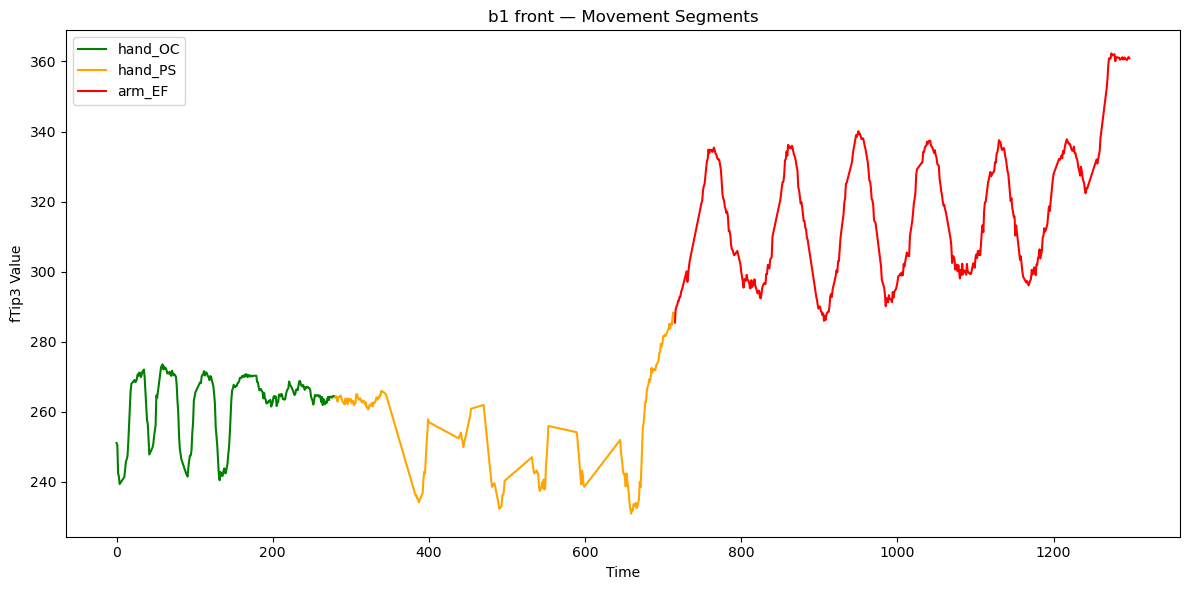

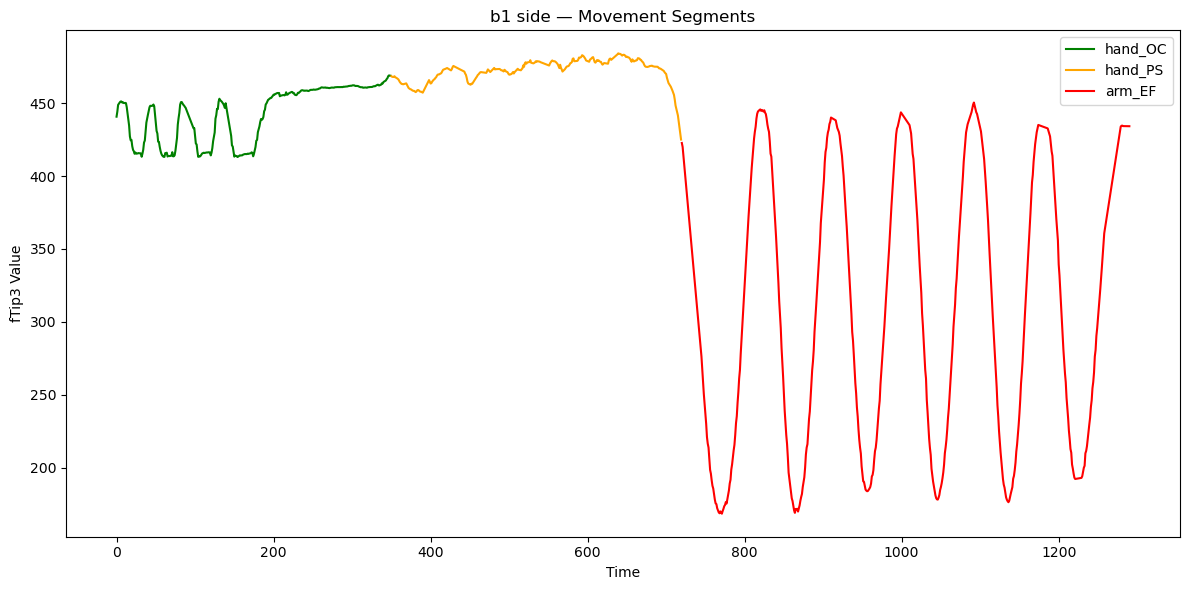

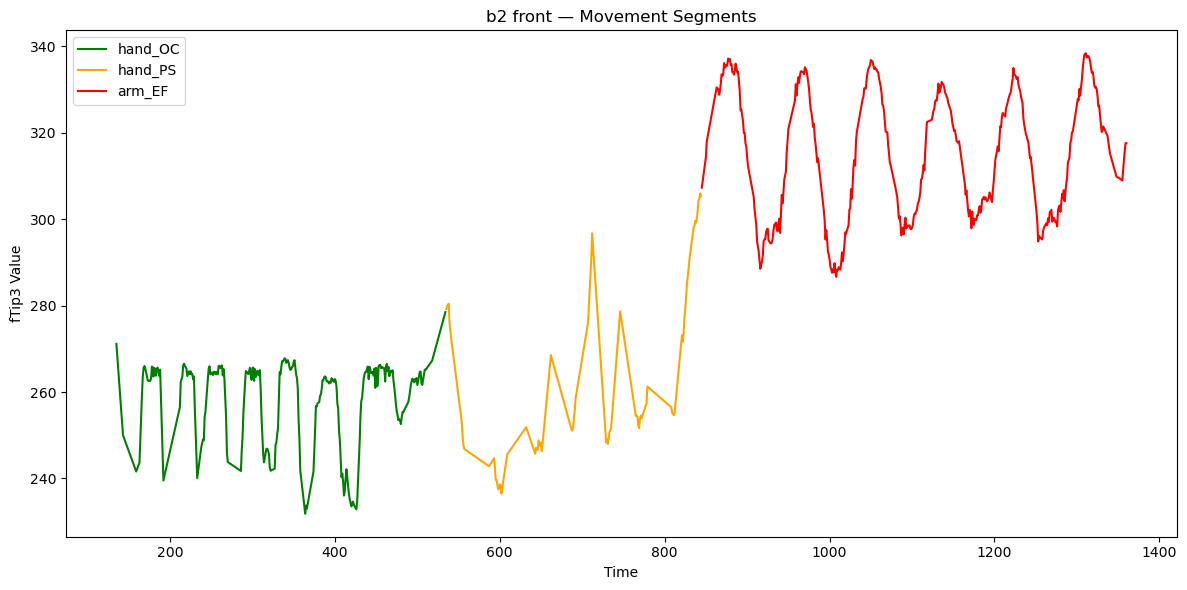

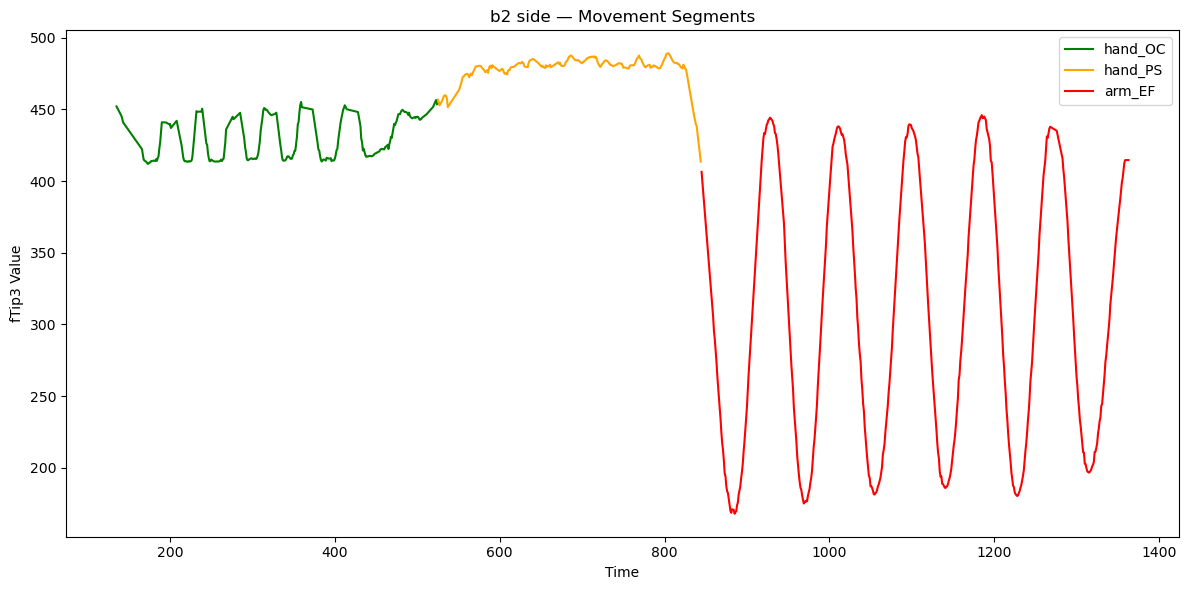

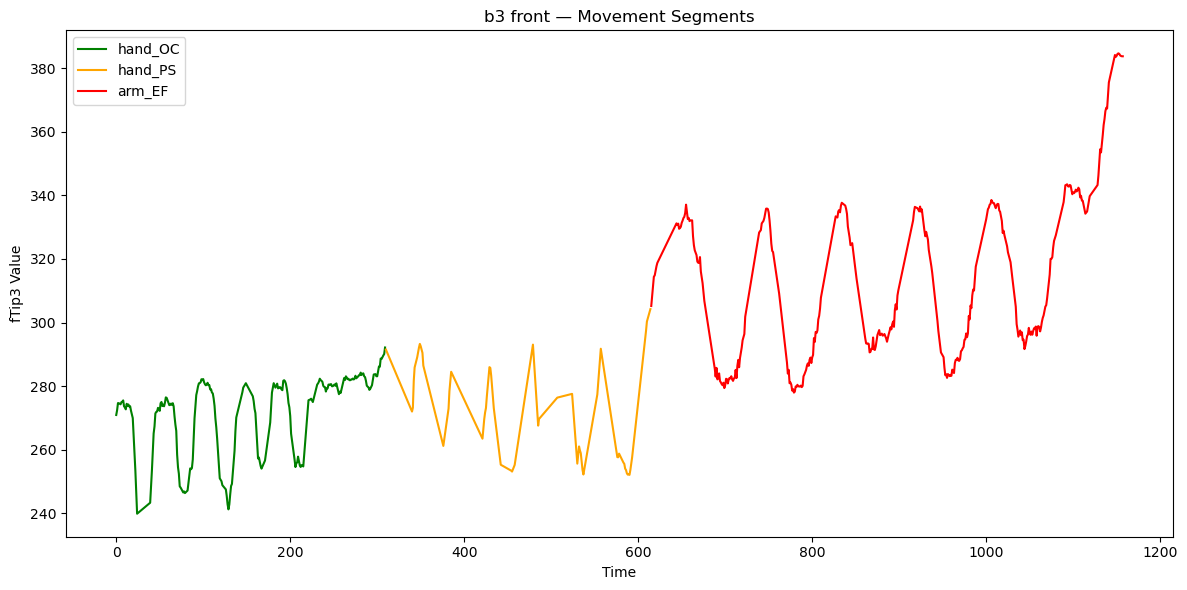

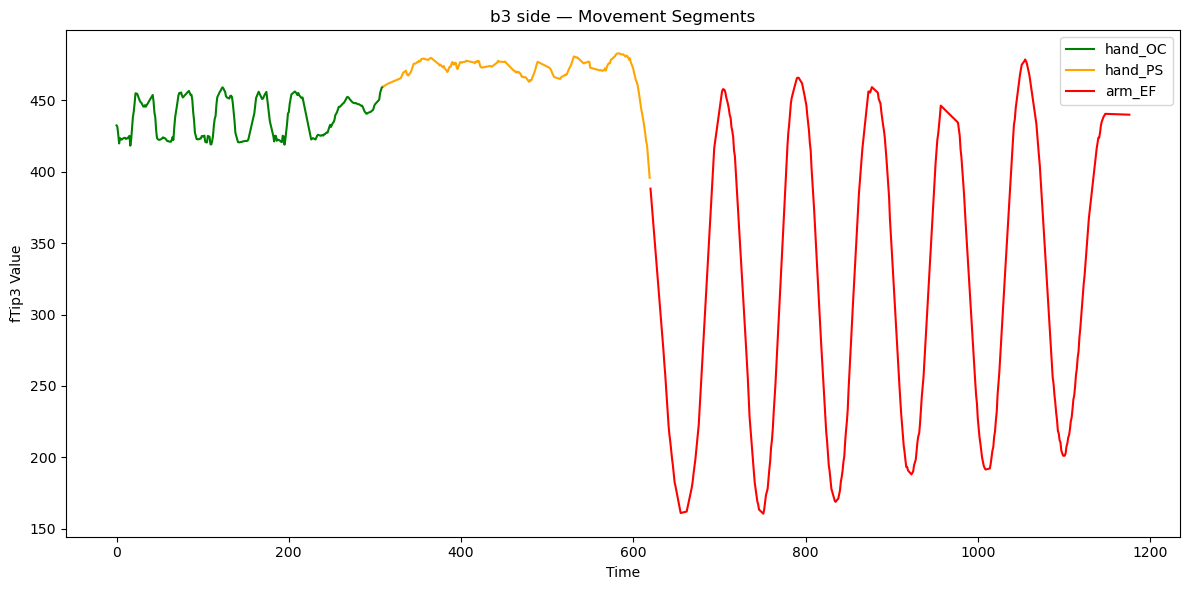

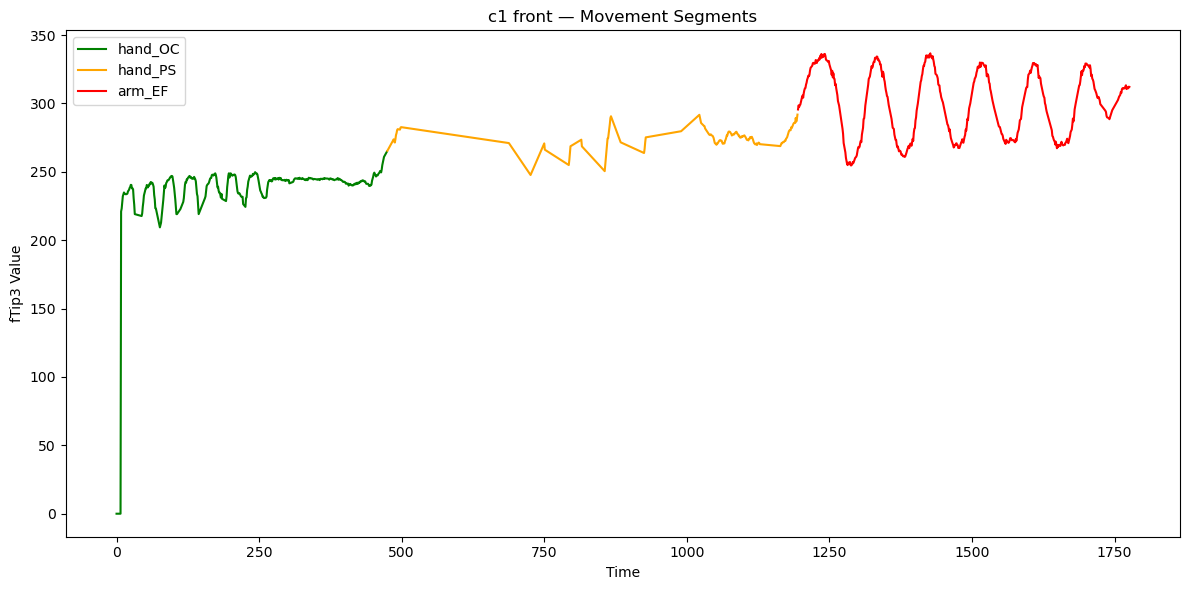

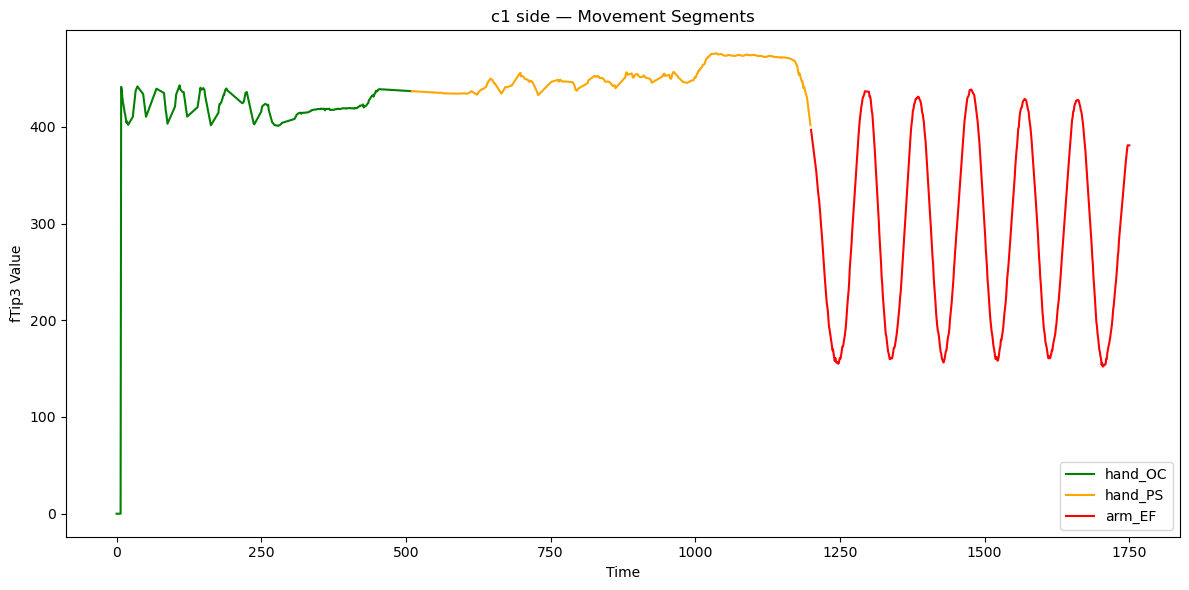

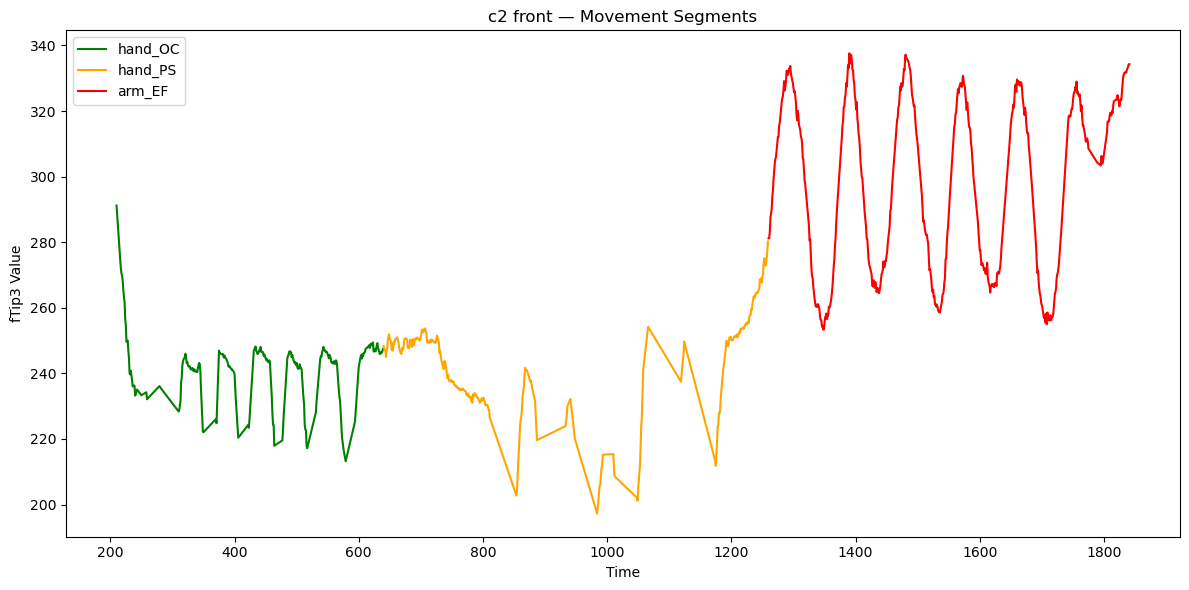

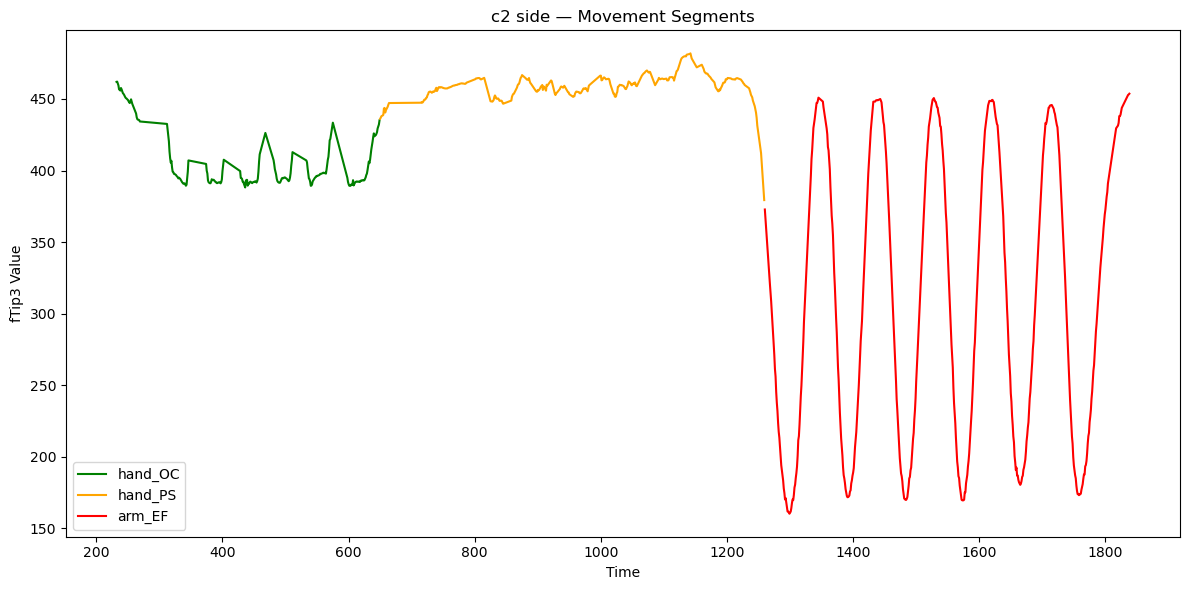

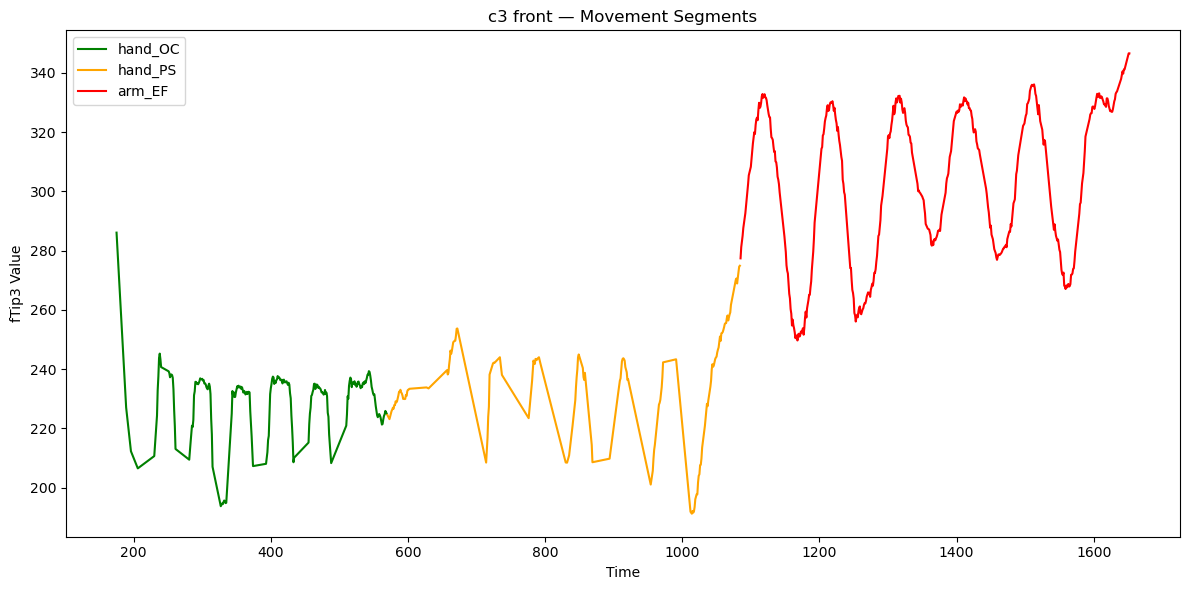

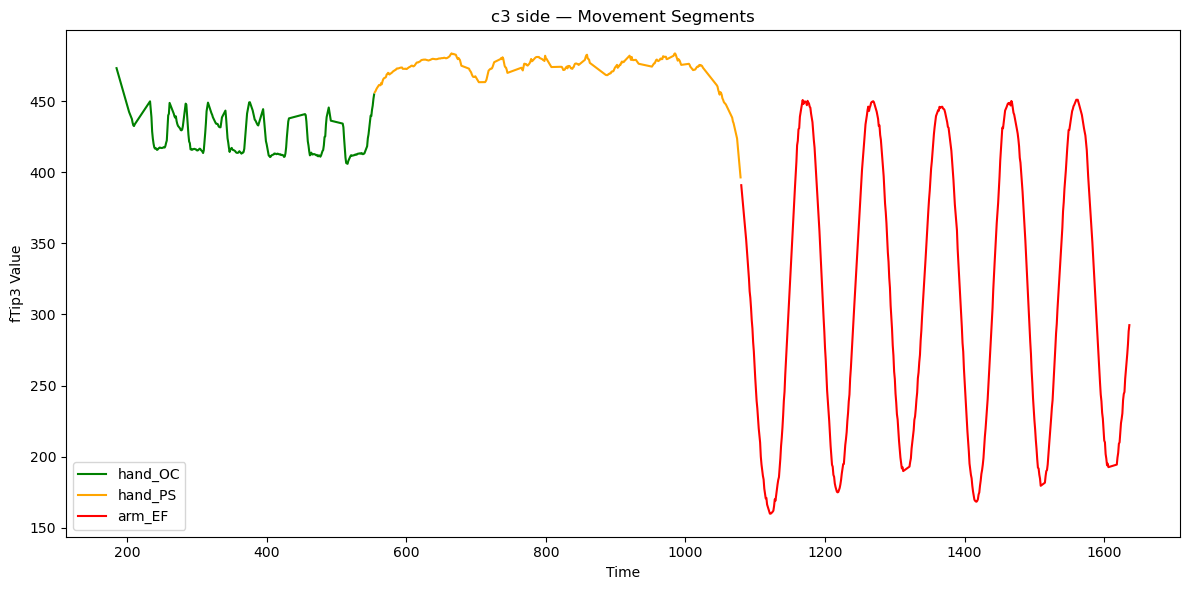

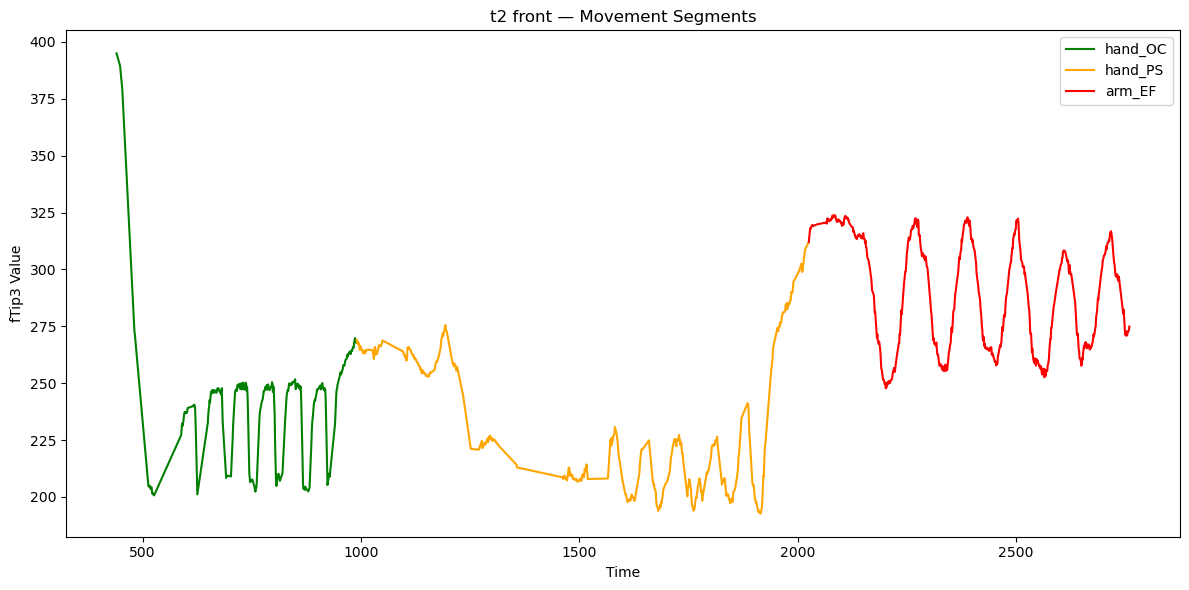

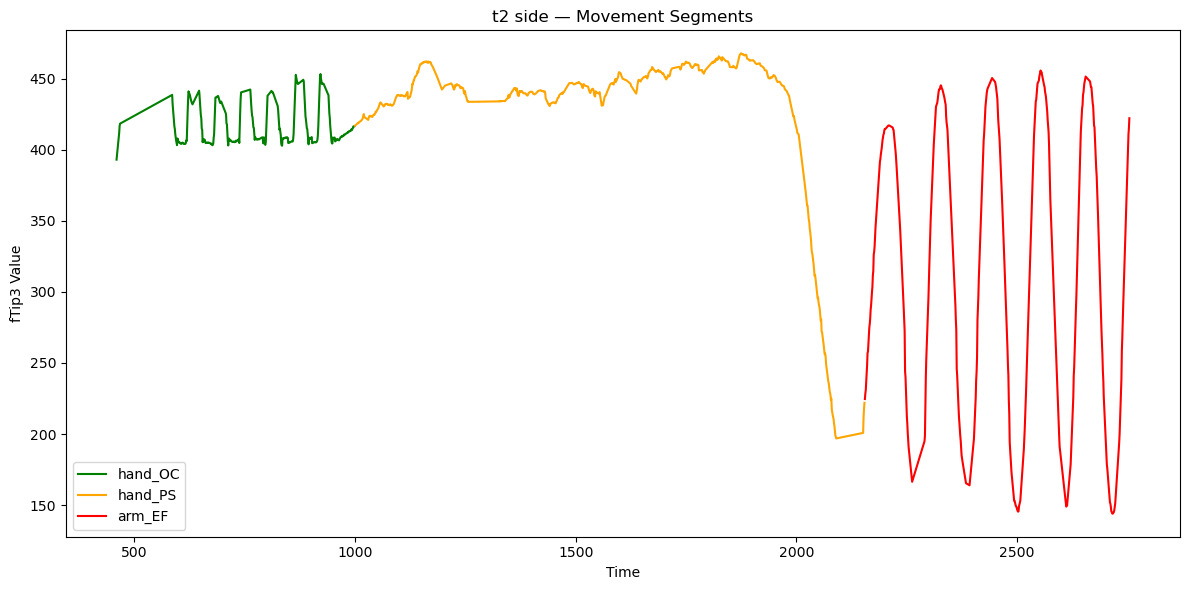

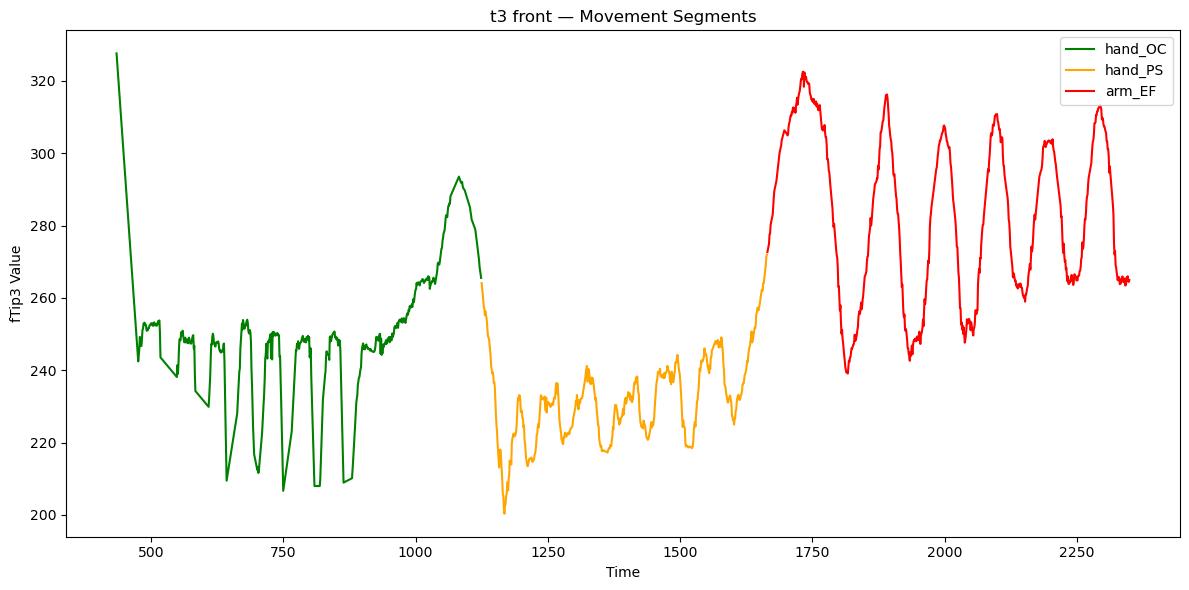

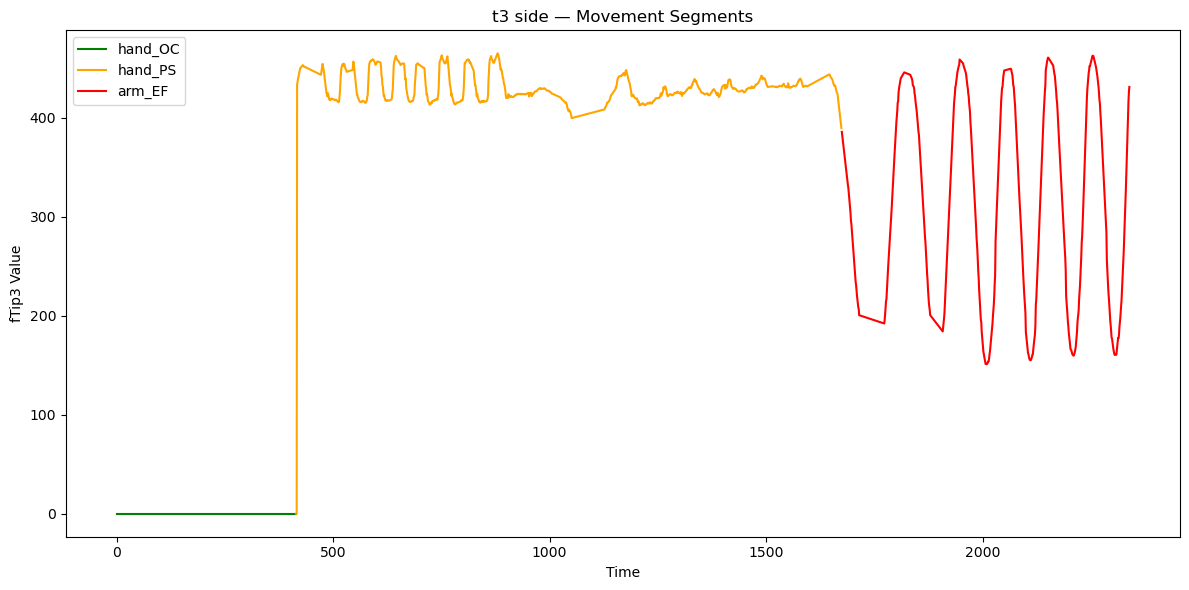

In [ ]:
# Example colors for the movements
movement_colors = {
    'hand_OC': 'green',
    'hand_PS': 'orange',
    'arm_EF': 'red'
}

for idx, row in df_movements.iterrows():
    dataset = row['dataset']
    view = row['view']

    # Build dataframe key like before (e.g., 'b1f' for b1 front)
    df_key = dataset + ('f' if view == 'front' else 's')

    if df_key not in dataframes:
        print(f"Skipping {df_key} — data not found.")
        continue

    df = dataframes[df_key]
    
    # Extract x and t data
    x = df[top_feature_pc1].to_numpy()
    t = np.arange(len(x))

    # Get segment indices
    armEF_start, armEF_end = row['arm_EF']
    handOC_start, handOC_end = row['hand_OC']
    handPS_start, handPS_end = row['hand_PS']

    plt.figure(figsize=(12, 6))
    
    # Plot hand_OC segment
    plt.plot(t[handOC_start:handOC_end], x[handOC_start:handOC_end],
             color=movement_colors['hand_OC'], label='hand_OC')

    # Plot hand_PS segment
    plt.plot(t[handPS_start:handPS_end], x[handPS_start:handPS_end],
             color=movement_colors['hand_PS'], label='hand_PS')

    # Plot arm_EF segment
    plt.plot(t[armEF_start:armEF_end], x[armEF_start:armEF_end],
             color=movement_colors['arm_EF'], label='arm_EF')

    plt.title(f"{dataset} {view} — Movement Segments")
    plt.xlabel("Time")
    plt.ylabel(f"{top_feature_pc1} Value")
    plt.legend()
    plt.tight_layout()
    plt.show()


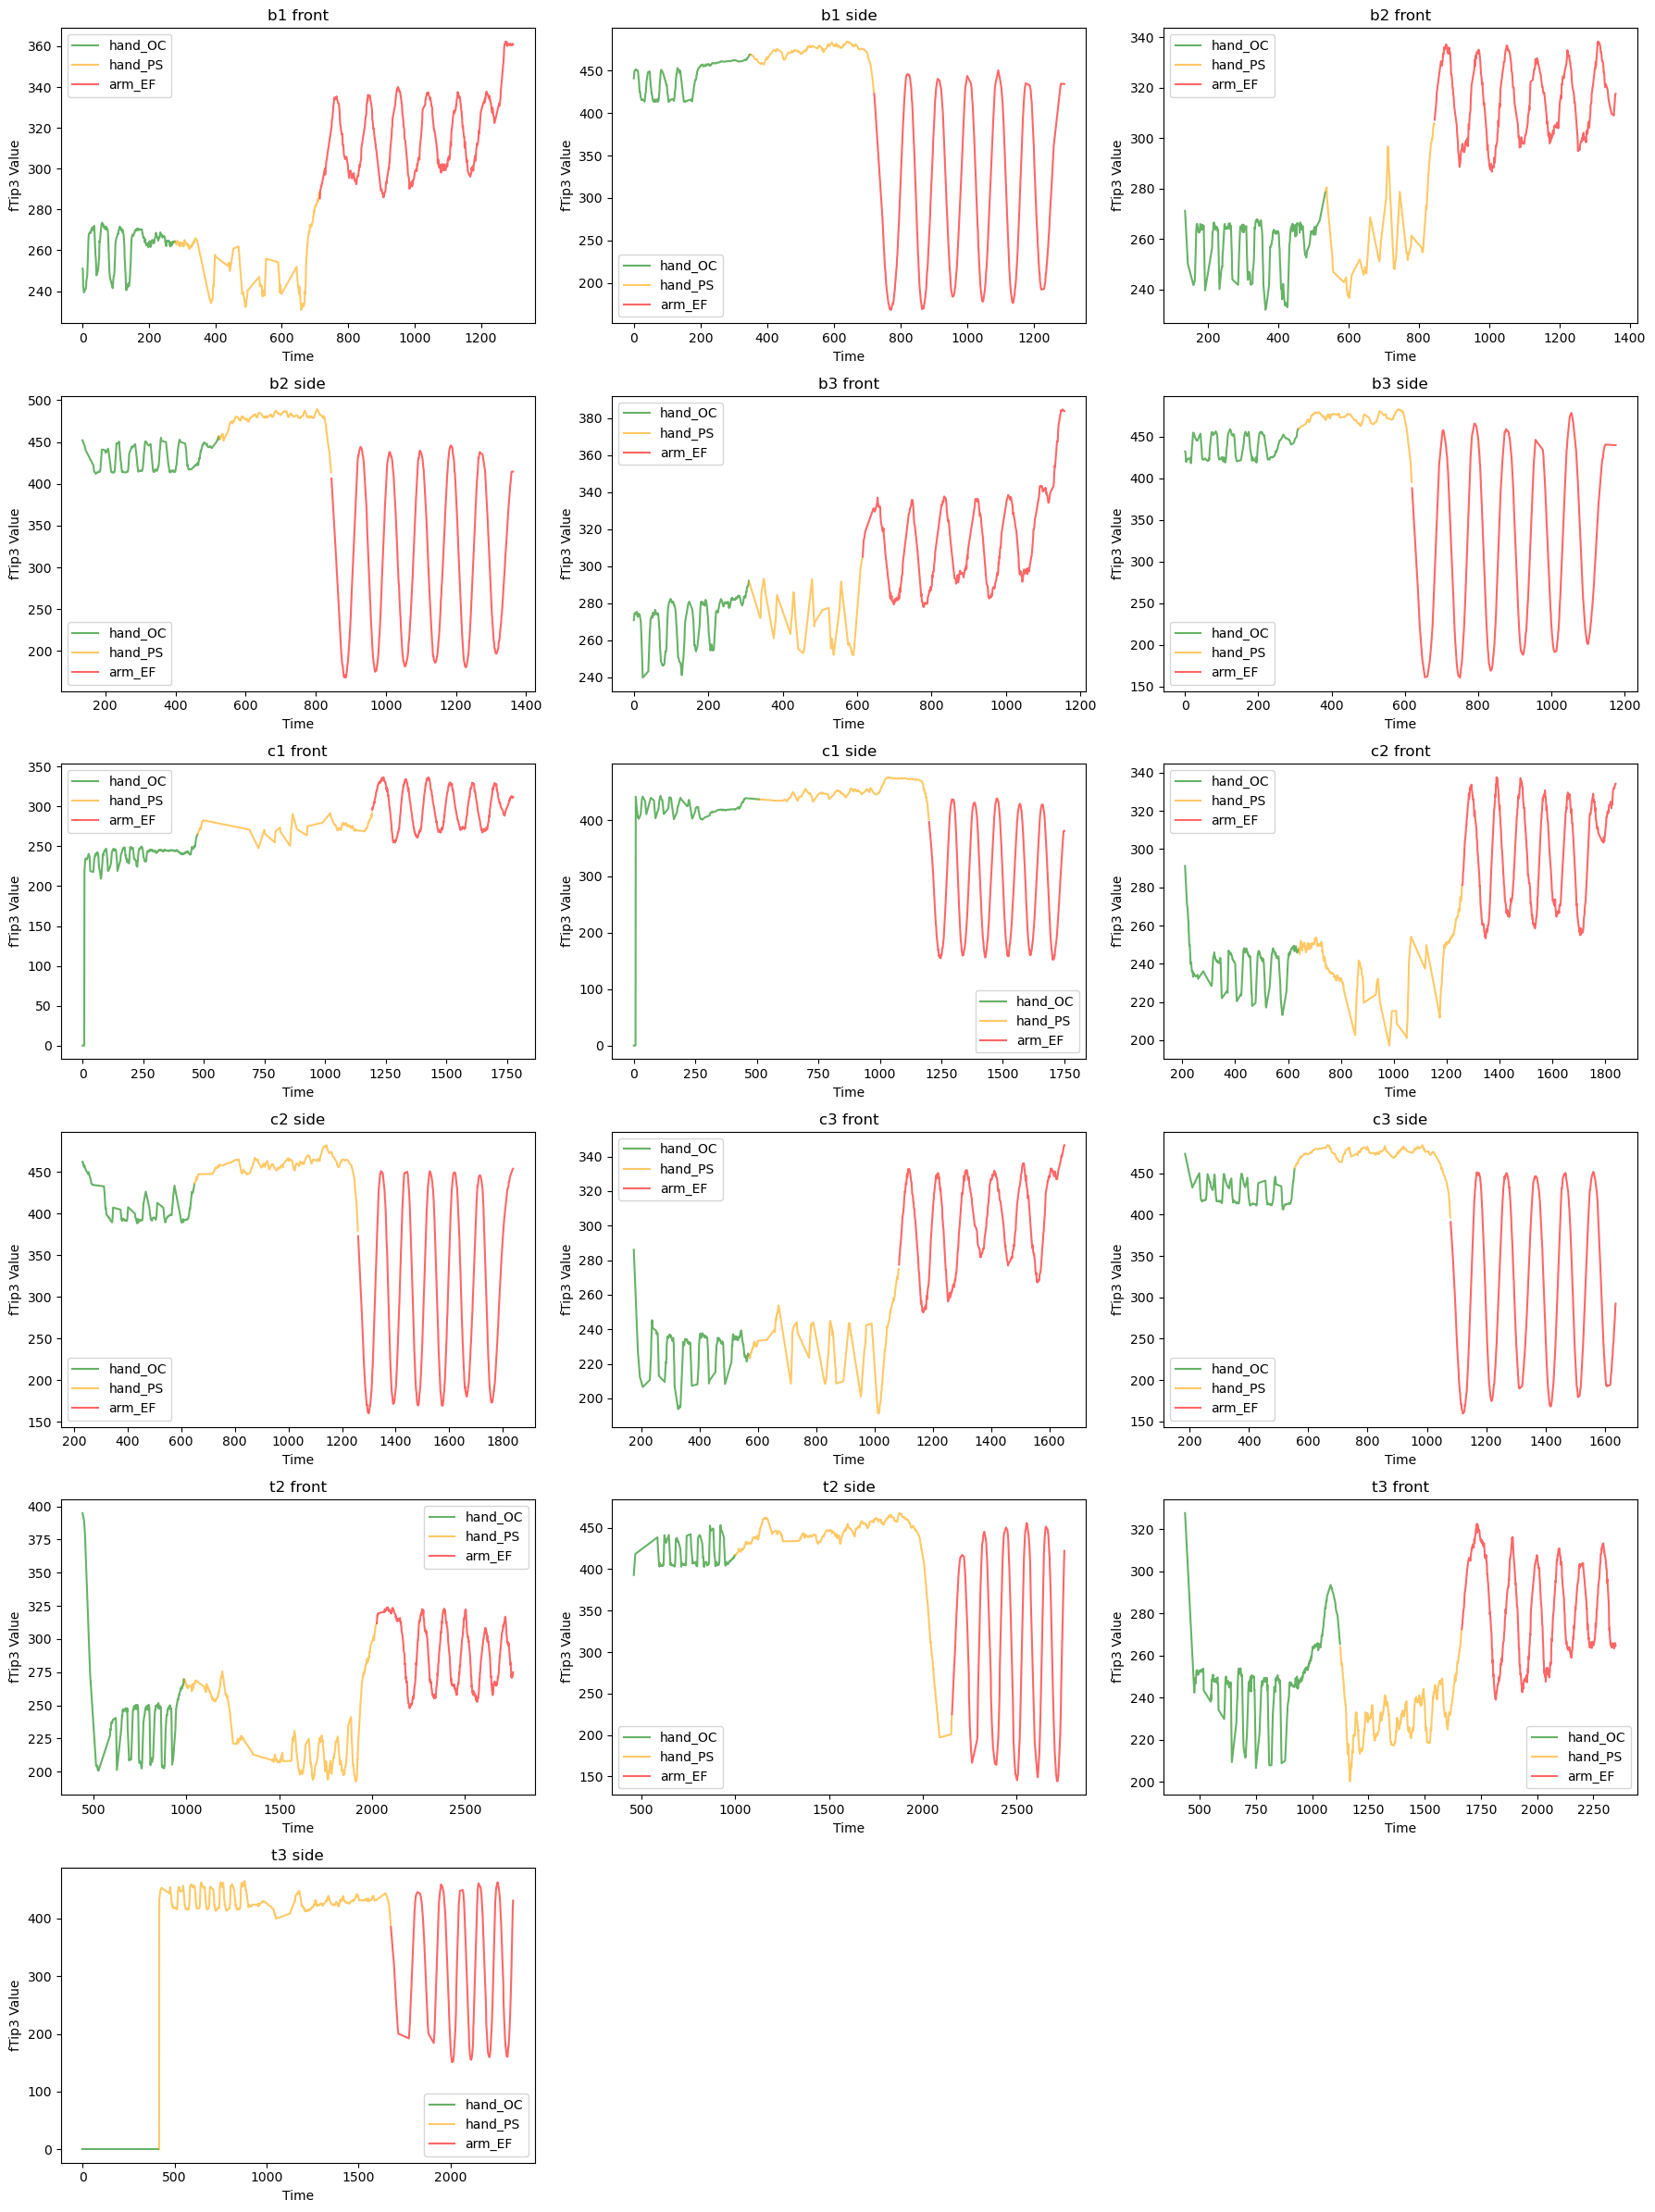

In [ ]:
# Number of plots = number of rows in df_movements
num_plots = len(df_movements)

# Decide layout (e.g., 3 columns)
cols = 3
rows = (num_plots + cols - 1) // cols  # ceiling division

# Create subplots grid
fig, axes = plt.subplots(rows, cols, figsize=(cols*6, rows*4), squeeze=False)

# Flatten axes for easy iteration
axes_flat = axes.flatten()

movement_colors = {
    'hand_OC': 'green',
    'hand_PS': 'orange',
    'arm_EF': 'red'
}

for idx, (row, ax) in enumerate(zip(df_movements.itertuples(), axes_flat)):
    dataset = row.dataset
    view = row.view

    df_key = dataset + ('f' if view == 'front' else 's')

    if df_key not in dataframes:
        print(f"Skipping {df_key} — data not found.")
        ax.axis('off')  # Hide empty subplot
        continue

    df = dataframes[df_key]

    x = df[top_feature_pc1].to_numpy()
    t = np.arange(len(x))

    armEF_start, armEF_end = row.arm_EF
    handOC_start, handOC_end = row.hand_OC
    handPS_start, handPS_end = row.hand_PS

    # Plot segments on the subplot ax
    ax.plot(t[handOC_start:handOC_end], x[handOC_start:handOC_end],
            color=movement_colors['hand_OC'], alpha=0.6, label='hand_OC')

    ax.plot(t[handPS_start:handPS_end], x[handPS_start:handPS_end],
            color=movement_colors['hand_PS'], alpha=0.6, label='hand_PS')

    ax.plot(t[armEF_start:armEF_end], x[armEF_start:armEF_end],
            color=movement_colors['arm_EF'], alpha=0.6, label='arm_EF')

    ax.set_title(f"{dataset} {view}")
    ax.set_xlabel("Time")
    ax.set_ylabel(f"{top_feature_pc1} Value")
    ax.legend()

# Hide any unused subplots if num_plots is less than rows*cols
for j in range(num_plots, len(axes_flat)):
    axes_flat[j].axis('off')

plt.tight_layout()
plt.show()


## Getting peaks and troughs

In [326]:
df_movements

dataset   view        arm_EF      hand_OC       hand_PS
0       b1  front   (715, 1298)     (0, 280)    (280, 715)
1       b1   side   (720, 1291)     (0, 350)    (350, 720)
2       b2  front   (845, 1361)   (135, 535)    (535, 845)
3       b2   side   (845, 1364)   (135, 525)    (525, 845)
4       b3  front   (615, 1158)     (0, 310)    (310, 615)
5       b3   side   (620, 1177)     (0, 310)    (310, 620)
6       c1  front  (1195, 1777)     (0, 475)   (475, 1195)
7       c1   side  (1200, 1751)     (0, 510)   (510, 1200)
8       c2  front  (1260, 1842)   (210, 640)   (640, 1260)
9       c2   side  (1260, 1839)   (232, 650)   (650, 1260)
10      c3  front  (1085, 1653)   (175, 570)   (570, 1085)
11      c3   side  (1080, 1637)   (185, 555)   (555, 1080)
12      t2  front  (2025, 2760)   (440, 990)   (990, 2025)
13      t2   side  (2155, 2755)  (460, 1000)  (1000, 2155)
14      t3  front  (1665, 2350)  (435, 1125)  (1125, 1665)
15      t3   side  (1675, 2340)     (0, 415)   (415, 1675)

In [418]:
# OPTIONAL: Drop existing computed columns if re-running (can get rid of this once pipeline is set)
cols_to_remove = [col for col in df_movements.columns if 'peaks' in col or 'troughs' in col or 'euclidean_dis' in col or 'arm_EF_data' in col]
df_movements = df_movements.drop(columns=cols_to_remove, errors='ignore')

# Recompute
results_df = df_movements.apply(compute_peaks_troughs, axis=1)
df_movements = pd.concat([df_movements, results_df], axis=1)


df_movements

Raw peaks: [ 63 158 320], dtype: int64
Raw troughs: [ 95 293], dtype: int64
Raw peaks: [ 38  87 133 176 215 252], dtype: int64
Raw troughs: [  9  62 107 151 194 233 270], dtype: int64
Raw peaks: [ 35  84 111 162 205 253], dtype: int64
Raw troughs: [ 12  57  98 136 181 226 275], dtype: int64
Raw peaks: [ 82 199 267 332 399 465 539 611 697], dtype: int64
Raw troughs: [172 237 292 378 449 507], dtype: int64
Raw peaks: [ 62 162 236 301 366 429 491], dtype: int64
Raw troughs: [126 187 276 336 399 459 535], dtype: int64
Raw peaks: [ 95 159 221 282 344 413], dtype: int64
Raw troughs: [116 180 255 319 366 480], dtype: int64
Raw peaks: [223 357 474 527 593 667 742 821 892], dtype: int64
Raw troughs: [338 428 503 618 699 762 845 929], dtype: int64
Raw peaks: [ 54 130 193 278 358 441], dtype: int64
Raw troughs: [ 30  93 157 235 314 385 500], dtype: int64


dataset   view        arm_EF      hand_OC       hand_PS  \
0       b1  front   (715, 1298)     (0, 280)    (280, 715)   
1       b1   side   (720, 1291)     (0, 350)    (350, 720)   
2       b2  front   (845, 1361)   (135, 535)    (535, 845)   
3       b2   side   (845, 1364)   (135, 525)    (525, 845)   
4       b3  front   (615, 1158)     (0, 310)    (310, 615)   
5       b3   side   (620, 1177)     (0, 310)    (310, 620)   
6       c1  front  (1195, 1777)     (0, 475)   (475, 1195)   
7       c1   side  (1200, 1751)     (0, 510)   (510, 1200)   
8       c2  front  (1260, 1842)   (210, 640)   (640, 1260)   
9       c2   side  (1260, 1839)   (232, 650)   (650, 1260)   
10      c3  front  (1085, 1653)   (175, 570)   (570, 1085)   
11      c3   side  (1080, 1637)   (185, 555)   (555, 1080)   
12      t2  front  (2025, 2760)   (440, 990)   (990, 2025)   
13      t2   side  (2155, 2755)  (460, 1000)  (1000, 2155)   
14      t3  front  (1665, 2350)  (435, 1125)  (1125, 1665)   
15      t3   side  (1675, 2340)     (0, 415)   (415, 1675)   

                               hand_OC_peaks  \
0                         [27, 65, 112, 182]   
1                                       None   
2        [177, 221, 256, 299, 345, 393, 492]   
3                                       None   
4                   [54, 103, 150, 189, 240]   
5                                       None   
6      [21, 55, 91, 129, 163, 203, 238, 446]   
7                                       None   
8                  [331, 390, 441, 500, 554]   
9                                       None   
10            [247, 299, 355, 409, 471, 520]   
11                                      None   
12            [606, 662, 724, 783, 843, 906]   
13                                      None   
14  [496, 564, 625, 679, 725, 788, 841, 948]   
15                                      None   

                             hand_OC_troughs  \
0                              [44, 89, 136]   
1                                       None   
2        [148, 197, 236, 278, 322, 366, 421]   
3                                       None   
4                    [31, 79, 128, 169, 211]   
5                                       None   
6          [38, 74, 110, 147, 186, 222, 258]   
7                                       None   
8             [281, 360, 414, 470, 521, 583]   
9                                       None   
10            [209, 276, 329, 388, 441, 493]   
11                                      None   
12       [516, 631, 695, 752, 812, 875, 928]   
13                                      None   
14  [470, 538, 601, 651, 702, 755, 814, 872]   
15                                      None   

                                hand_OC_euclidean_dis  \
0   [-65.18766113284943, -65.53525681439089, -66.1...   
1                                                None   
2   [-96.9870368254948, -97.27001110237158, -97.81...   
3                                                None   
4   [-33.6298884986964, -33.61118822764665, -33.57...   
5                                                None   
6   [-301.7386333759886, -297.2680478811725, -288....   
7                                                None   
8   [-22.058473418562443, -22.378717637358587, -23...   
9                                                None   
10  [-39.17263612930016, -39.84970169650581, -41.1...   
11                                               None   
12  [-39.93518083334801, -39.894553609849005, -39....   
13                                               None   
14  [-51.43288397139786, -51.57090658791437, -51.8...   
15                                               None   

                                        hand_PS_peaks  \
0                                     [343, 438, 600]   
1                                                None   
2                      [573, 622, 668, 711, 750, 787]   
3                                                None   
4                      [345, 394, 421, 472, 515, 563]   
5 

## Viewing peaks and troughs

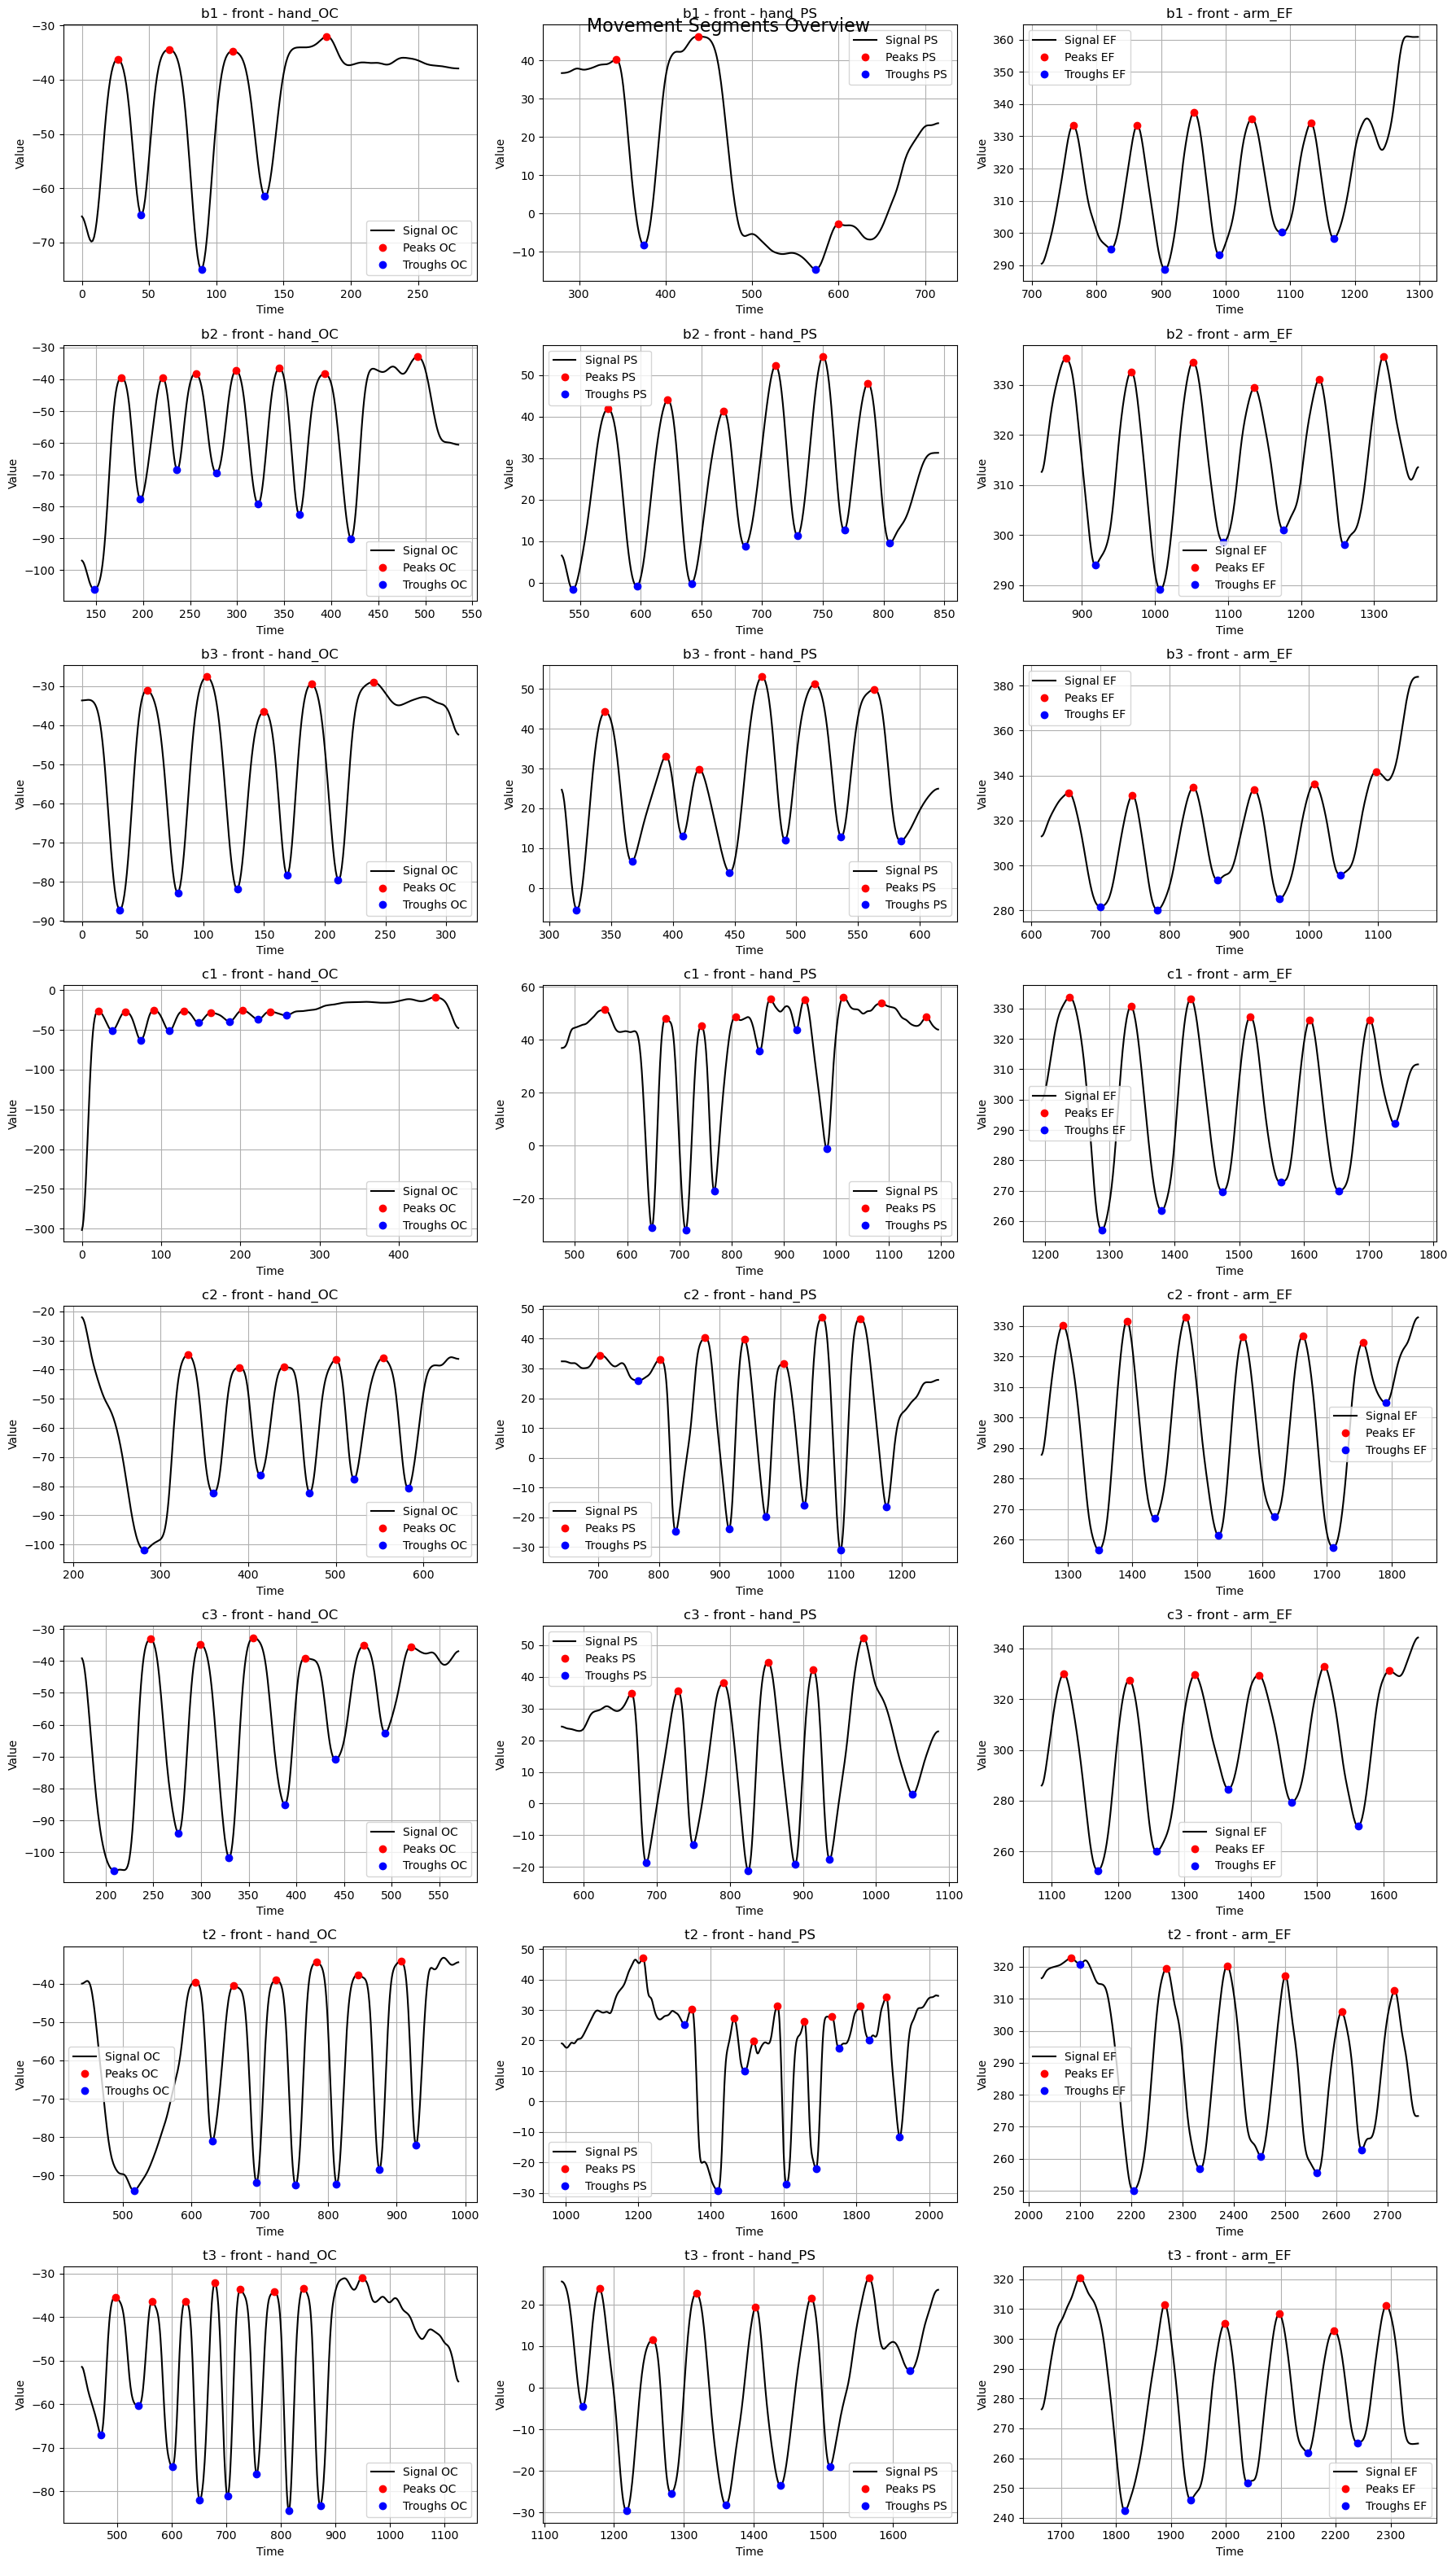

In [419]:
def plot_segment(ax, t, data, peaks=None, troughs=None, label_suffix=""):
    ax.plot(t, data, label=f'Signal {label_suffix}', color='black')

    peaks = np.atleast_1d(peaks)
    if peaks.size > 0 and not np.all(pd.isna(peaks)):
        ax.plot(peaks, np.interp(peaks, t, data), 'ro', label=f'Peaks {label_suffix}')

    troughs = np.atleast_1d(troughs)
    if troughs.size > 0 and not np.all(pd.isna(troughs)):
        ax.plot(troughs, np.interp(troughs, t, data), 'bo', label=f'Troughs {label_suffix}')

num_plots = 0  # will count how many subplots we actually need

# Count how many subplots we'll create
for _, row in df_movements.iterrows():
    if row['hand_OC'] is not None:
        num_plots += 1
    elif row['view'] == 'front':
        if row['hand_PS'] is not None:
            num_plots += 1
        if row['arm_EF'] is not None:
            num_plots += 1

cols = 3
rows = ((num_plots + cols - 1) // cols) + 2  # add an extra row buffer

fig, axes = plt.subplots(rows, cols, figsize=(18, 4 * rows))
axes = axes.flatten()

plot_idx = 0  # index for axes

for idx, row in df_movements.iterrows():

    if row['hand_OC_euclidean_dis'] is None or len(row['hand_OC_euclidean_dis']) == 0:
        continue

    depth = row['dataset']
    view = row['view']

    df_key = depth + ('f')
    df_data = dataframes.get(df_key)
    if df_data is None:
        print(f"Data not found for {df_key} — Skipping")
        continue

    
    ax = axes[plot_idx]
    plot_idx += 1

    start, end = row['hand_OC']
    segment = row['hand_OC_euclidean_dis']
    tOC = np.arange(len(segment)) + start

    plot_segment(ax, tOC, segment,
                    peaks=row.get('hand_OC_peaks'),
                    troughs=row.get('hand_OC_troughs'),
                    label_suffix='OC')

    ax.set_title(f"{depth} - front - hand_OC")
    ax.set_xlabel("Time")
    ax.set_ylabel("Value")
    ax.grid(True)
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys())

    # For front view, plot hand_PS and arm_EF on separate subplots if they exist

    if row['hand_PS'] is not None:
        ax = axes[plot_idx]
        plot_idx += 1

        start_ps, end_ps = row['hand_PS']
        segment = row['hand_PS_euclidean_dis']
        tPS = np.arange(len(segment)) + start_ps

        plot_segment(ax, tPS, segment,
                        peaks=row.get('hand_PS_peaks'),
                        troughs=row.get('hand_PS_troughs'),
                        label_suffix='PS')

        ax.set_title(f"{depth} - front - hand_PS")
        ax.set_xlabel("Time")
        ax.set_ylabel("Value")
        ax.grid(True)
        handles, labels = ax.get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        ax.legend(by_label.values(), by_label.keys())

    if row['arm_EF'] is not None:
        ax = axes[plot_idx]
        plot_idx += 1

        start_ef, end_ef = row['arm_EF']
        segment = row['arm_EF_data']
        tEF = np.arange(len(segment)) + start_ef

        plot_segment(ax, tEF, segment,
                        peaks=row.get('arm_EF_peaks'),
                        troughs=row.get('arm_EF_troughs'),
                        label_suffix='EF')

        ax.set_title(f"{depth} - front - arm_EF")
        ax.set_xlabel("Time")
        ax.set_ylabel("Value")
        ax.grid(True)
        handles, labels = ax.get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        ax.legend(by_label.values(), by_label.keys())

# Remove unused axes
for j in range(plot_idx, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("Movement Segments Overview", fontsize=16)
plt.subplots_adjust(top=0.5)
plt.tight_layout()
plt.show()


In [284]:
df_movements

dataset   view        arm_EF      hand_OC       hand_PS hand_OC_peaks  \
0       b1  front   (715, 1298)     (0, 280)    (280, 715)          None   
1       b1   side   (720, 1291)     (0, 350)    (350, 720)          None   
2       b2  front   (845, 1361)   (135, 535)    (535, 845)          None   
3       b2   side   (845, 1364)   (135, 525)    (525, 845)          None   
4       b3  front   (615, 1158)     (0, 310)    (310, 615)          None   
5       b3   side   (620, 1177)     (0, 310)    (310, 620)          None   
6       c1  front  (1195, 1777)     (0, 475)   (475, 1195)          None   
7       c1   side  (1200, 1751)     (0, 510)   (510, 1200)          None   
8       c2  front  (1260, 1842)   (210, 640)   (640, 1260)          None   
9       c2   side  (1260, 1839)   (232, 650)   (650, 1260)          None   
10      c3  front  (1085, 1653)   (175, 570)   (570, 1085)          None   
11      c3   side  (1080, 1637)   (185, 555)   (555, 1080)          None   
12      t2  front  (2025, 2760)   (440, 990)   (990, 2025)          None   
13      t2   side  (2155, 2755)  (460, 1000)  (1000, 2155)          None   
14      t3  front  (1665, 2350)  (435, 1125)  (1125, 1665)          None   
15      t3   side  (1675, 2340)     (0, 415)   (415, 1675)          None   

   hand_OC_troughs hand_OC_euclidean_dis hand_PS_peaks hand_PS_troughs  \
0             None                  None          None            None   
1             None                  None          None            None   
2             None                  None          None            None   
3             None                  None          None            None   
4             None                  None          None            None   
5             None                  None          None            None   
6             None                  None          None            None   
7             None                  None          None            None   
8             None                  None          None            None   
9             None                  None          None            None   
10            None                  None          None            None   
11            None                  None          None            None   
12            None                  None          None            None   
13            None                  None          None            None   
14            None                  None          None            None   
15            None                  None          None            None   

   arm_EF_peaks arm_EF_troughs  
0          None           None  
1          None           None  
2          None           None  
3          None           None  
4          None           None  
5          None           None  
6          None           None  
7          None           None  
8          None           None  
9          None           None  
10         None           None  
11         None           None  
12         None           None  
13         None           None  
14         None           None  
15         None           None

## Creating new df and exporting all different start and stops

In [357]:
def safe_concat(series):
    series = series.dropna()
    combined = []
    for item in series:
        if isinstance(item, list):
            combined.extend(item)
        elif isinstance(item, np.ndarray):
            combined.extend(item.tolist())
        elif np.isscalar(item):
            combined.append(item)
    return combined


export_rows = []  # Collect rows as dictionaries here

for depth in df_movements['dataset'].unique():
    subset = df_movements[df_movements['dataset'] == depth]

    hand_OC_peaks = safe_concat(subset['hand_OC_peaks'])
    hand_OC_troughs = safe_concat(subset['hand_OC_troughs'])
    hand_PS_peaks = safe_concat(subset['hand_PS_peaks'])
    hand_PS_troughs = safe_concat(subset['hand_PS_troughs'])
    arm_EF_peaks = safe_concat(subset['arm_EF_peaks'])
    
    # Concatenate troughs like others but also adding the change point
    arm_EF_troughs = safe_concat(subset['arm_EF_troughs'])

    # Get the first index from 'arm_EF' 
    first_arm_EF_entry = subset['arm_EF'].iloc[0]
    first_index = first_arm_EF_entry[0]

    # append it to troughs
    arm_EF_troughs = [first_index] + arm_EF_troughs


    export_rows.append({
        'dataset': depth,
        'hand_OC_peaks': hand_OC_peaks,
        'hand_OC_troughs': hand_OC_troughs,
        'hand_PS_peaks': hand_PS_peaks,
        'hand_PS_troughs': hand_PS_troughs,
        'arm_EF_peaks': arm_EF_peaks,
        'arm_EF_troughs': arm_EF_troughs
    })

# Build df_export from the list of rows
df_export = pd.DataFrame(export_rows)


In [358]:
df_export

dataset                hand_OC_peaks                 hand_OC_troughs  \
0      b1                    [27, 112]                   [44, 89, 136]   
1      b2    [221, 256, 345, 393, 492]                 [197, 236, 421]   
2      b3                         [54]              [31, 79, 128, 211]   
3      c1  [21, 55, 91, 129, 163, 203]         [38, 74, 110, 147, 258]   
4      c2              [390, 441, 500]            [281, 360, 470, 521]   
5      c3    [247, 299, 355, 409, 520]  [209, 276, 329, 388, 441, 493]   
6      t2                   [662, 906]  [631, 695, 752, 812, 875, 928]   
7      t3         [564, 625, 725, 841]  [470, 601, 651, 755, 814, 872]   

                                hand_PS_peaks  \
0                                  [343, 600]   
1                                  [622, 668]   
2                             [345, 394, 563]   
3                            [674, 807, 1014]   
4                           [941, 1006, 1069]   
5              [665, 729, 791, 852, 914, 983]   
6  [1213, 1347, 1583, 1657, 1732, 1811, 1882]   
7                          [1255, 1483, 1566]   

                       hand_PS_troughs                          arm_EF_peaks  \
0                                   []           [765, 860, 950, 1042, 1130]   
1  [544, 597, 642, 686, 729, 768, 805]    [877, 970, 1050, 1136, 1223, 1311]   
2            [322, 367, 446, 536, 585]            [655, 748, 834, 924, 1006]   
3                      [712, 924, 982]  [1242, 1333, 1427, 1514, 1609, 1699]   
4                [827, 916, 976, 1099]        [1295, 1390, 1481, 1573, 1660]   
5            [686, 750, 825, 889, 936]        [1117, 1219, 1317, 1411, 1513]   
6       [1418, 1608, 1689, 1752, 1919]  [2083, 2269, 2388, 2504, 2609, 2717]   
7                               [1282]  [1732, 1891, 1999, 2099, 2204, 2294]   

                               arm_EF_troughs  
0                 [715, 825, 906, 1080, 1168]  
1          [845, 916, 1008, 1172, 1253, 1355]  
2             [615, 699, 779, 866, 955, 1044]  
3  [1195, 1288, 1382, 1478, 1559, 1649, 1741]  
4  [1260, 1348, 1438, 1536, 1617, 1708, 1795]  
5        [1085, 1168, 1253, 1364, 1459, 1559]  
6        [2025, 2202, 2336, 2454, 2564, 2649]  
7        [1665, 1817, 1934, 2038, 2152, 2243]

In [359]:
# Assuming df_export already exists and has concatenated peaks/troughs per depth
movement_types = ['hand_OC', 'hand_PS', 'arm_EF']

# Dictionary to hold DataFrames for each depth
depth_dfs = {}

# Output folder
output_folder = 'exported_movements'
os.makedirs(output_folder, exist_ok=True)

for idx, row in df_export.iterrows():
    depth = row['dataset']
    movement_data = []

    for movetype in movement_types:
        peaks = row[f'{movetype}_peaks']
        troughs = row[f'{movetype}_troughs']

        # Skip if peaks or troughs length <= 1
        if len(peaks) <= 1 or len(troughs) <= 1:
            continue

        # Ensure equal length for pairing (truncate to shortest length)
        pair_count = min(len(peaks), len(troughs))

        for i in range(pair_count):
            if movetype == 'hand_PS':
                movement_data.append({
                    'dataset': depth,
                    'movetype': movetype,
                    'moveN': i + 1,
                    'BeginF': peaks[i],
                    'EndF': troughs[i]
                })
            else:
                movement_data.append({
                    'dataset': depth,
                    'movetype': movetype,
                    'moveN': i + 1,
                    'BeginF': troughs[i],
                    'EndF': peaks[i]
                })

    # Create DataFrame for this depth and add to dictionary
    depth_df = pd.DataFrame(movement_data)
    depth_dfs[depth] = depth_df

    # Export as CSV
    depth_df.to_csv(os.path.join(output_folder, f'{depth}_movements.csv'), index=False)

print(f"Exported {len(depth_dfs)} depth CSV files to folder: {output_folder}")


Exported 8 depth CSV files to folder: exported_movements


In [ ]:
# things to now calculate for each movement
    # amplitude
    # distance between peaks
    # lag? --> maybe reread those papers
    ### mean distance between each peak for each movement
    # peak width
    # speed
    # duration

### one paper did a box and whisker plot of all the period frames with the finger tapping and this showed a severity of a tremor score I think --> i wonder if we can do this or there is any relevance here?
### also from that one paper
# mean freq of actions
# coefficient of variation of the freq of actions (std/mean)
# average velocities between peaks and troughs
# coefficient of variation of the velocities between peaks and troughs
# mean amplitude of actions
# coefficient of variation of the amplitudes of actions 

##### can these then correlate with the MDS UDS ratings/scale?!?!!?